In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

import tensorflow as tf

# to be viewed in jupyter
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=20)
    display(display_animation(anim, default_mode='loop'))

In [2]:
# network architecture
layer_sizes = [
    (8, 16),
    (16, 8),
    (8, 4)
]
n = len(layer_sizes)

graph = tf.Graph()
with graph.as_default():
    input = tf.placeholder(tf.float32, shape=(1, 8))
    w = [] # weights
    b = [] # biases
    for s in layer_sizes:
        w.append(tf.placeholder(tf.float32, shape=s))
        b.append(tf.placeholder(tf.float32, shape=s[-1]))
    
    output = input
    for i in range(n):
        output = tf.nn.xw_plus_b(output, w[i], b[i])
        if i<n-1: output = tf.nn.relu(output)
        else: output = tf.nn.softmax(output)

In [3]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class Net:
    def __init__(self):
        self.w = []
        self.b = []
        for s in layer_sizes:
            self.w.append(np.random.normal(0, 1, s))
            self.b.append(np.random.normal(0, 1, s[-1]))
    def run_tf(self, x):
        x = np.reshape(np.array(x), [1, -1])
        feed_dict = {input: x}
        for i in range(n):
            feed_dict[w[i]] = self.w[i]
            feed_dict[b[i]] = self.b[i]
        with tf.Session(graph=graph) as sess: #the tf variant for this case is too slow, should redo
            result = sess.run(output, feed_dict=feed_dict)
            return result
    def run(self, x):
        x = np.reshape(np.array(x, dtype=np.float32), [1, -1])
        for i in range(n):
            x = np.matmul(x, self.w[i]) + self.b[i]
            if i<n-1: x = np.maximum(x, 0)
            else: x = softmax(x)
        return x
    def mutate(self, mr):
        for i in range(n):
            self.w[i] += np.random.normal(0, mr, self.w[i].shape)
            self.b[i] += np.random.normal(0, mr, self.b[i].shape)

In [4]:
example = Net()
example.run([1, 2, 3, 4, 5, 6, 1, 0])

array([[5.96688796e-25, 2.06747954e-14, 8.83082453e-01, 1.16917547e-01]])

In [5]:
import time;

def episodeOnNet(net):
    env = gym.make('LunarLander-v2')
    observation = env.reset()
    sum_reward = 0
    frames = []
    for t in range(1000):
        action = np.argmax(net.run(observation))
        frames.append(env.render(mode = 'rgb_array'))
        observation, reward, done, info = env.step(action)
        sum_reward += reward
        if done:
            break
    env.close()
    display_frames_as_gif(frames)
    return sum_reward


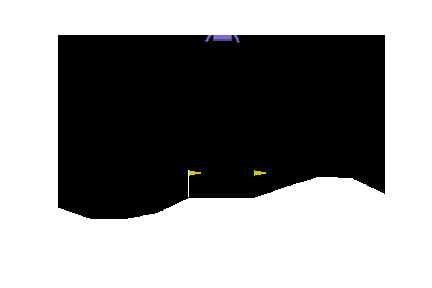
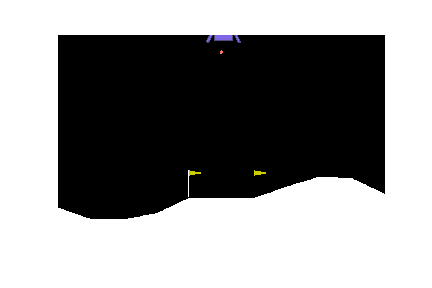
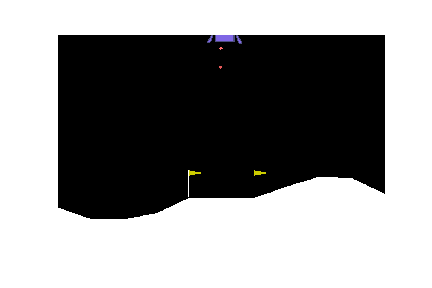
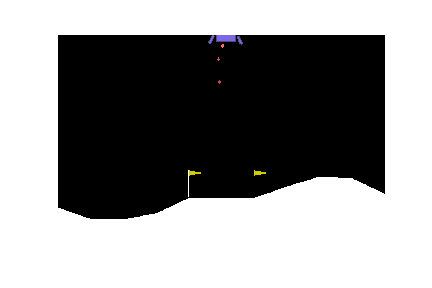
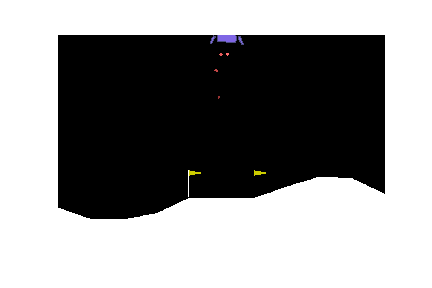
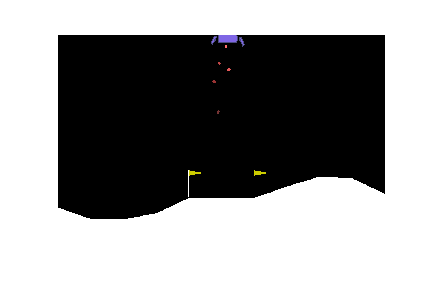
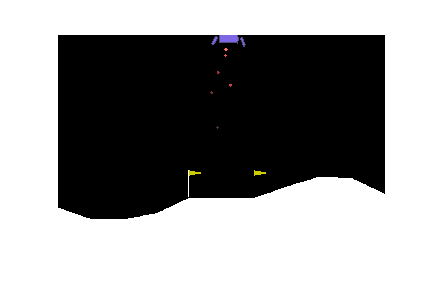
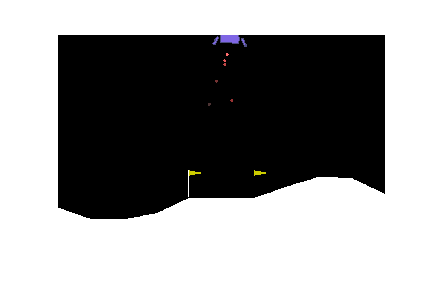
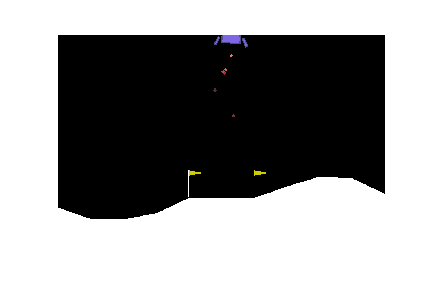
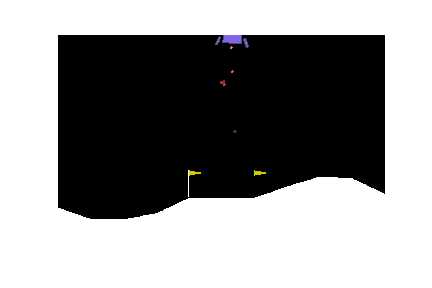
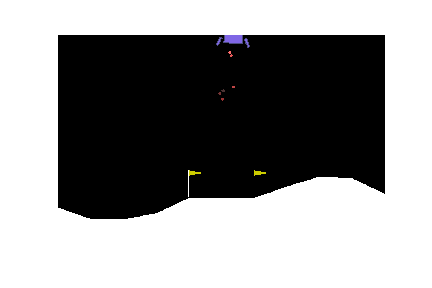
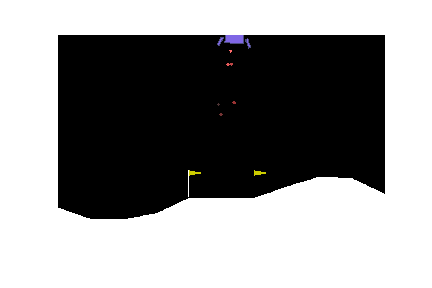
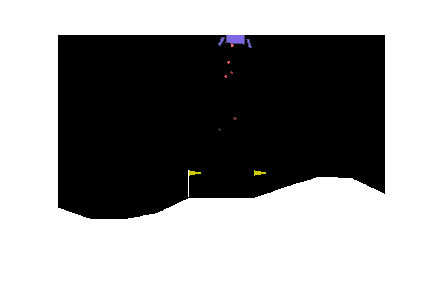
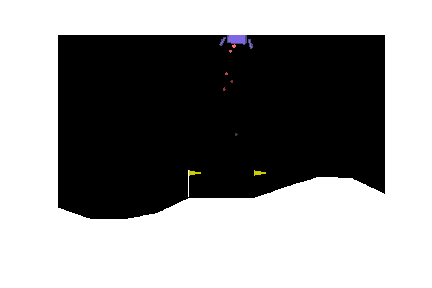
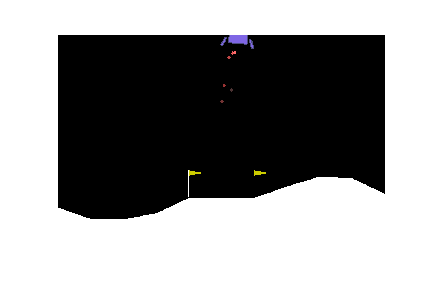
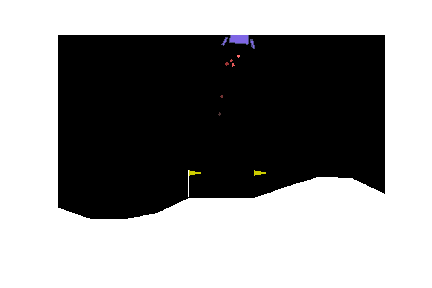
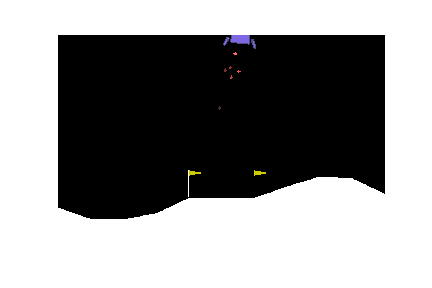
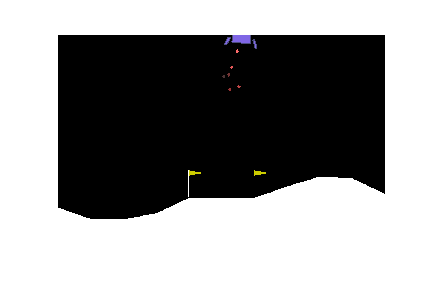
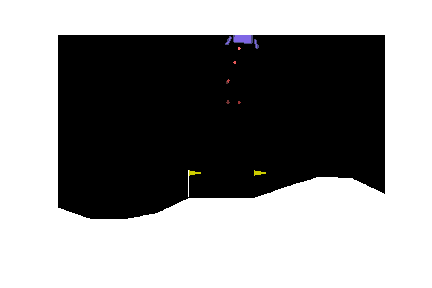
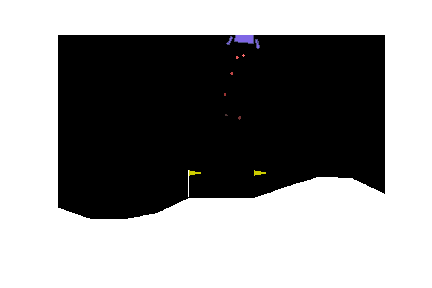
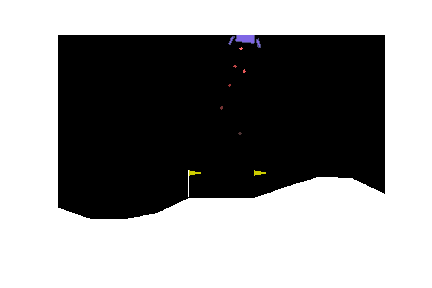
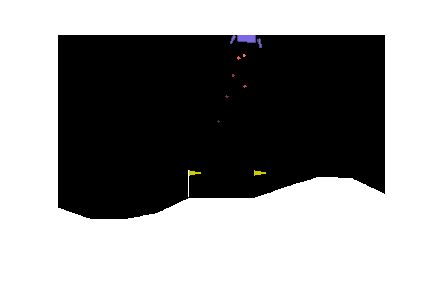
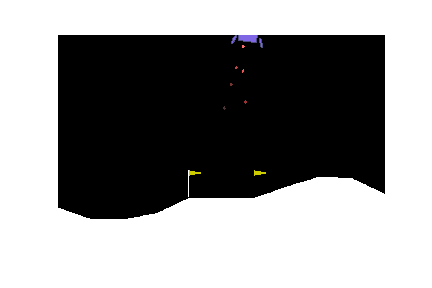
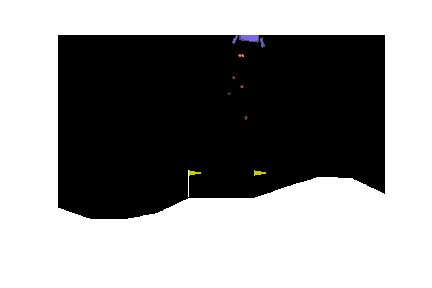
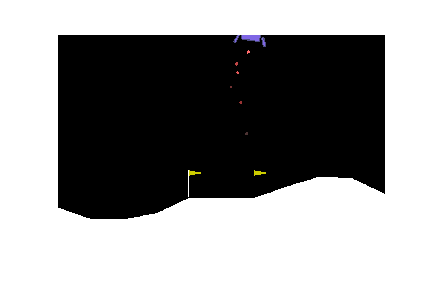
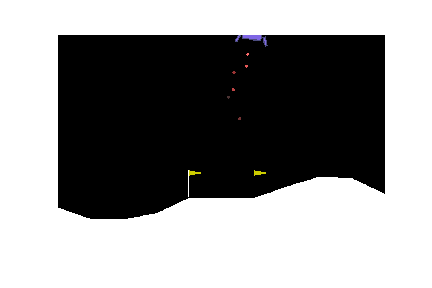
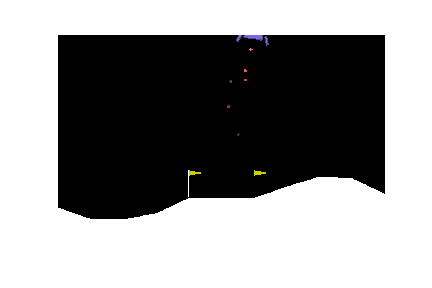
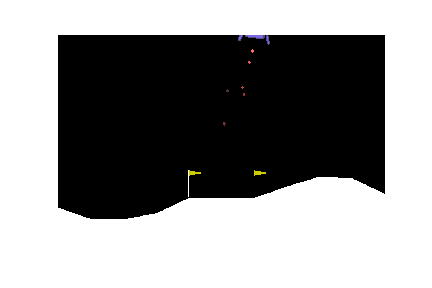
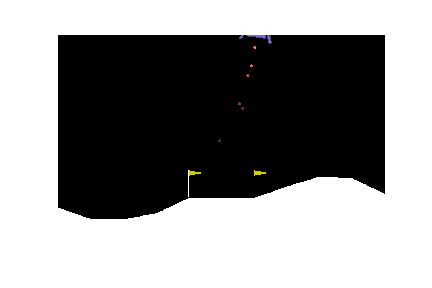
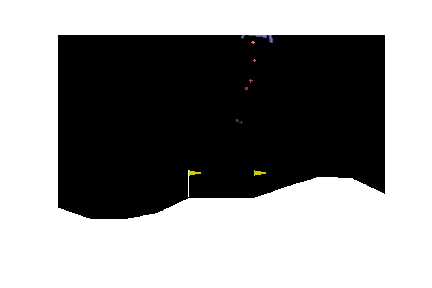
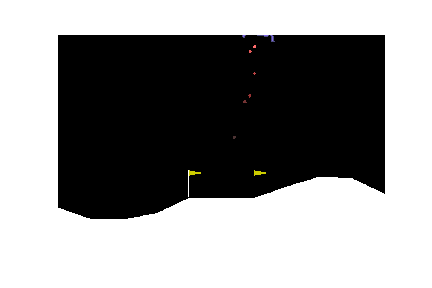
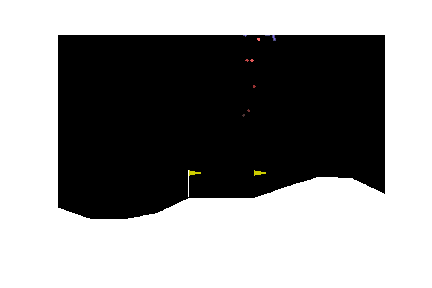
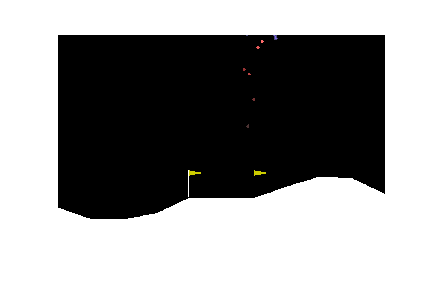
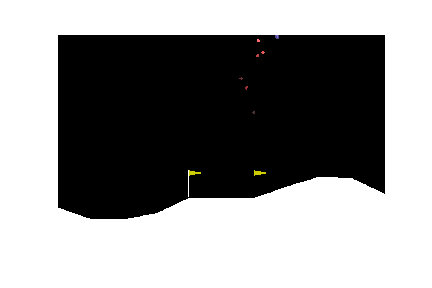
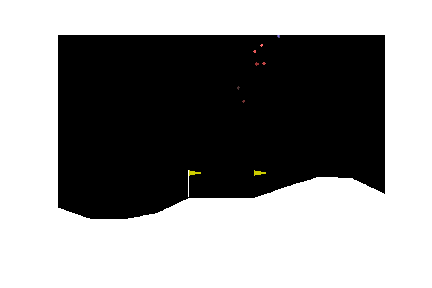
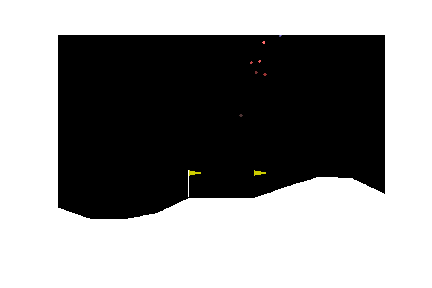
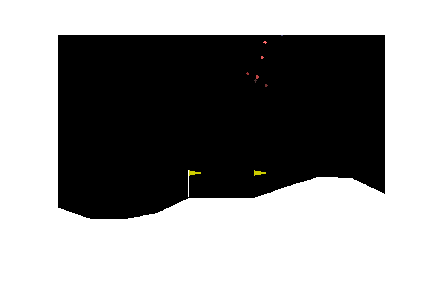
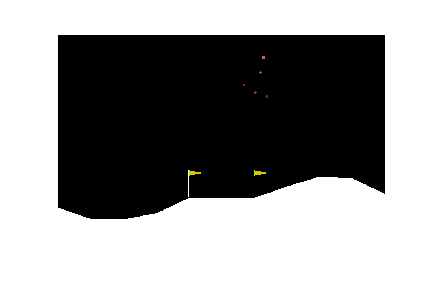
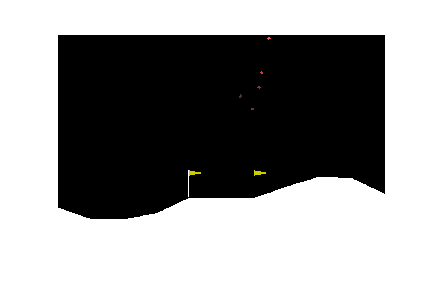
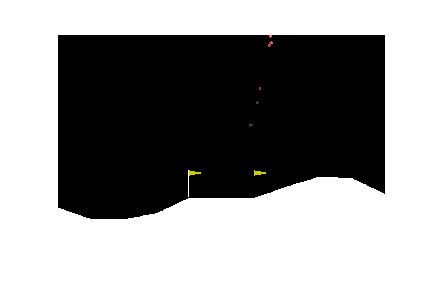
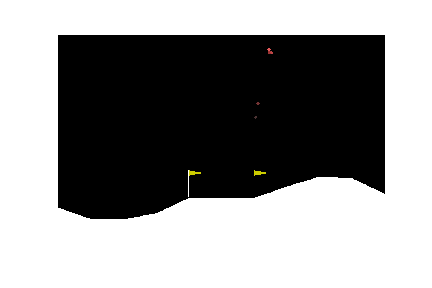
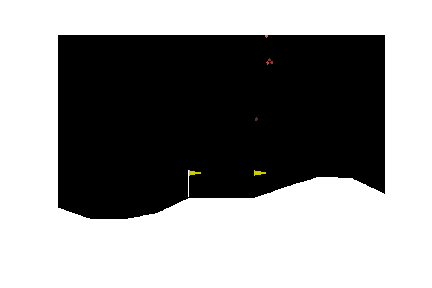
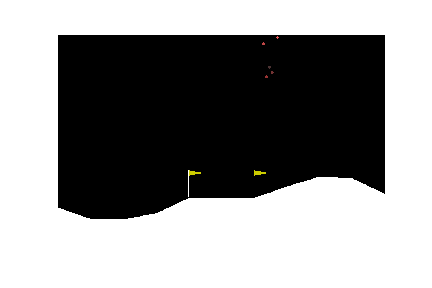
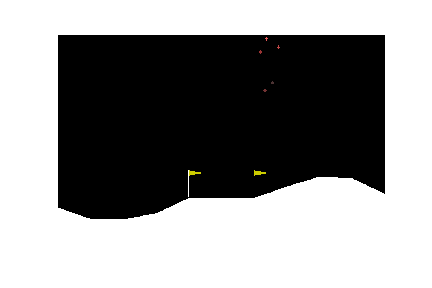
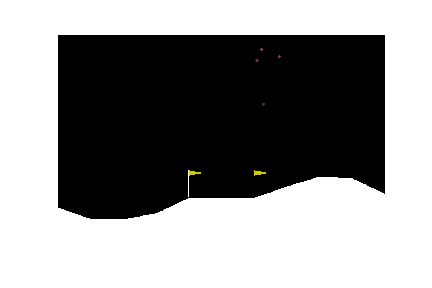
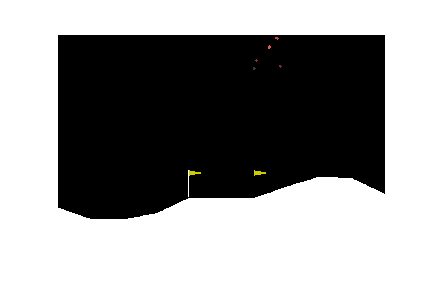
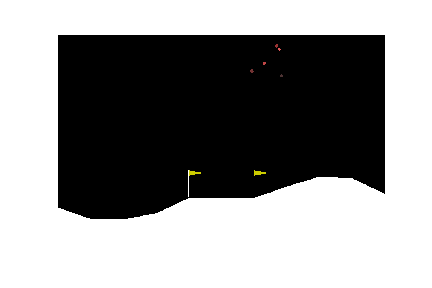
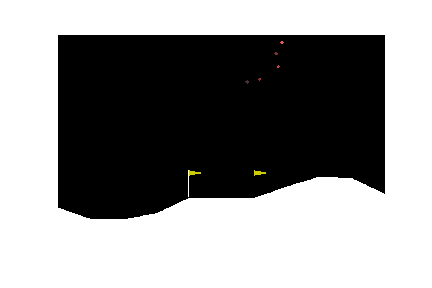
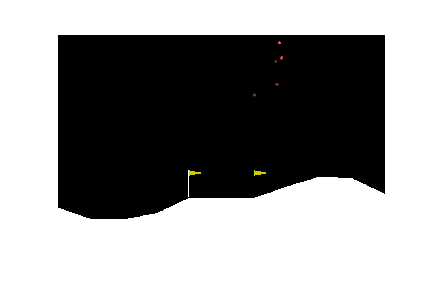
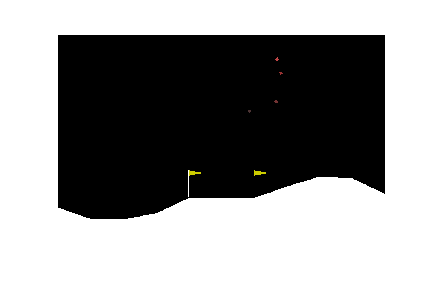
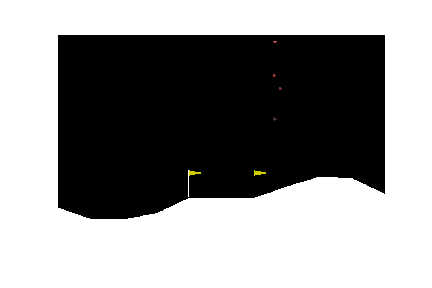
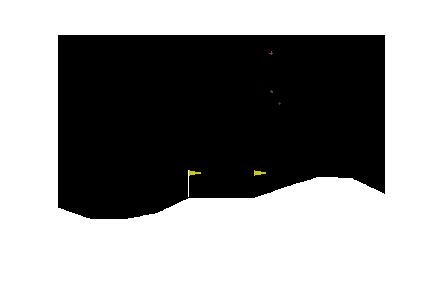
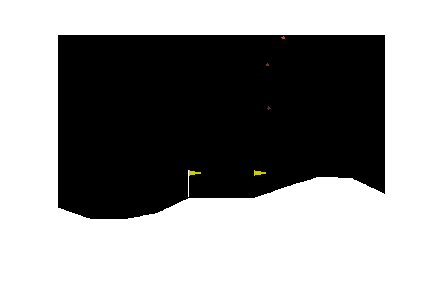
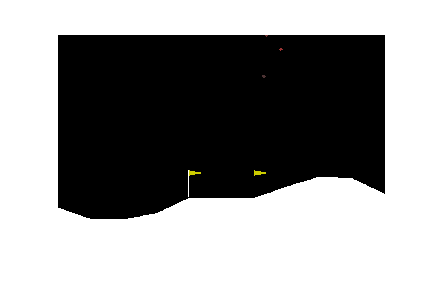
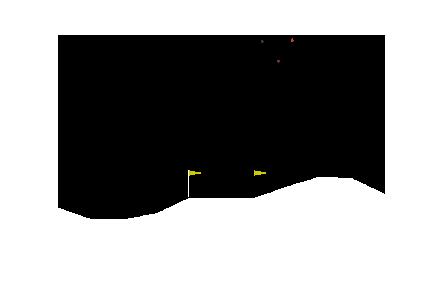
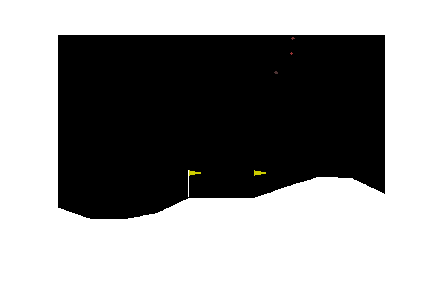
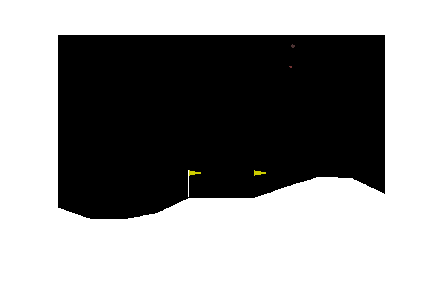
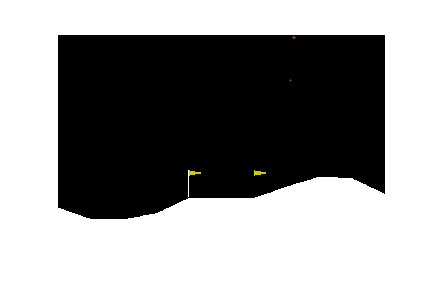
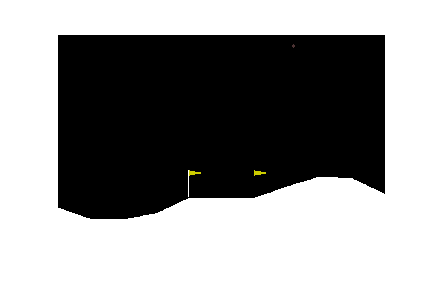
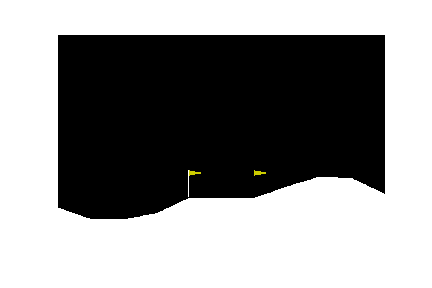
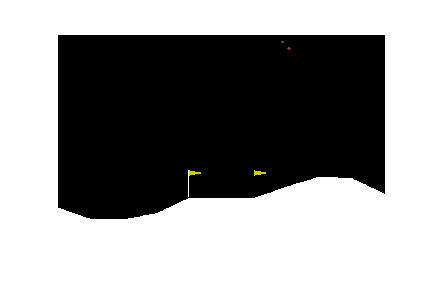
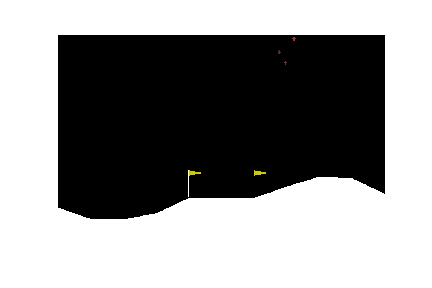
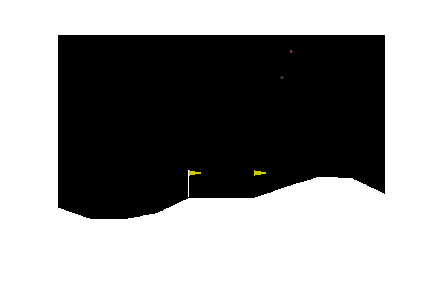
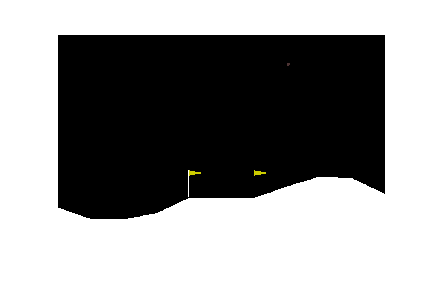
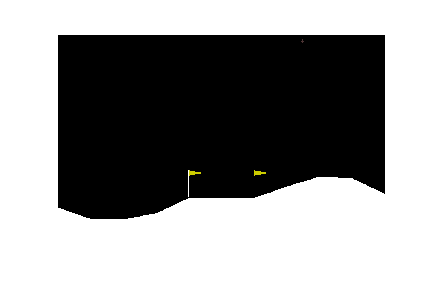
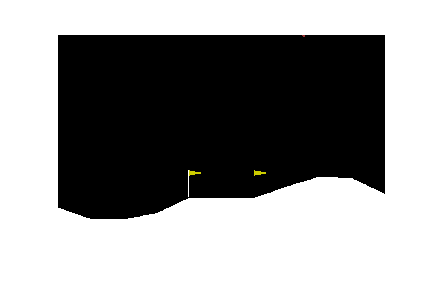
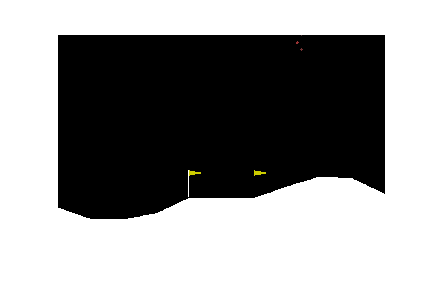
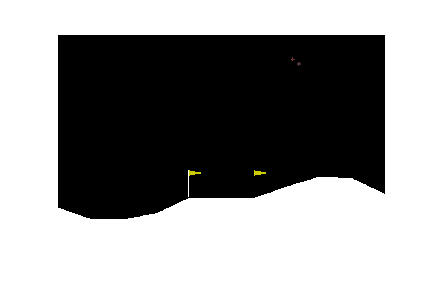
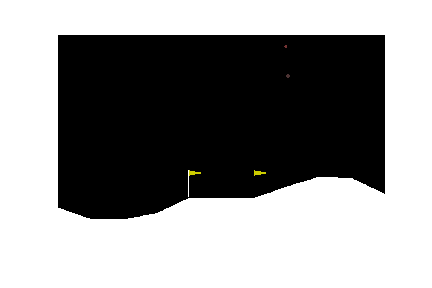
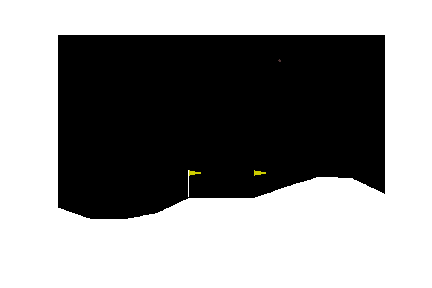
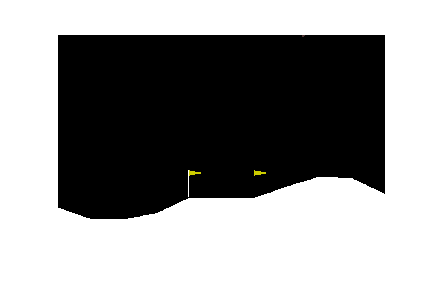
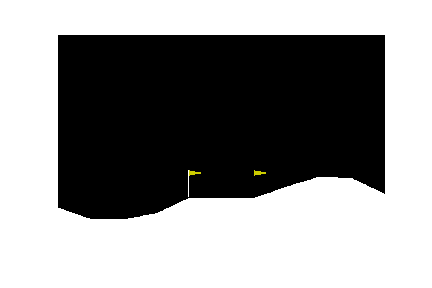
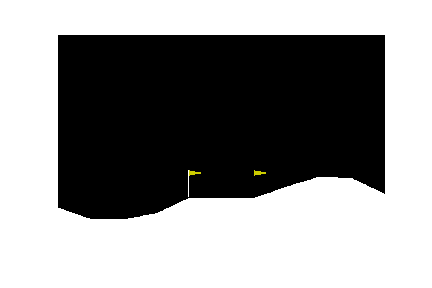
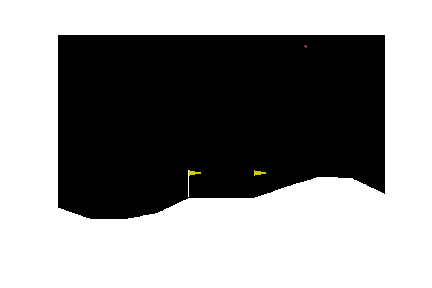
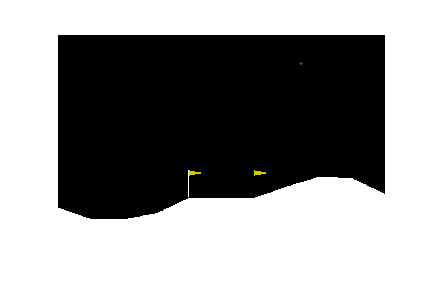
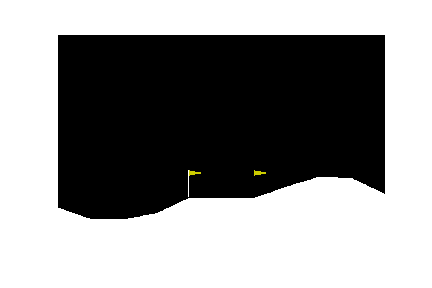
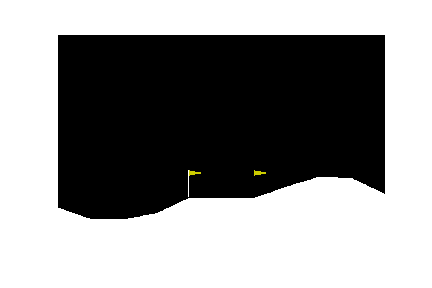
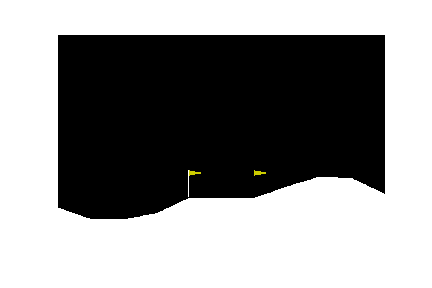
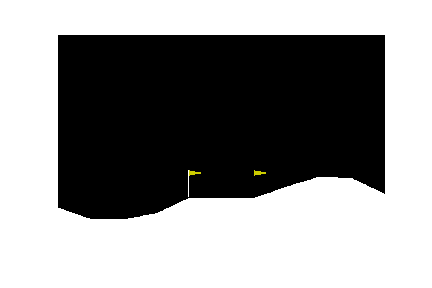
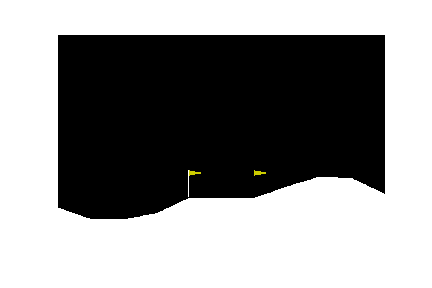
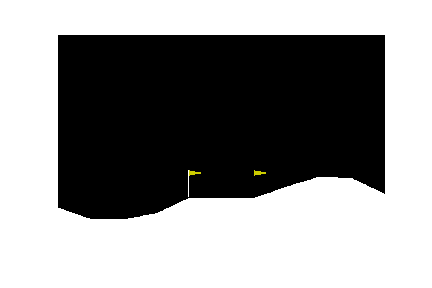
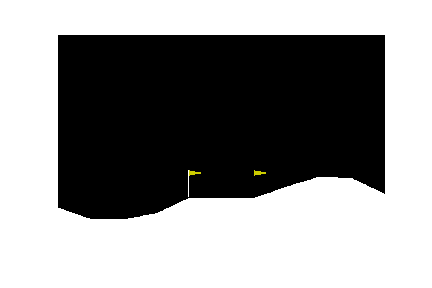
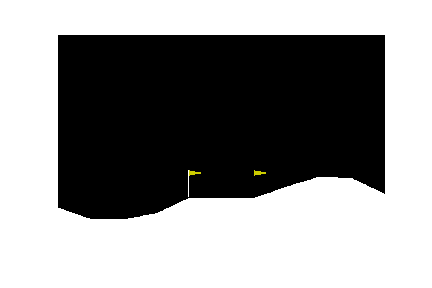
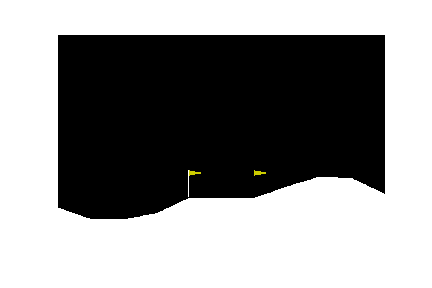
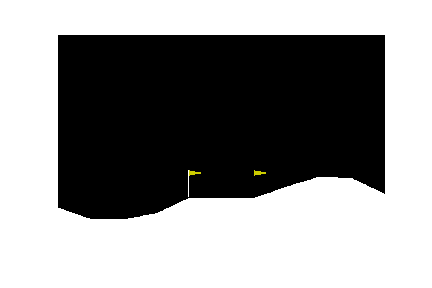
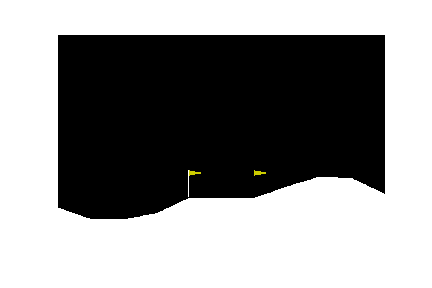
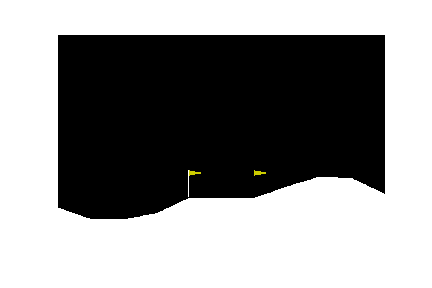
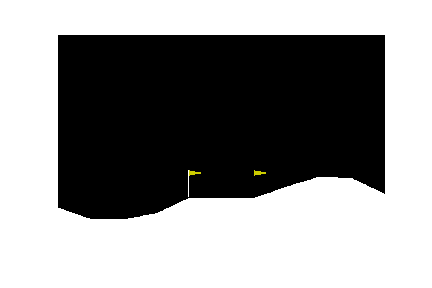

-498.5225597400383

In [6]:
episodeOnNet(example)

In [7]:
def fitness(net):
    episodes = 10
    env = gym.make('LunarLander-v2')
    sum_reward = 0
    for episode in range(episodes):
        observation = env.reset()
        for t in range(1000):
            action = np.argmax(net.run(observation))
            observation, reward, done, info = env.step(action)
            sum_reward += reward
            if done:
                break
    return sum_reward/episodes

fitness(example)

-723.920530889942

In [8]:
import copy

def do_generation(pop, survive=10, rand=40, mr=2e-1):
    fit = list(map(fitness, pop))
    fit, pop = zip(* list(reversed( 
        sorted( zip(fit, pop) ) 
    )))
    pop = list(pop)
    pop_size = len(pop)
    for i in range(survive, pop_size-rand):
        pop[i] = copy.deepcopy( pop[i%survive] )
        pop[i].mutate(mr)
    for i in range(pop_size-rand, pop_size):
        pop[i] = Net()
    return pop, fit[0]

-110.97386102305697



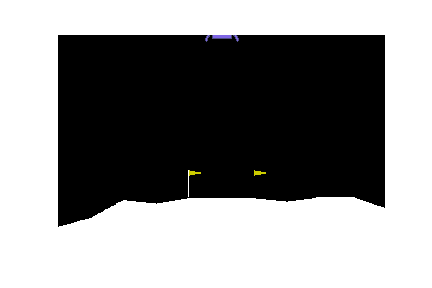
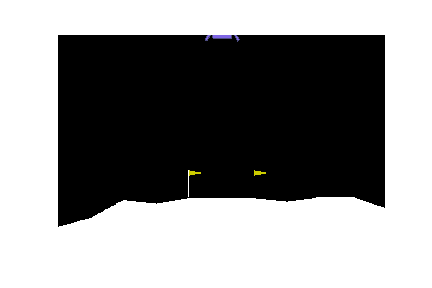
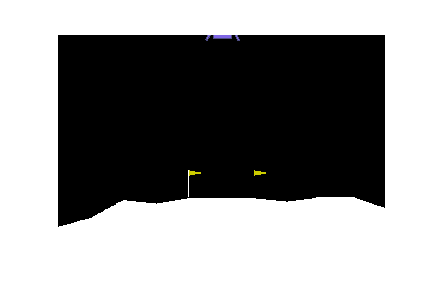
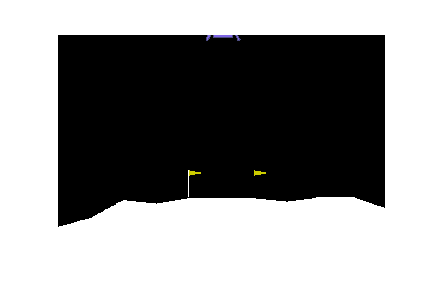
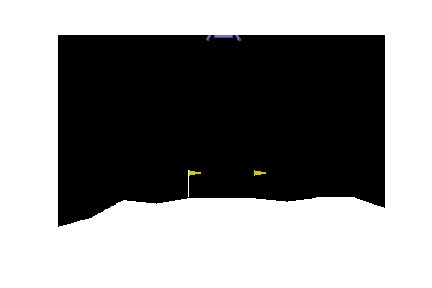
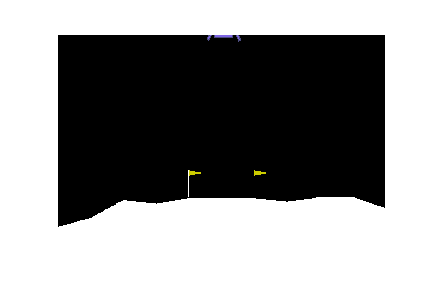
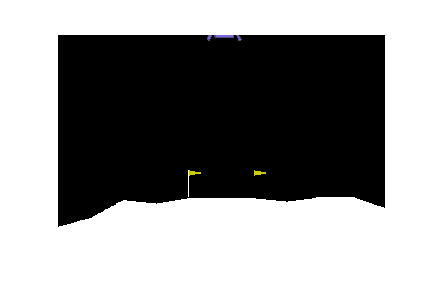
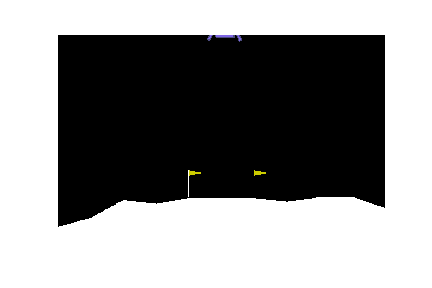
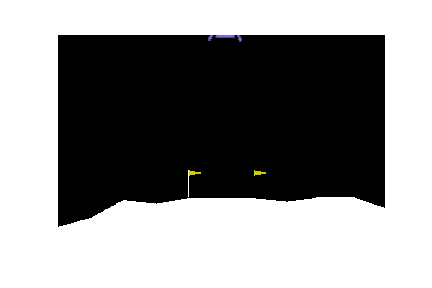
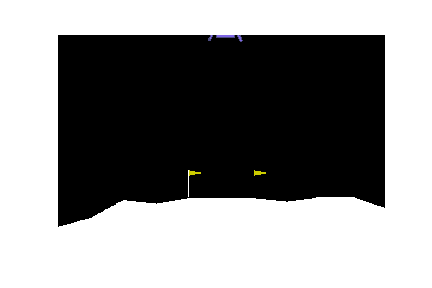
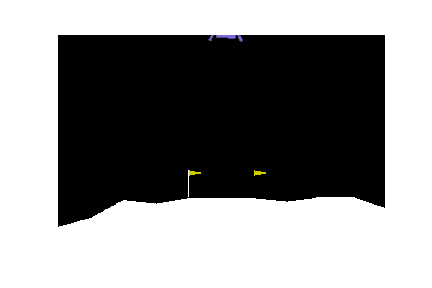
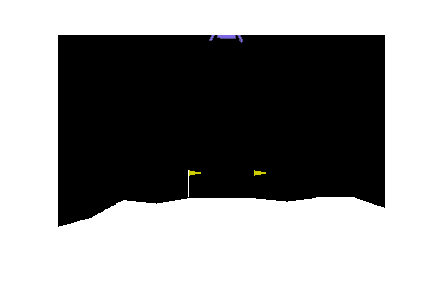
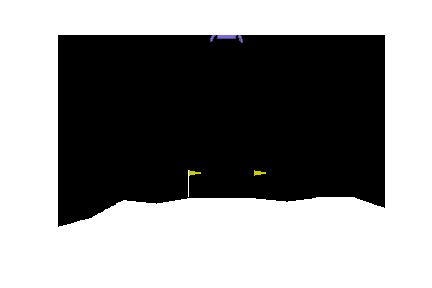
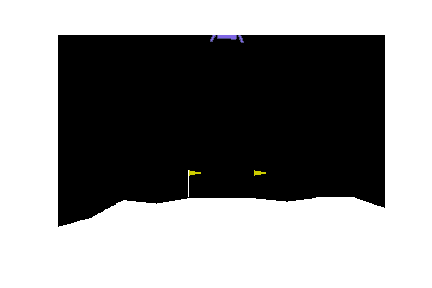
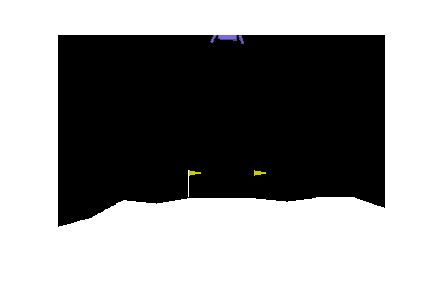
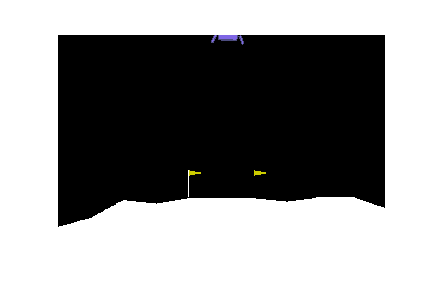
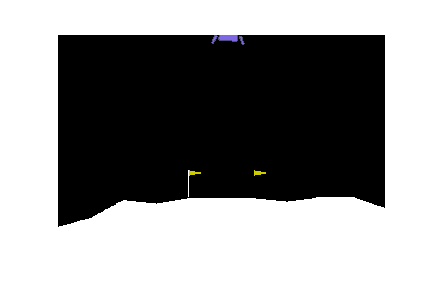
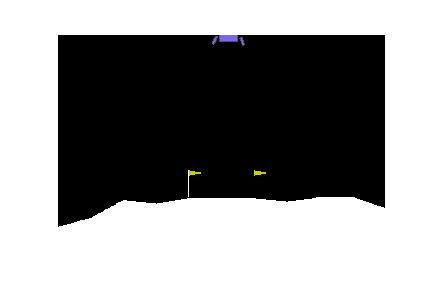
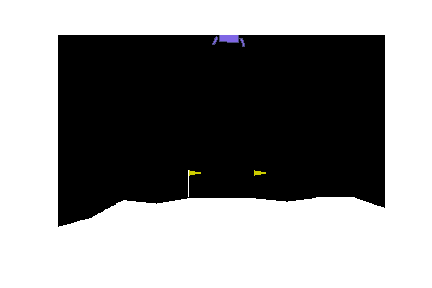
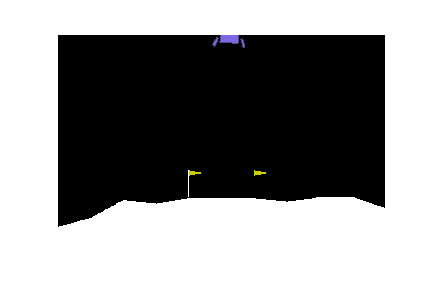
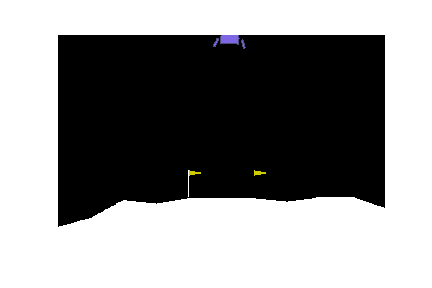
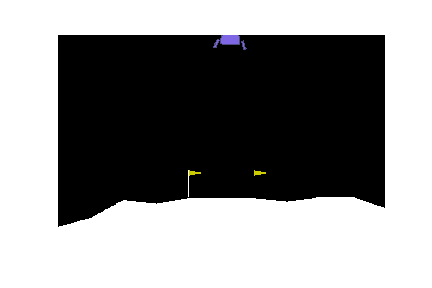
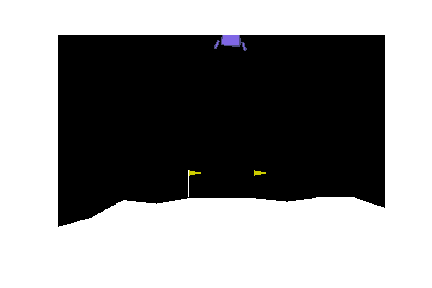
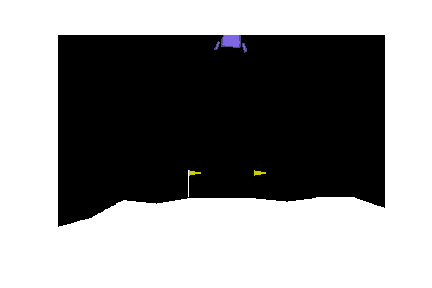
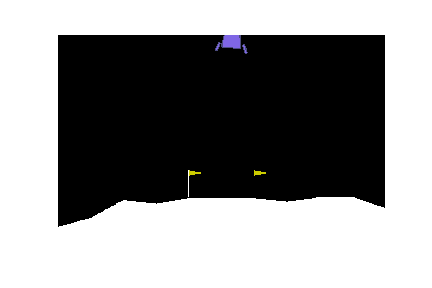
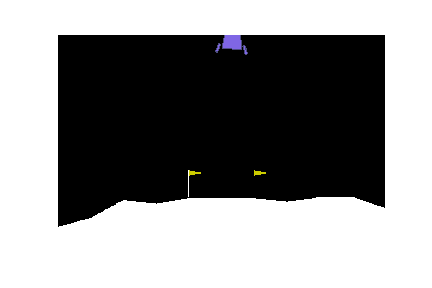
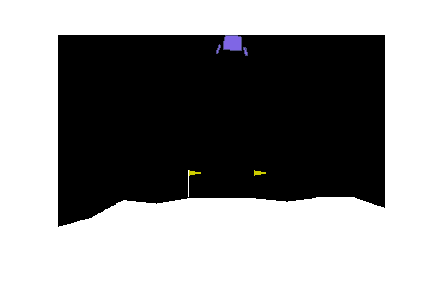
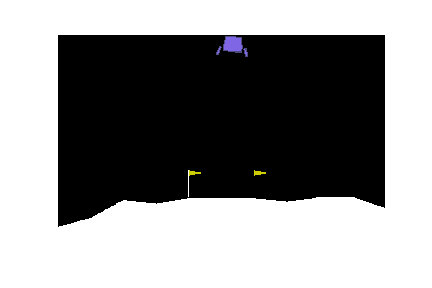
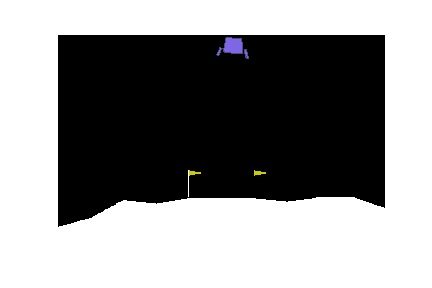
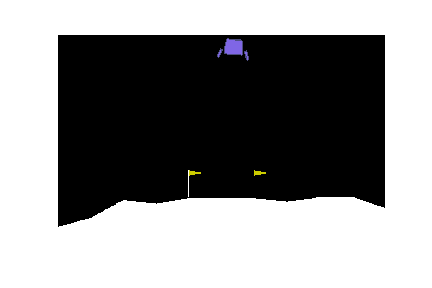
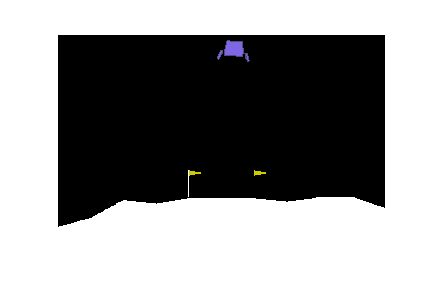
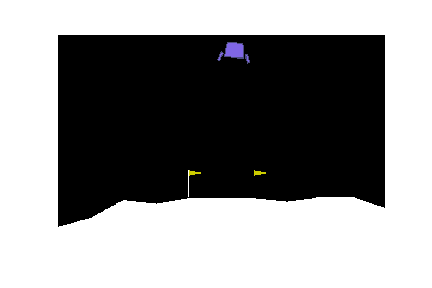
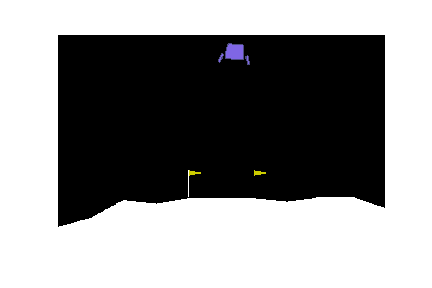
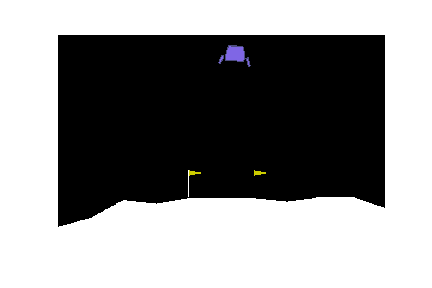
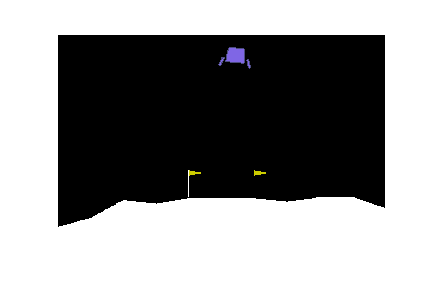
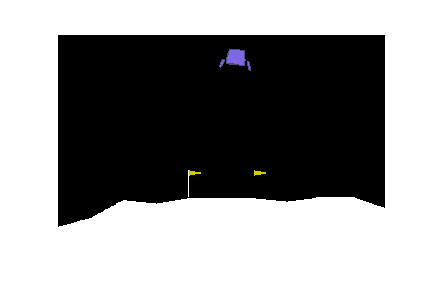
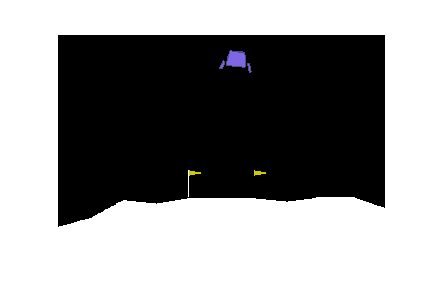
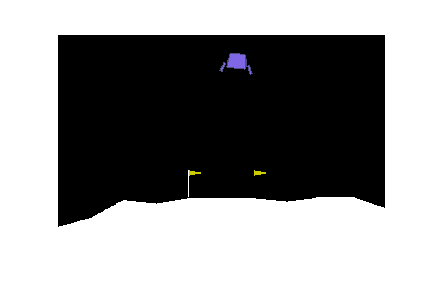
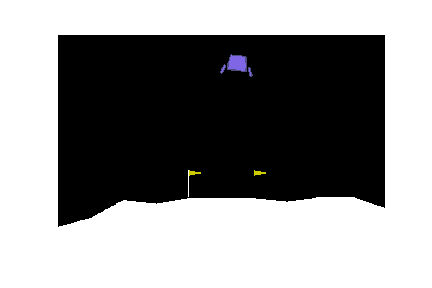
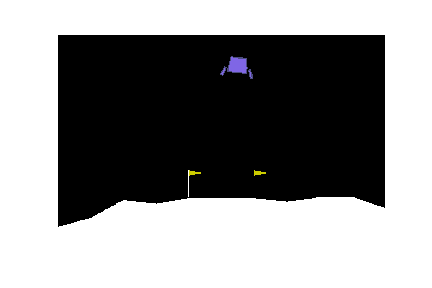
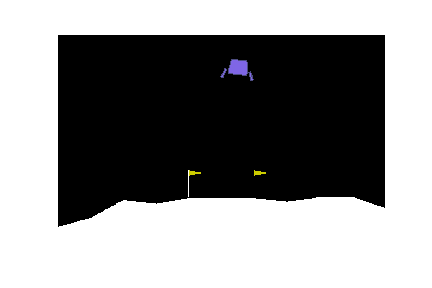
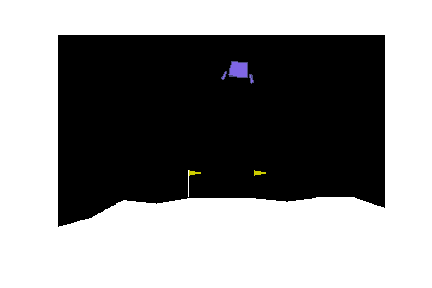
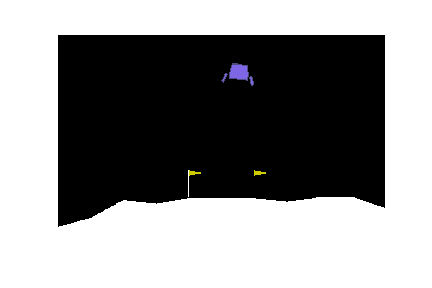
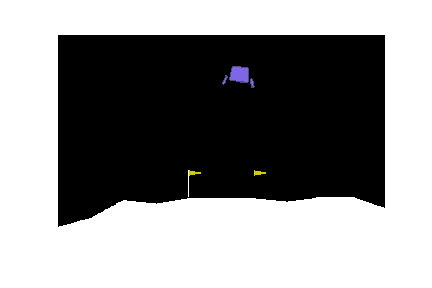
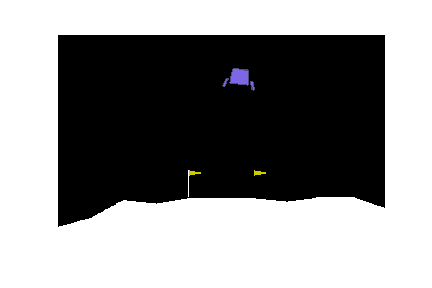
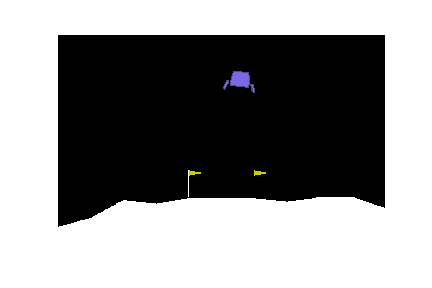
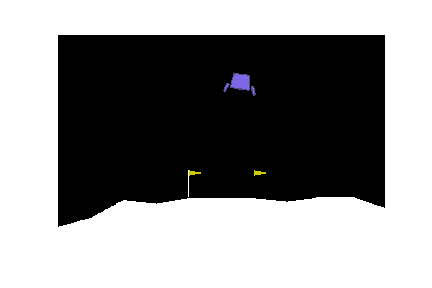
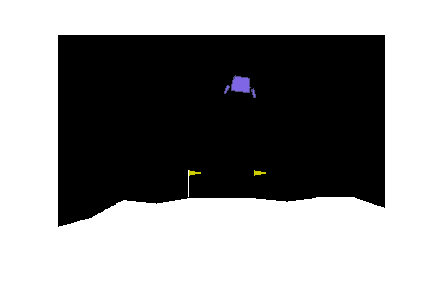
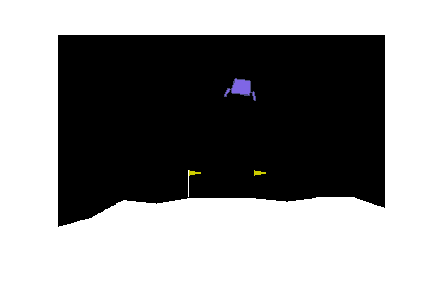
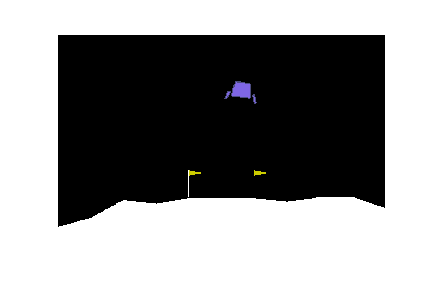
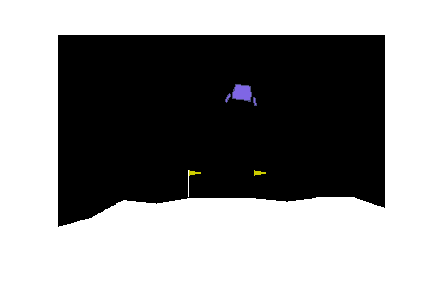
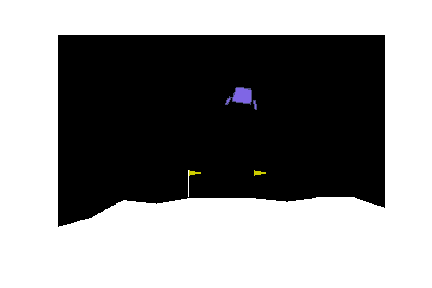
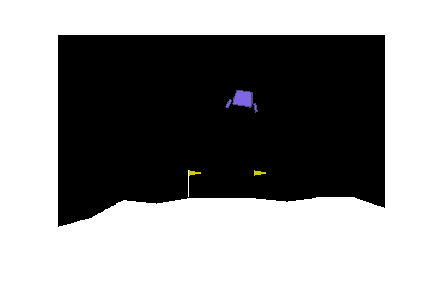
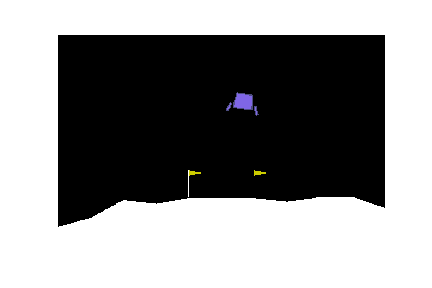
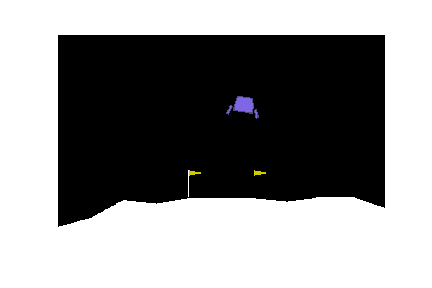
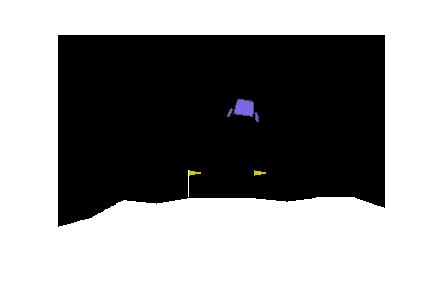
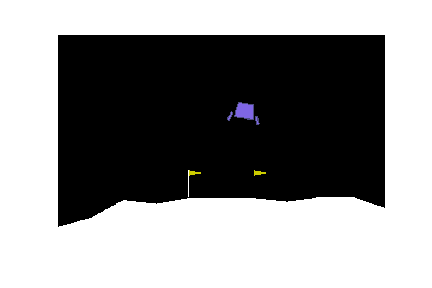
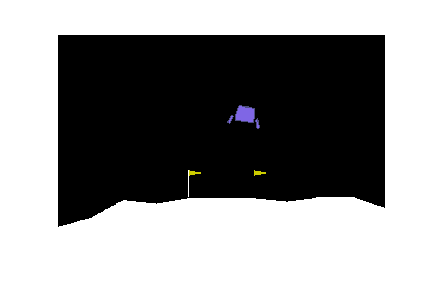
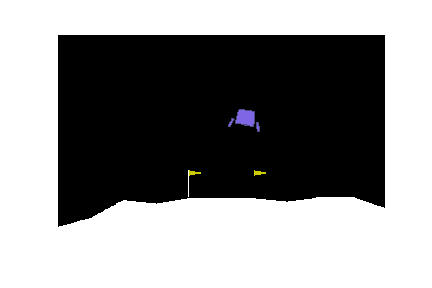
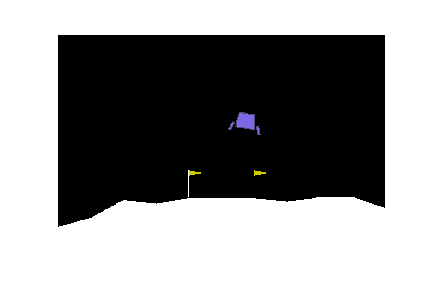
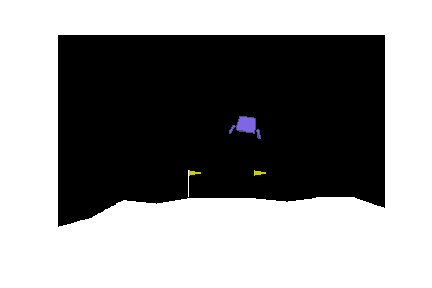
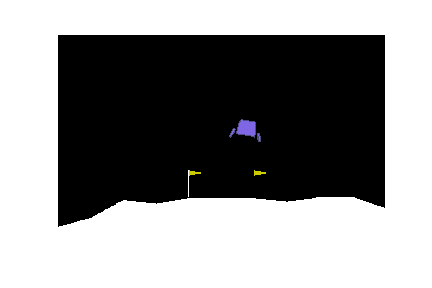
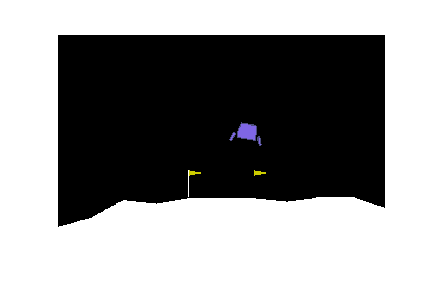
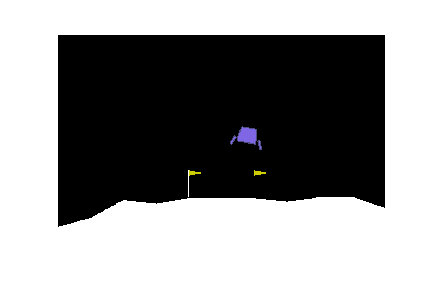
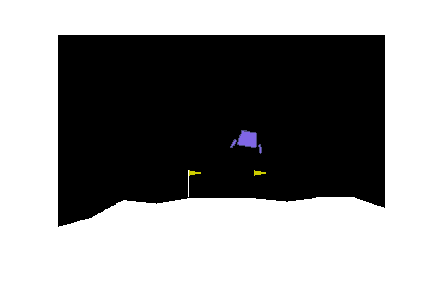
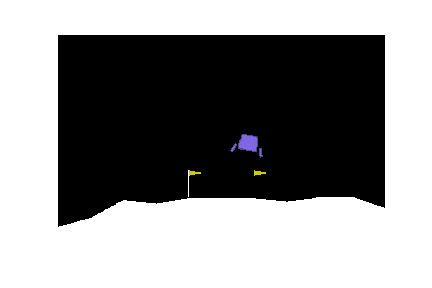
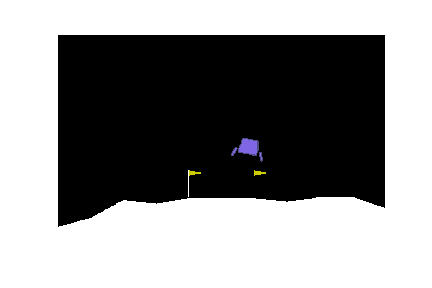
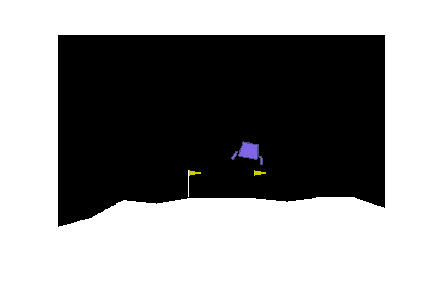
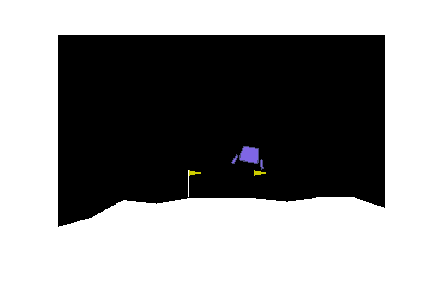
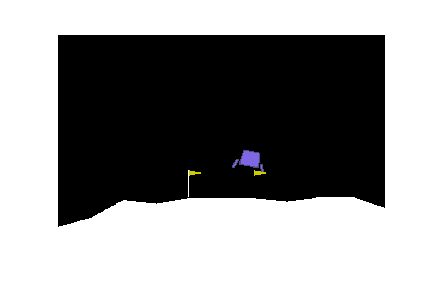
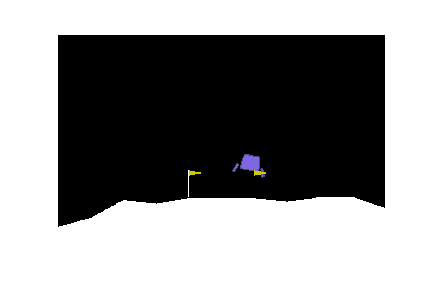
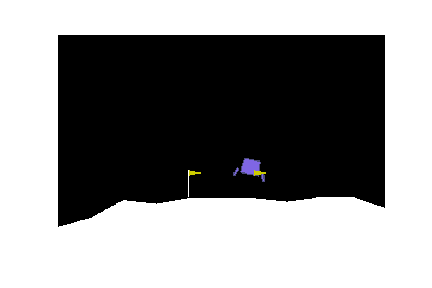
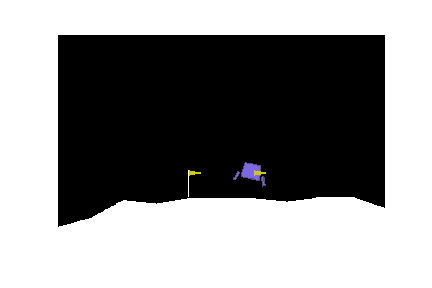
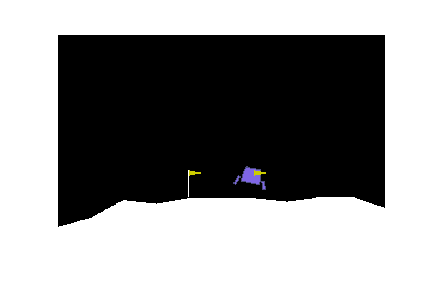
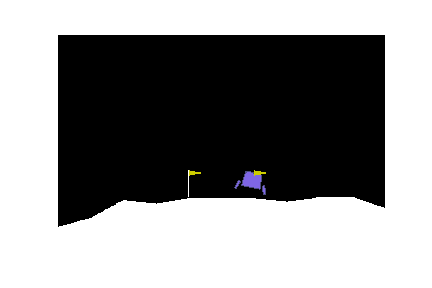
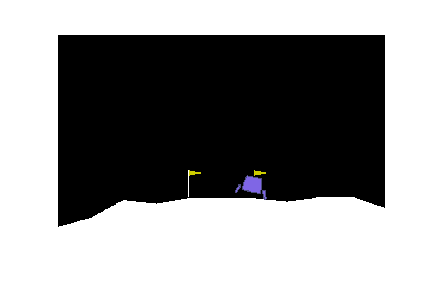
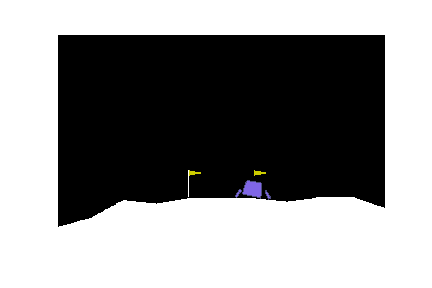


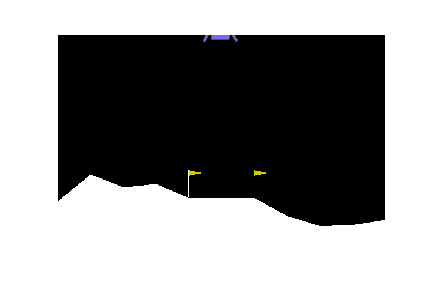
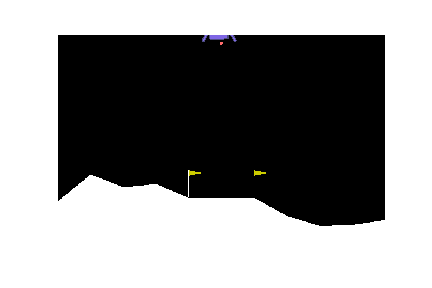
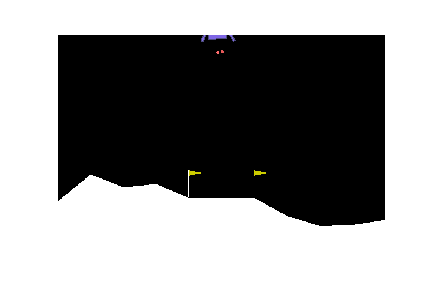
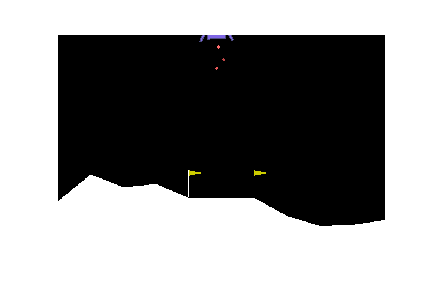
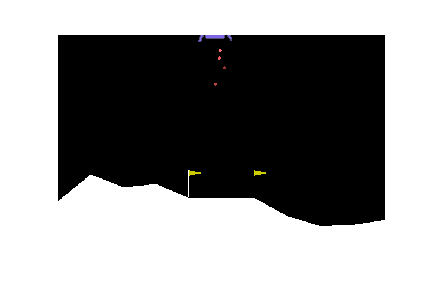
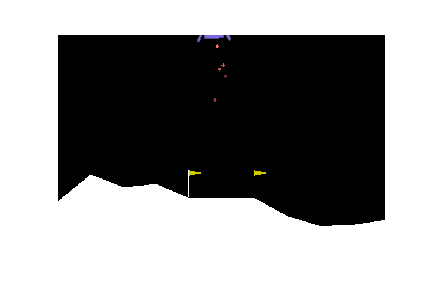
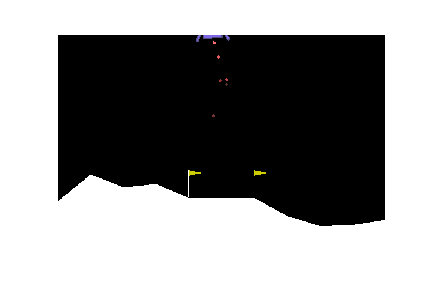
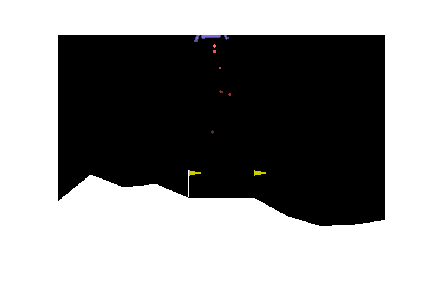
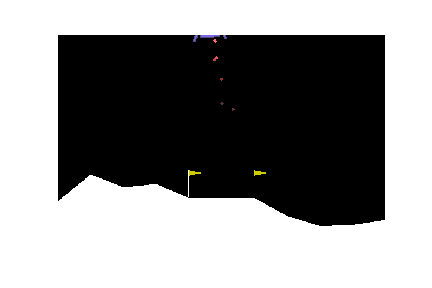
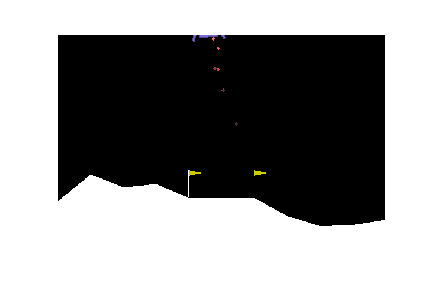
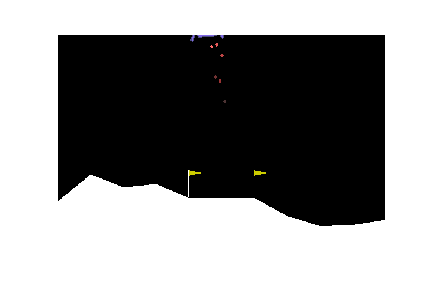
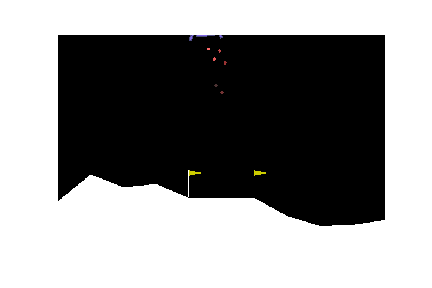
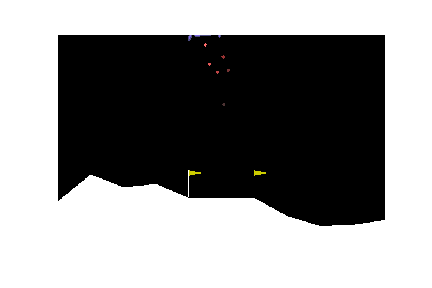
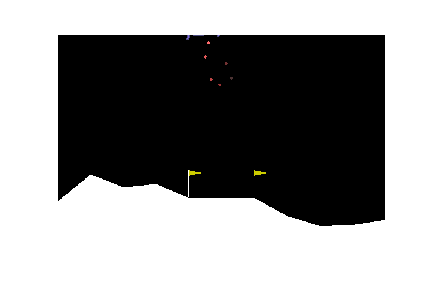
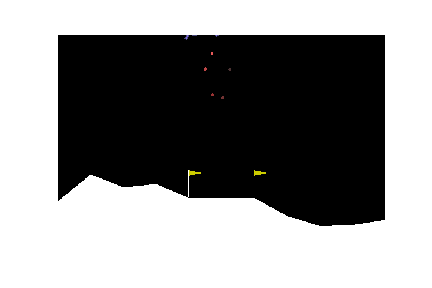
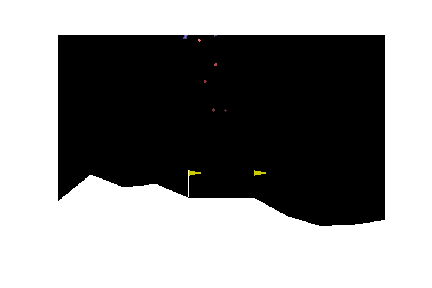
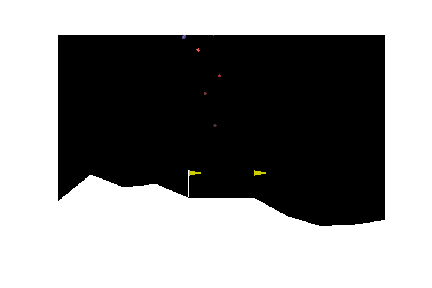
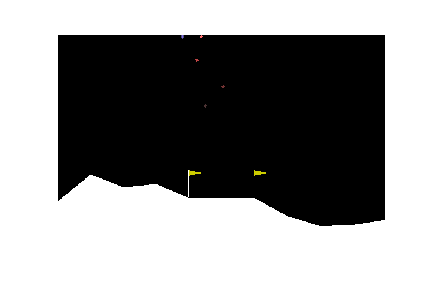
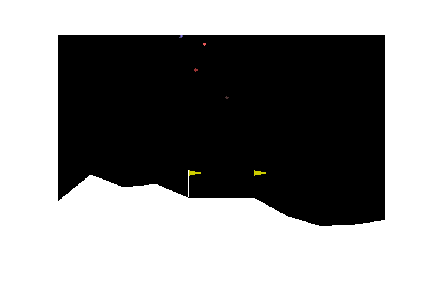
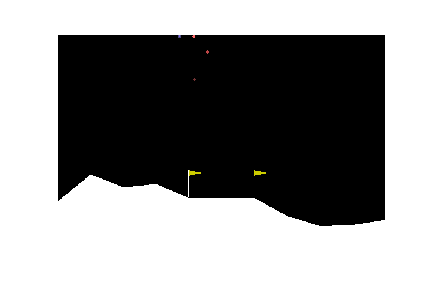
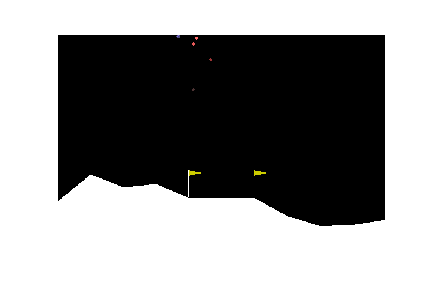
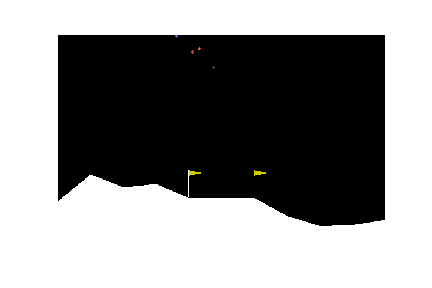
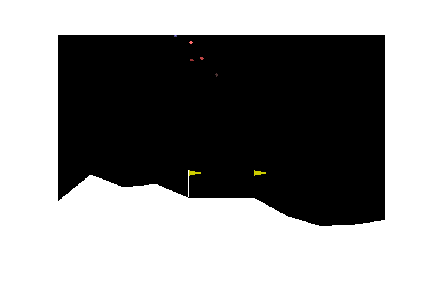
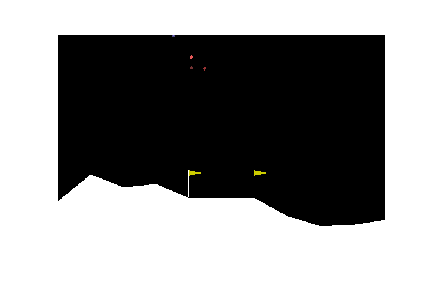
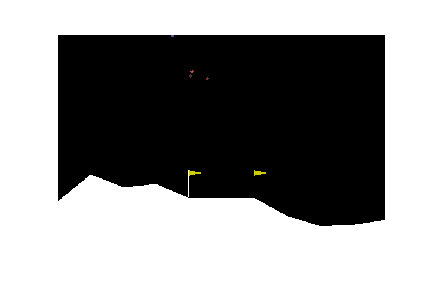
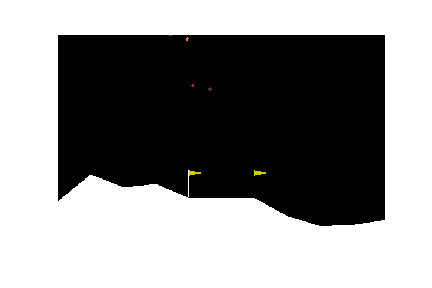
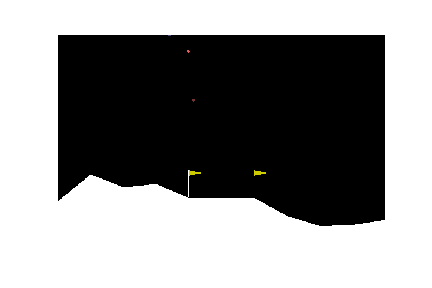
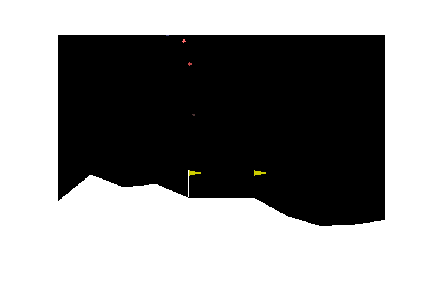
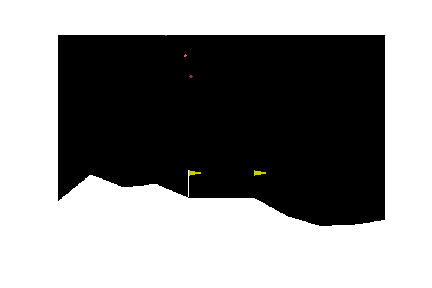
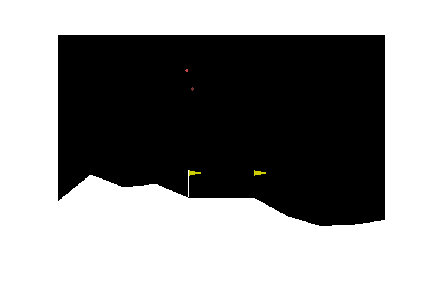
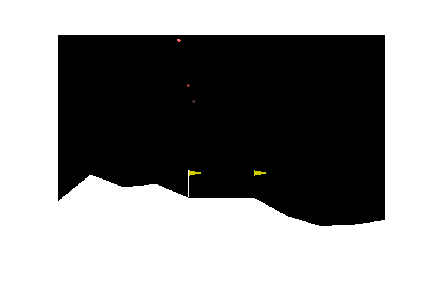
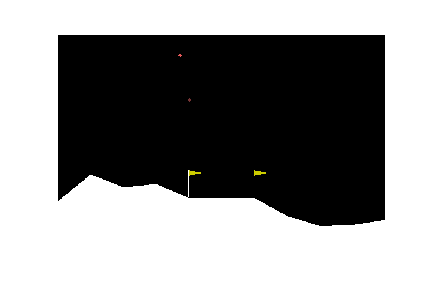
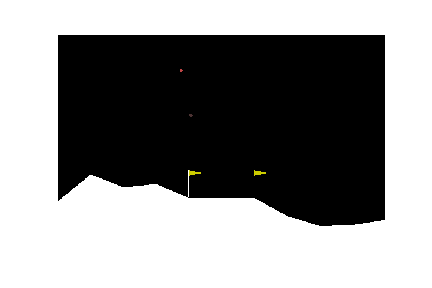
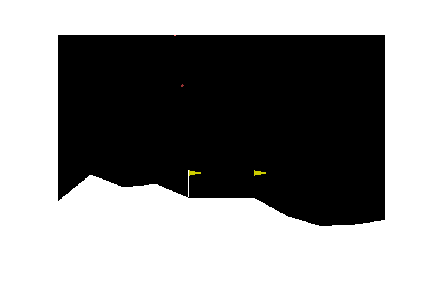
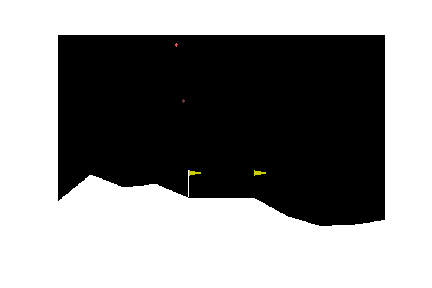
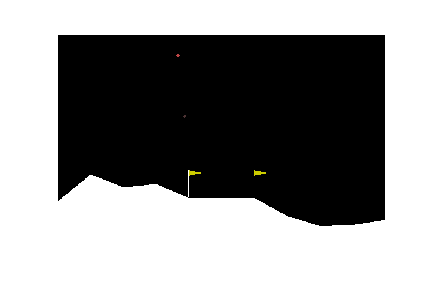
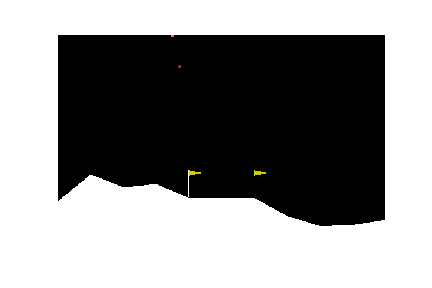
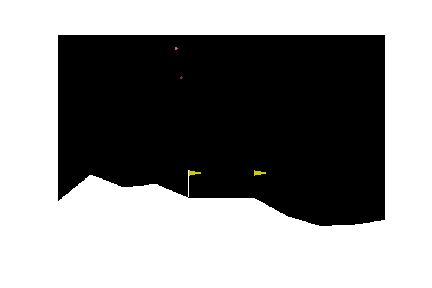
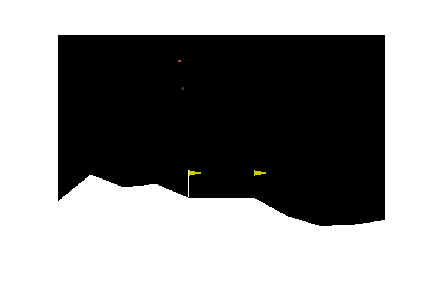
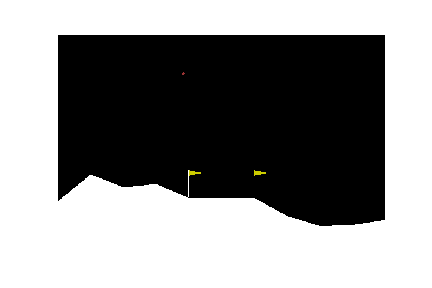
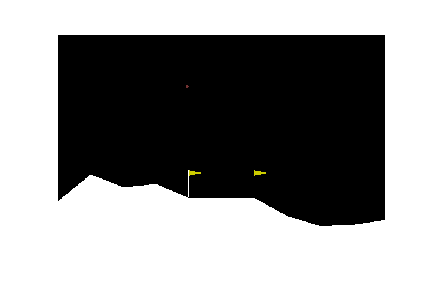
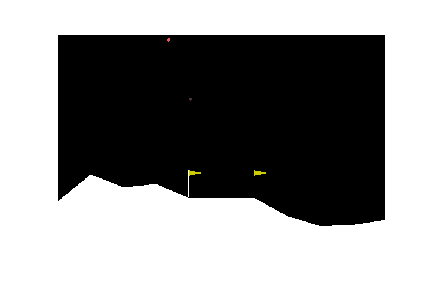
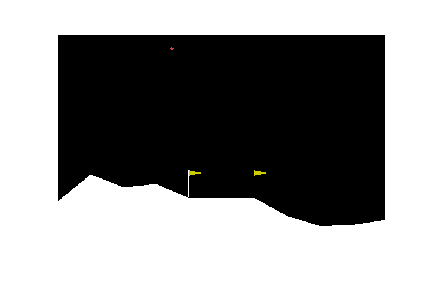
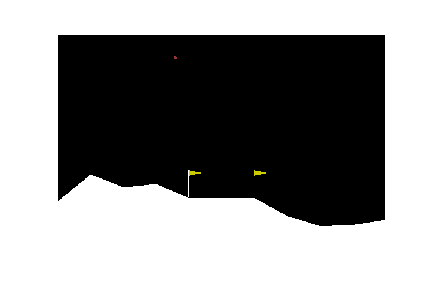
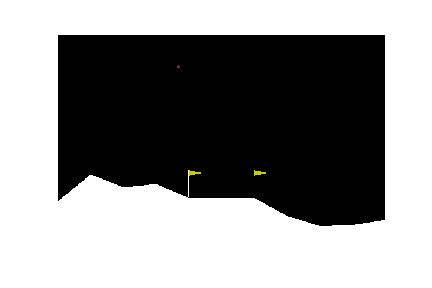
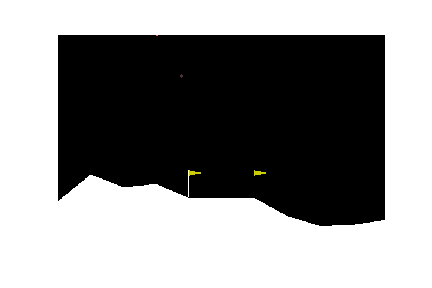
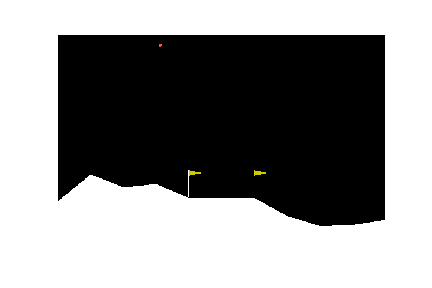
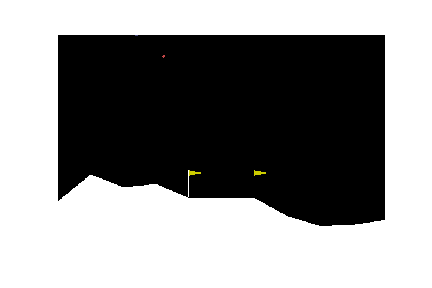
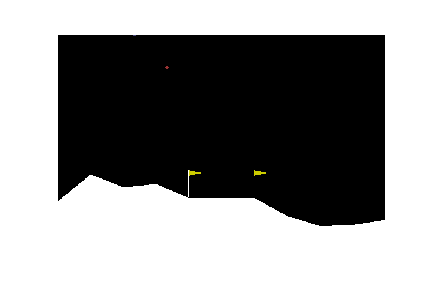
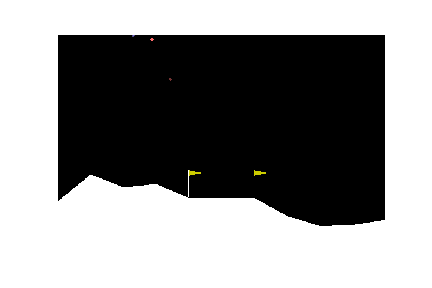
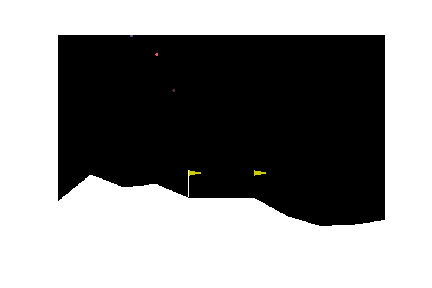
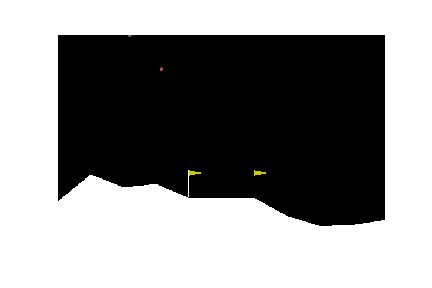
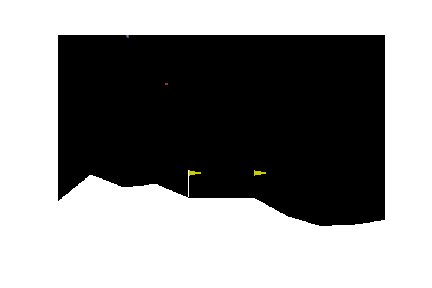
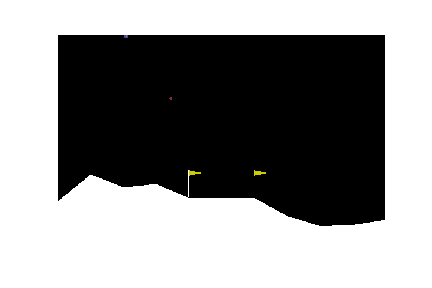
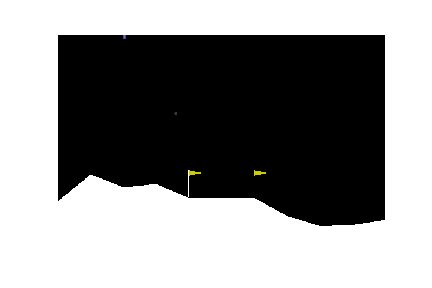
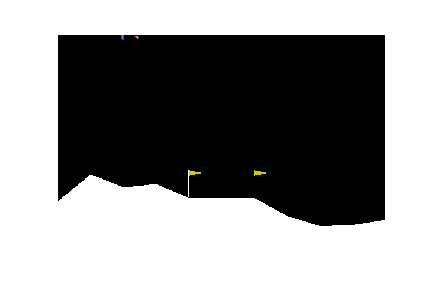
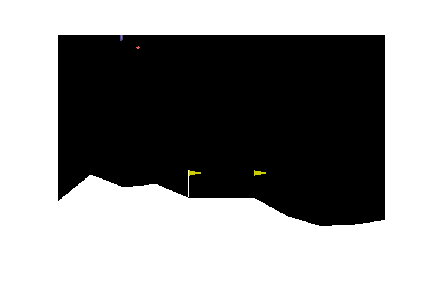
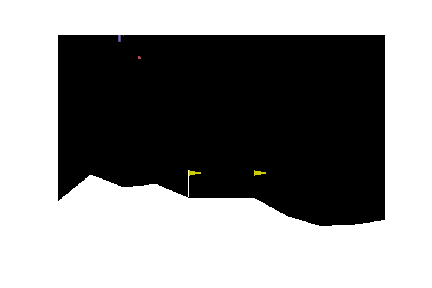
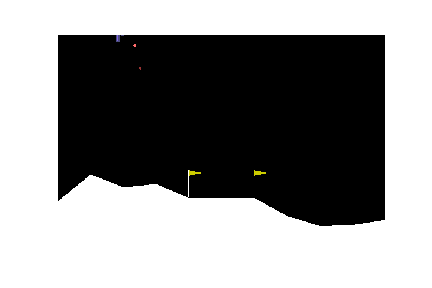
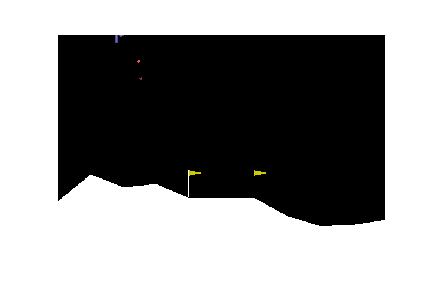
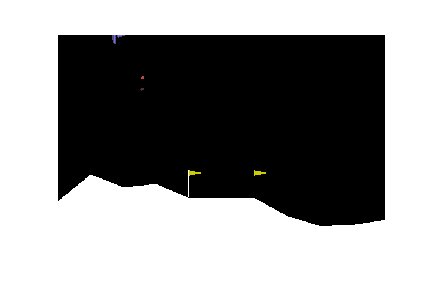
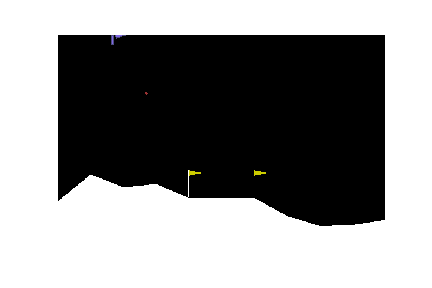
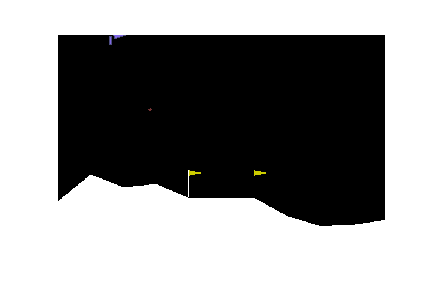
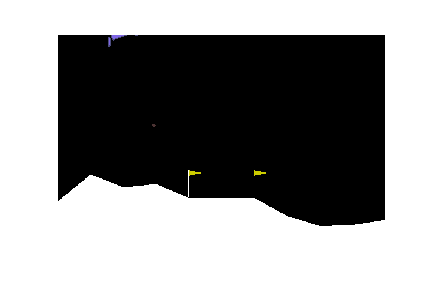
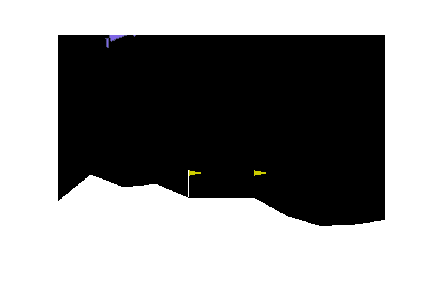
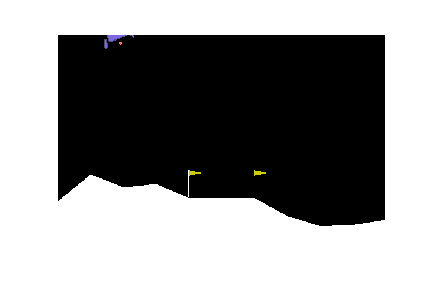
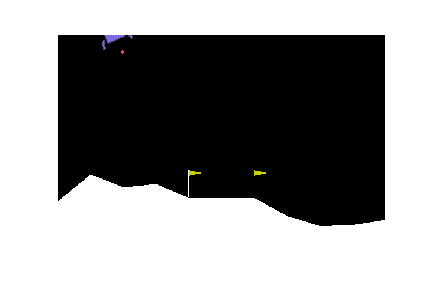
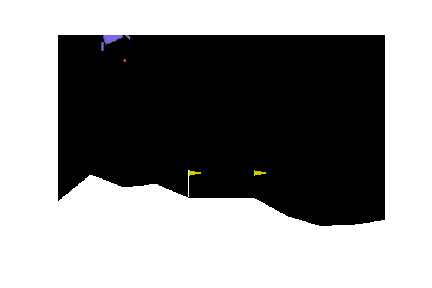
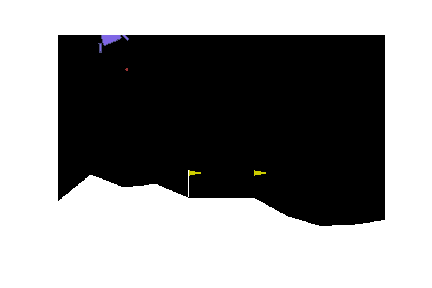
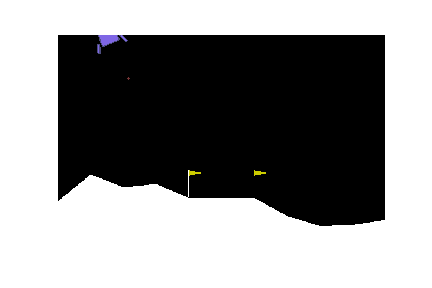
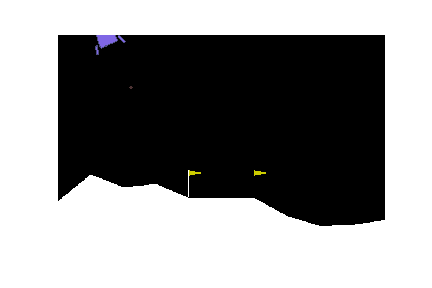
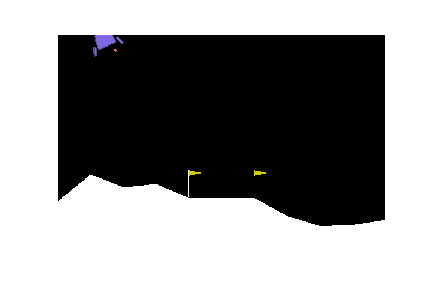
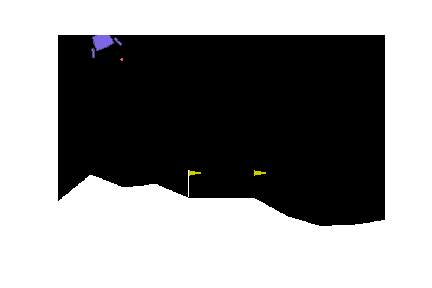
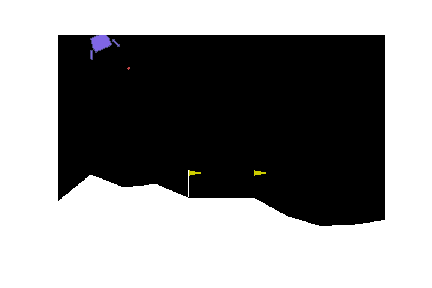
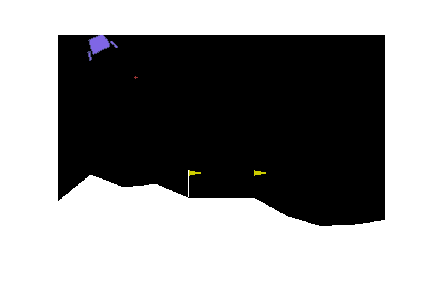
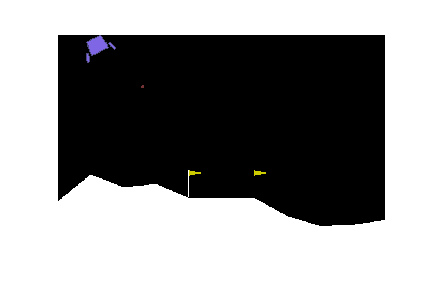
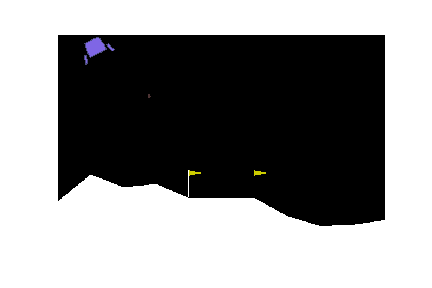
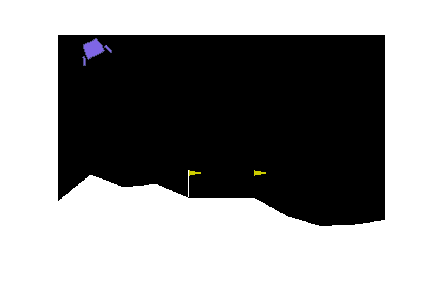
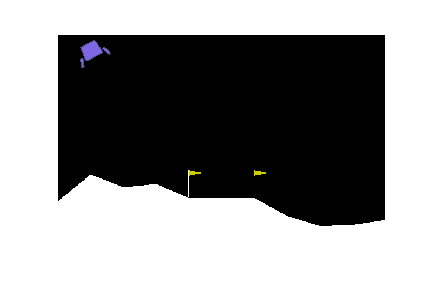
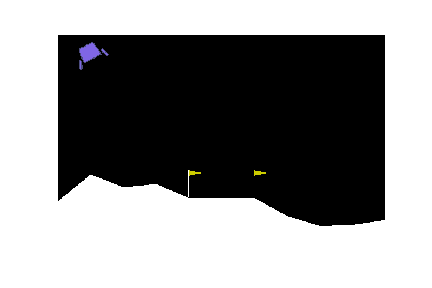
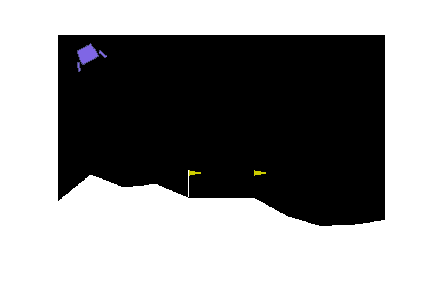
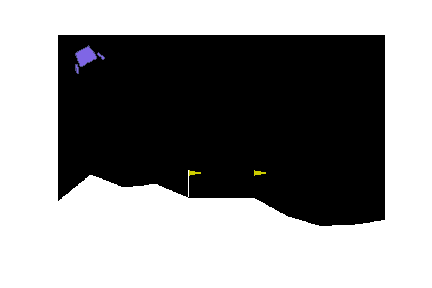
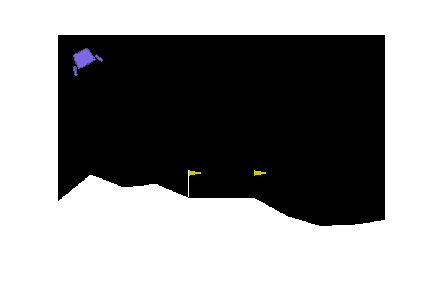
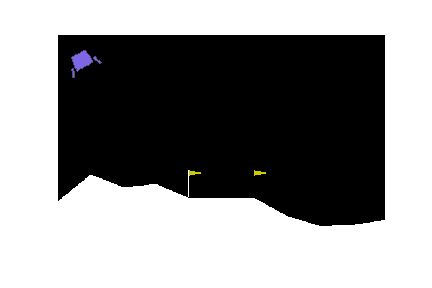
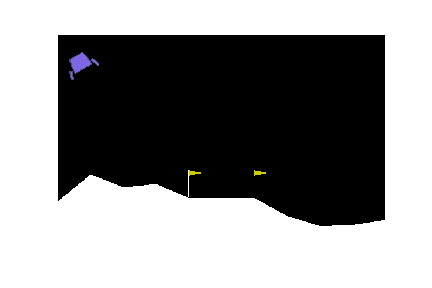
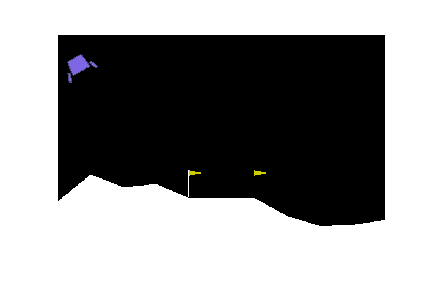
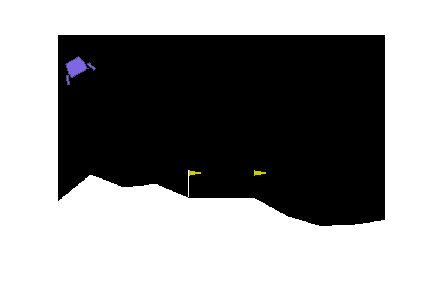
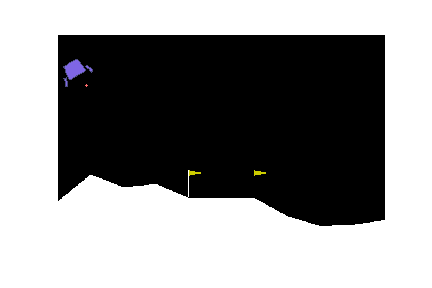
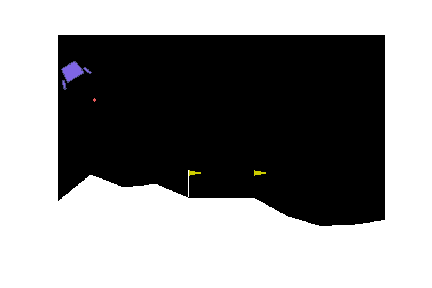
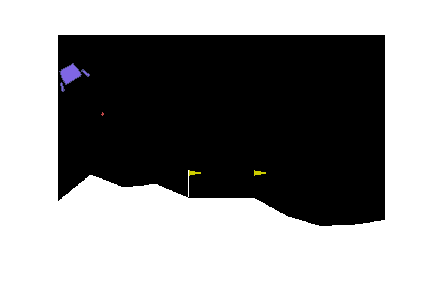
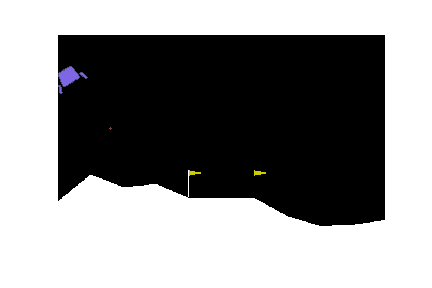
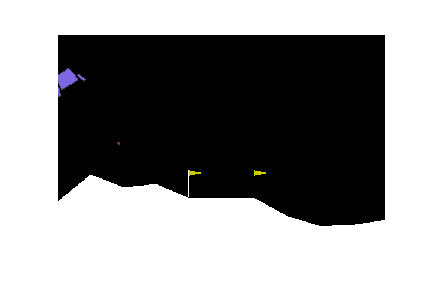
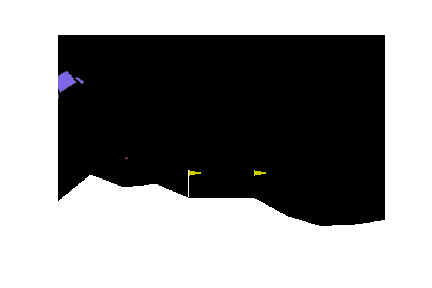
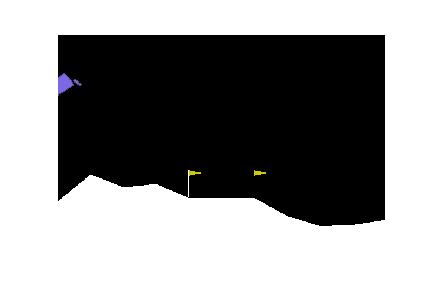
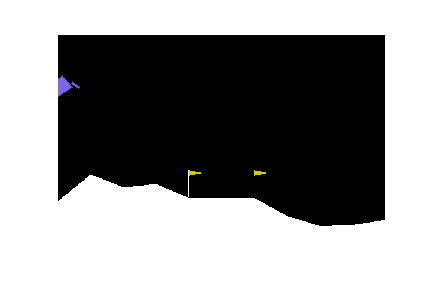
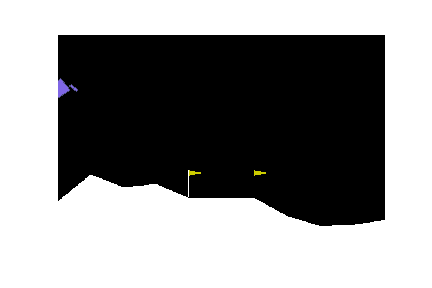


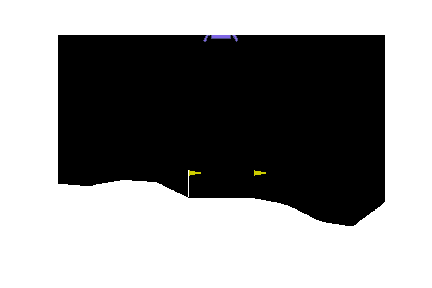
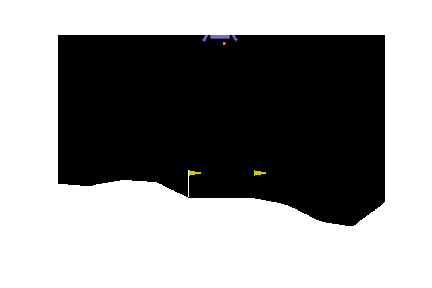
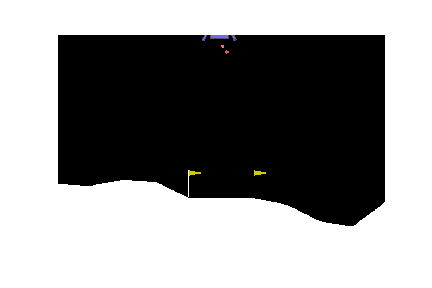
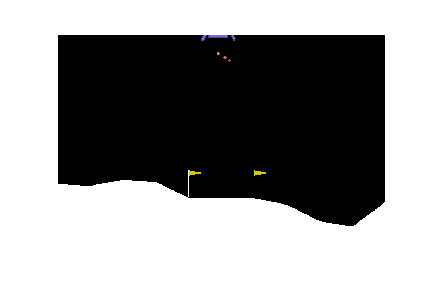
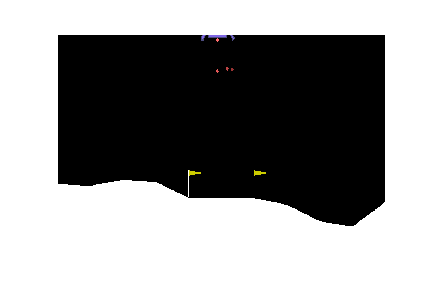
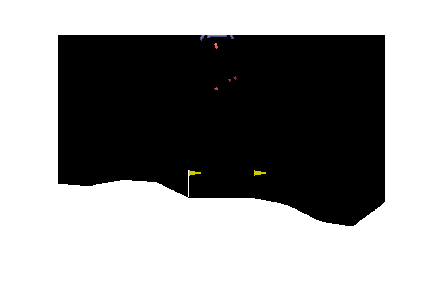
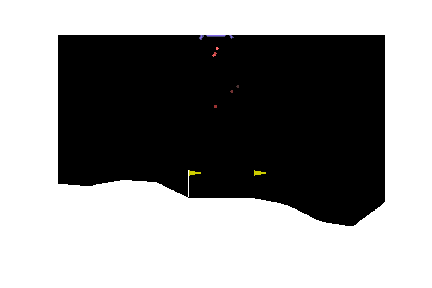
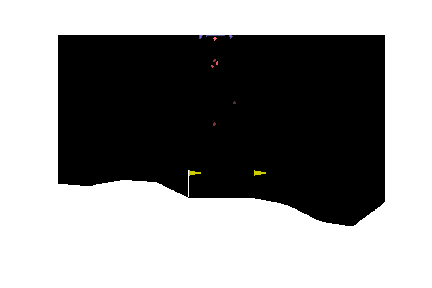
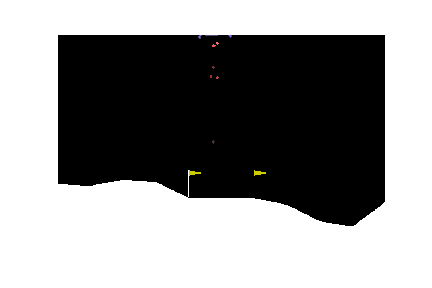
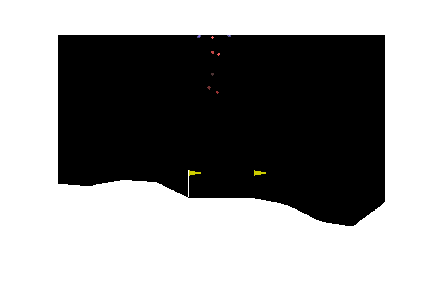
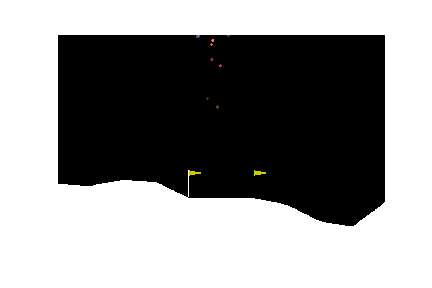
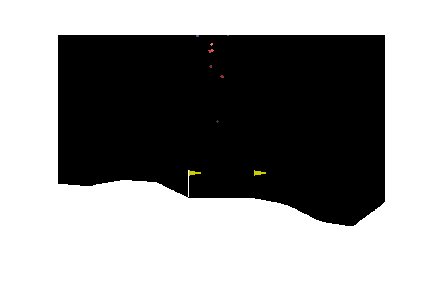
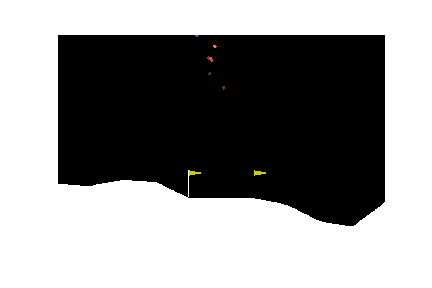
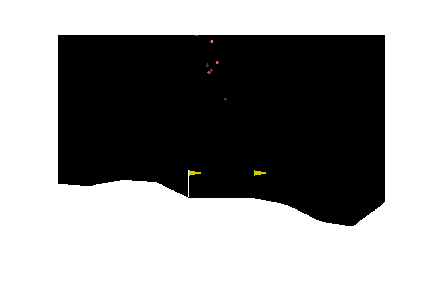
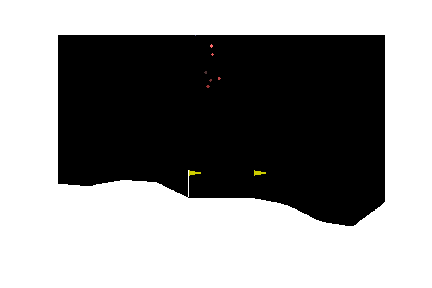
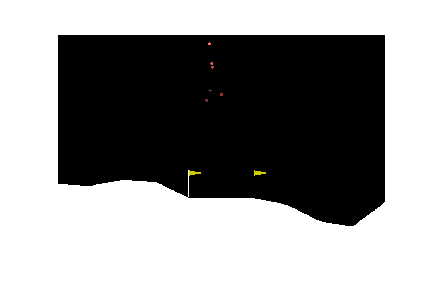
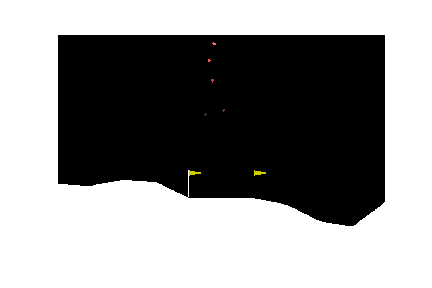
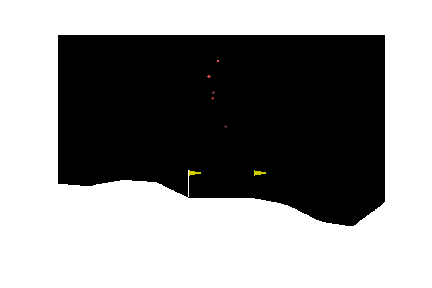
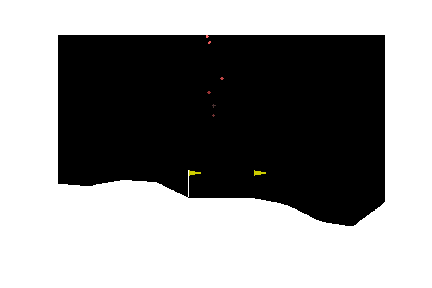
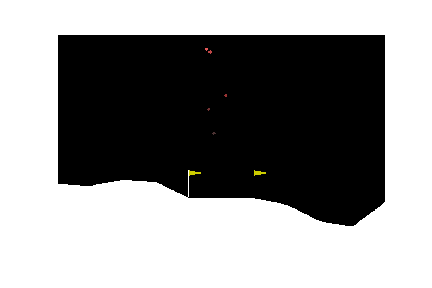
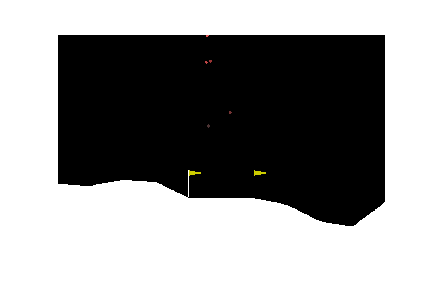
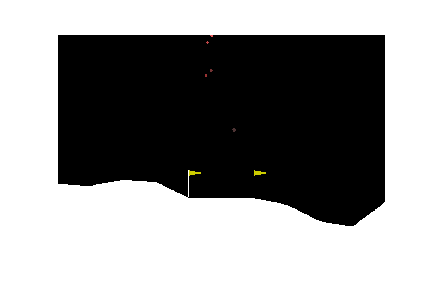
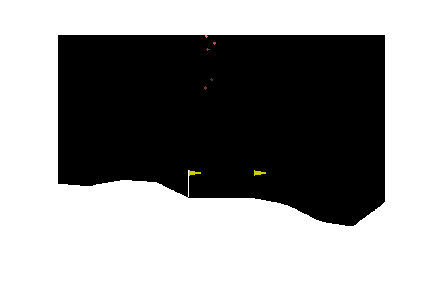
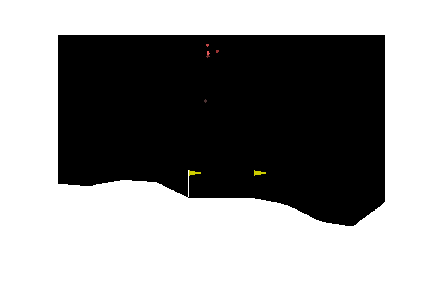
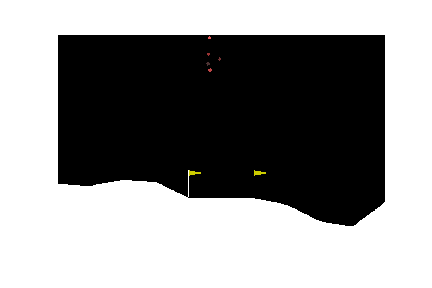
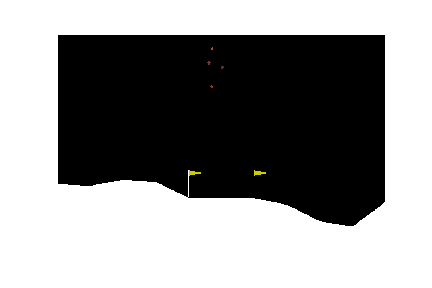
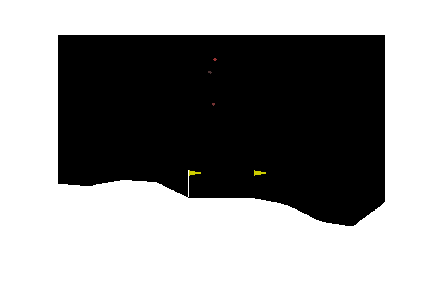
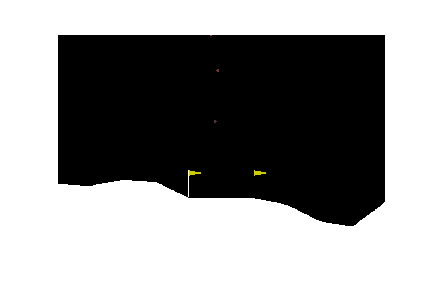
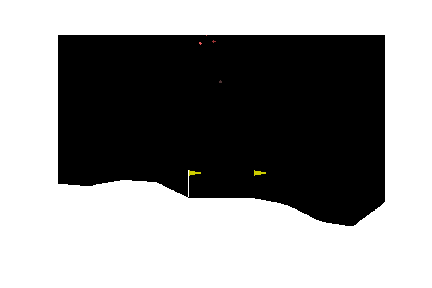
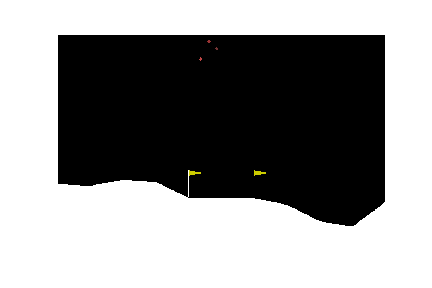
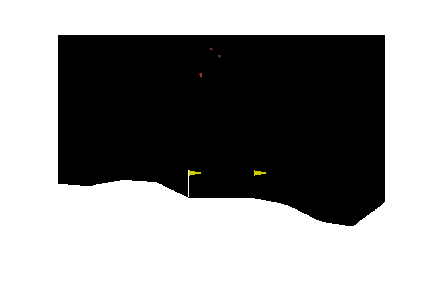
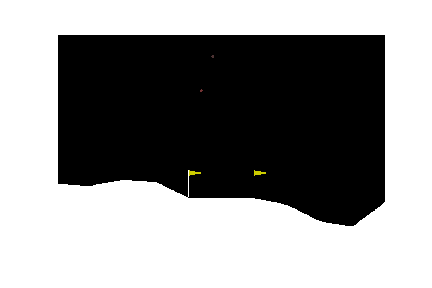
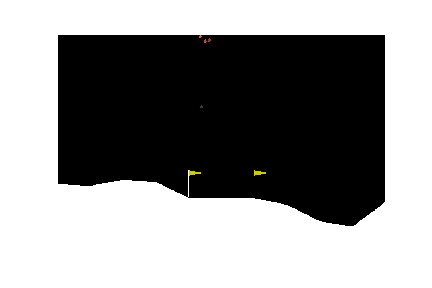
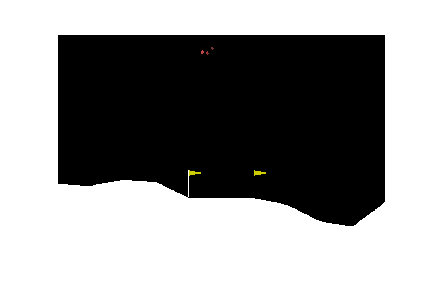
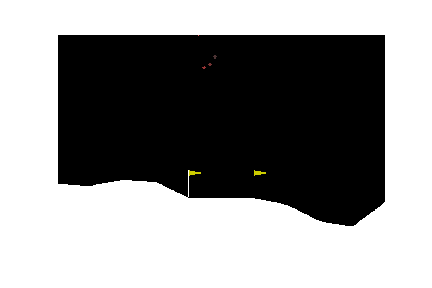
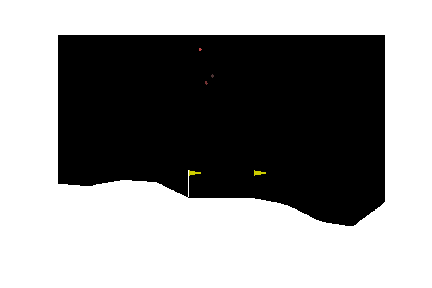
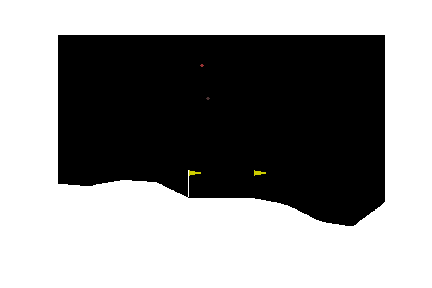
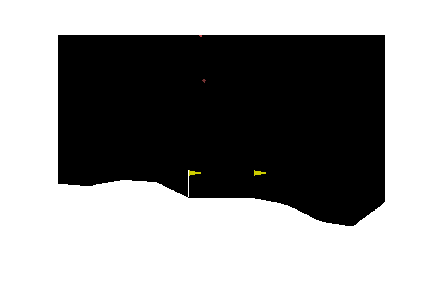
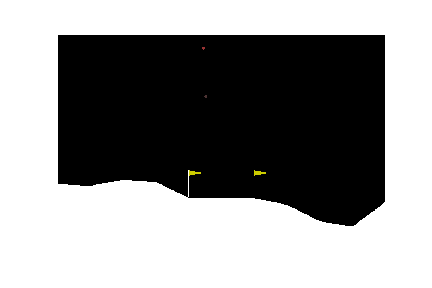
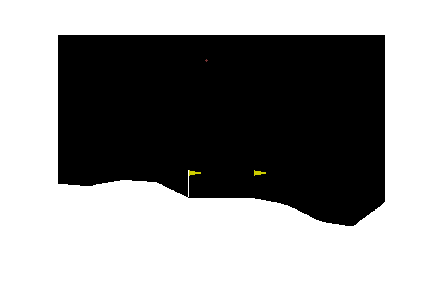
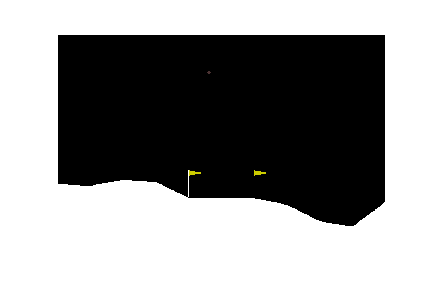
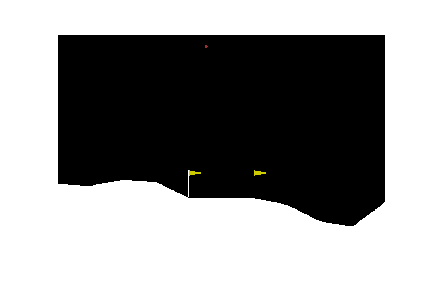
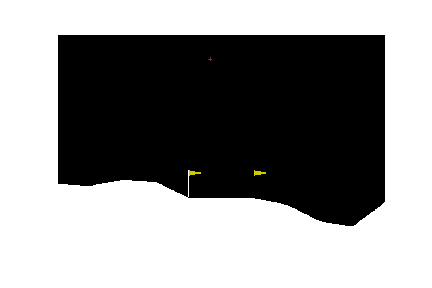
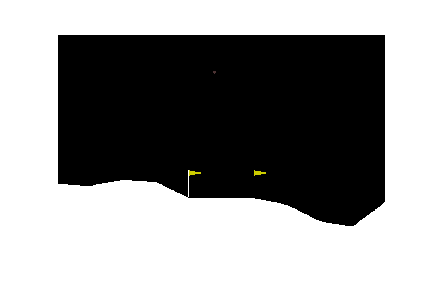
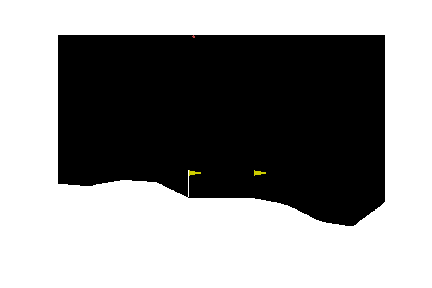
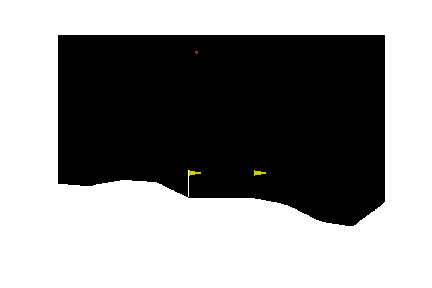
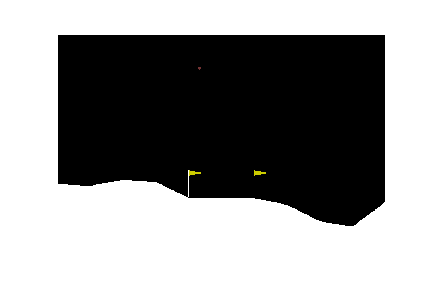
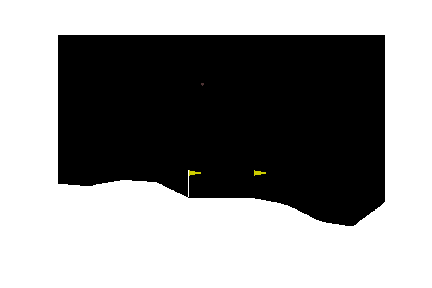
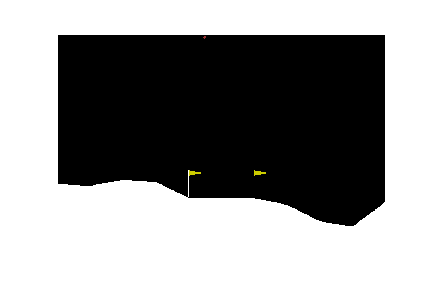
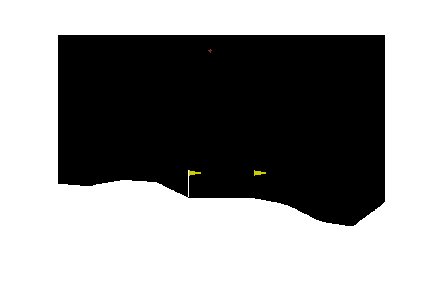
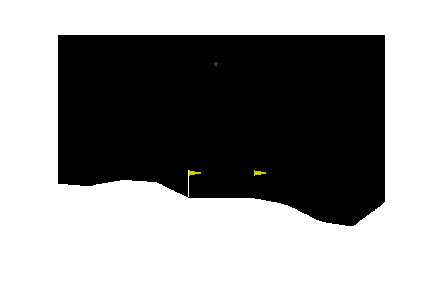
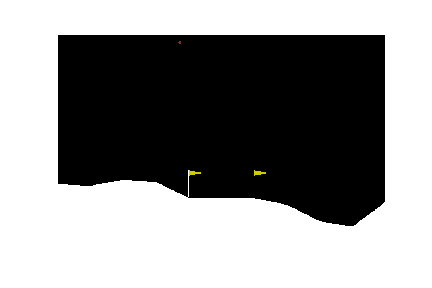
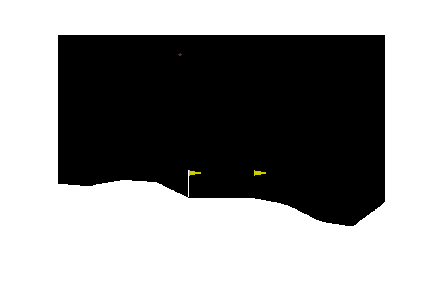
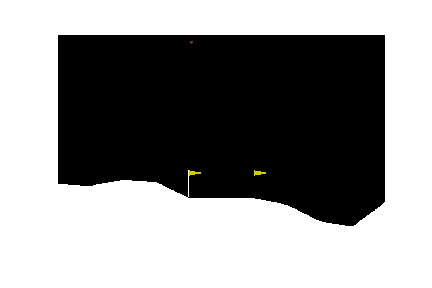
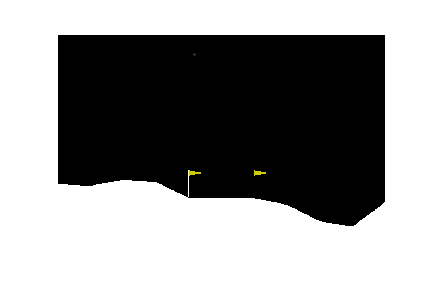
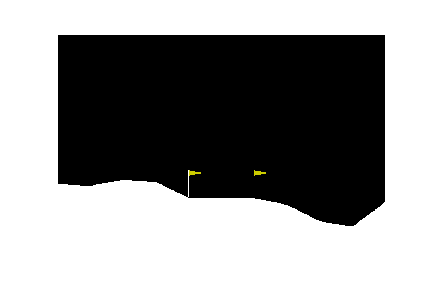
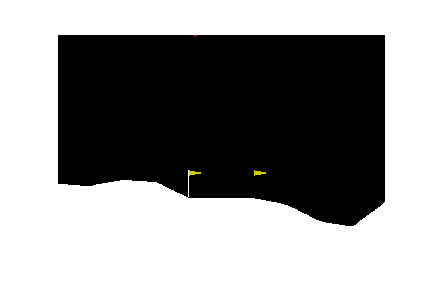
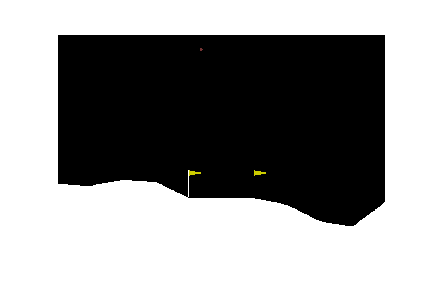
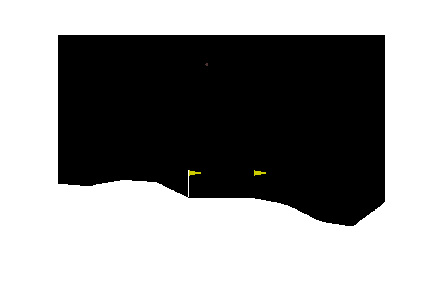
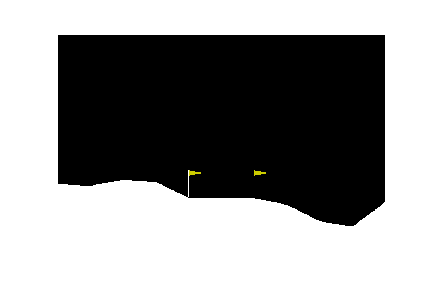
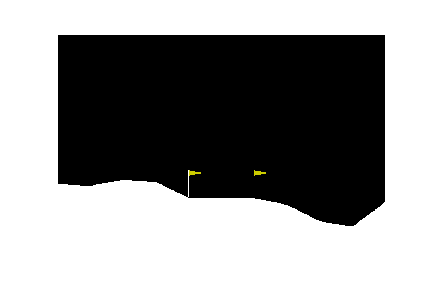
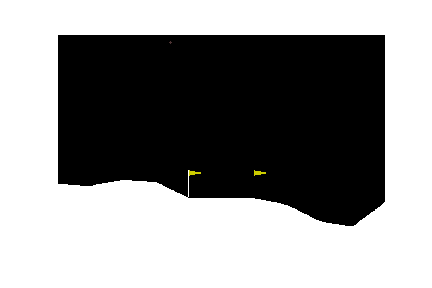
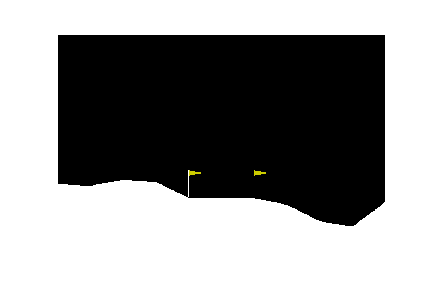
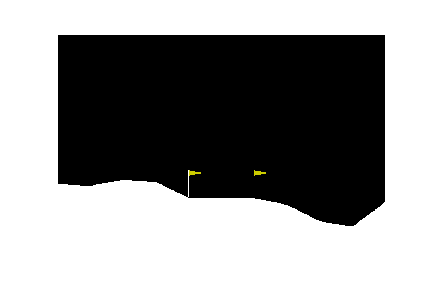
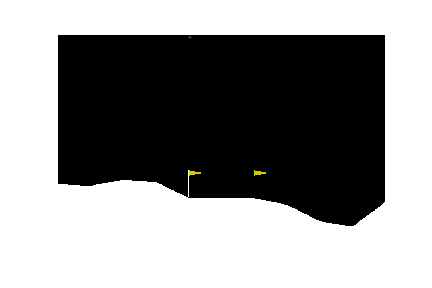
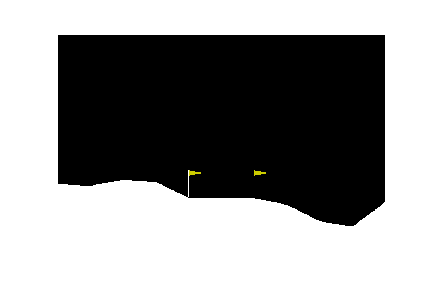
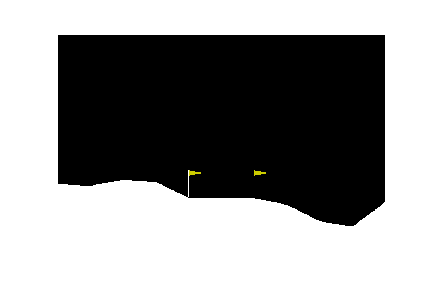
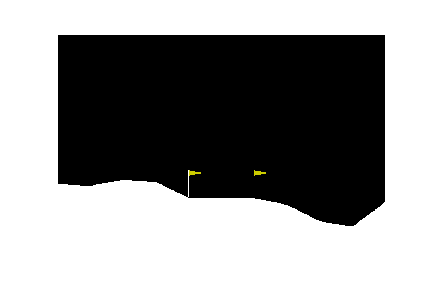
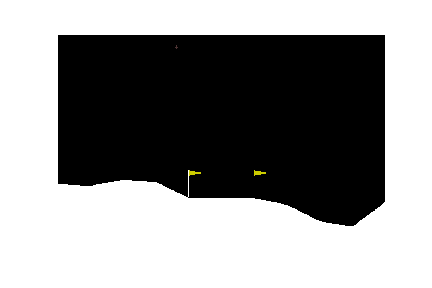
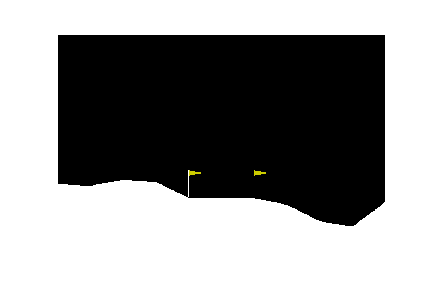
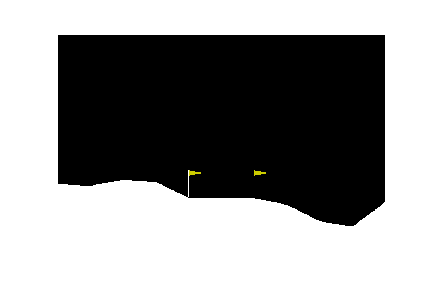
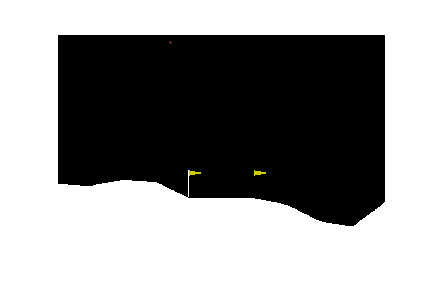
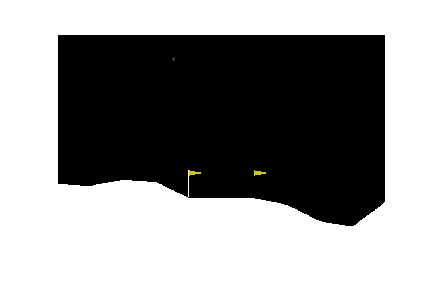
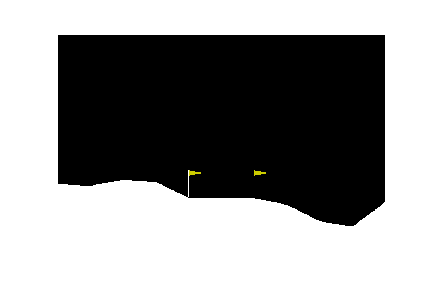
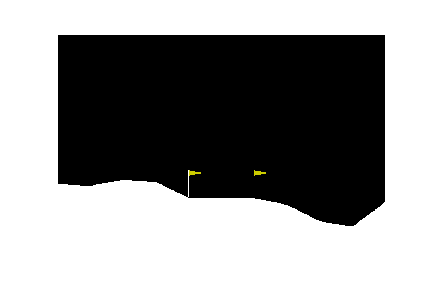
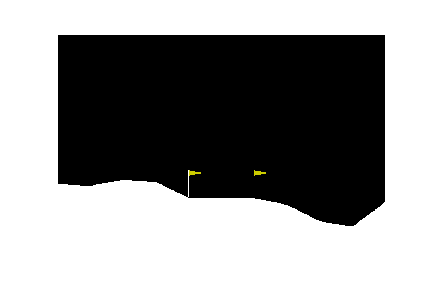
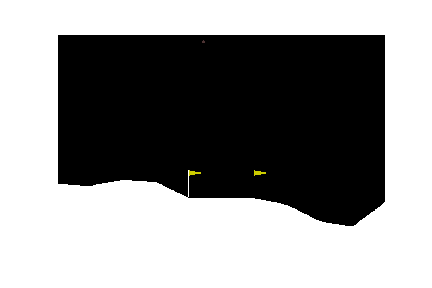
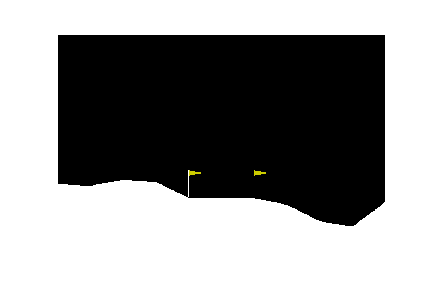
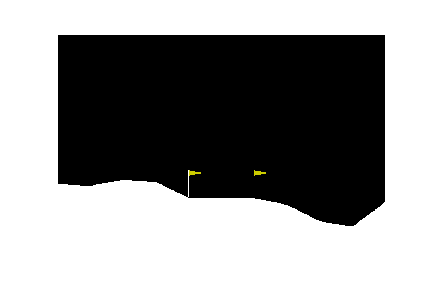
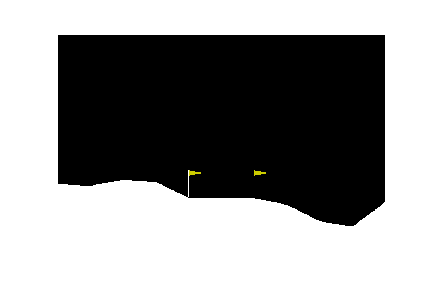
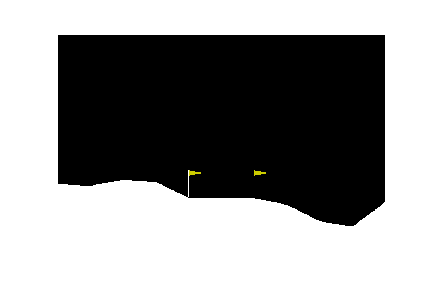
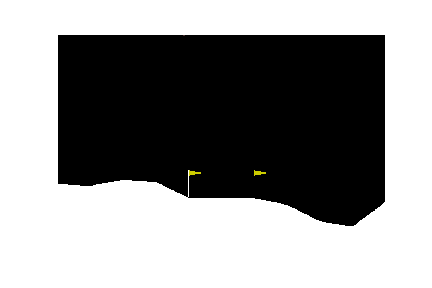
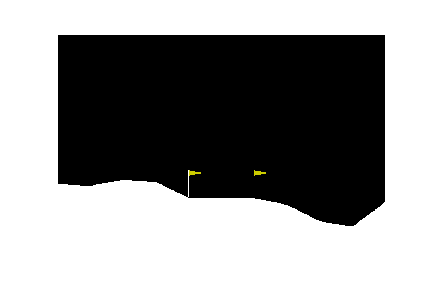
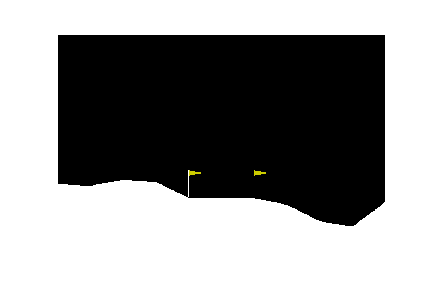
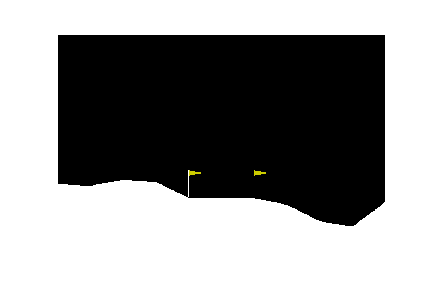
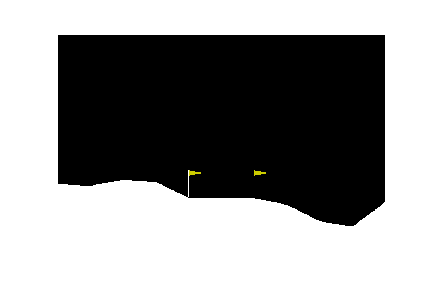
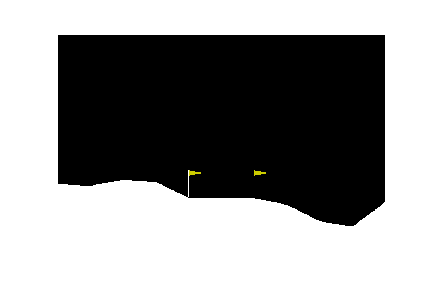
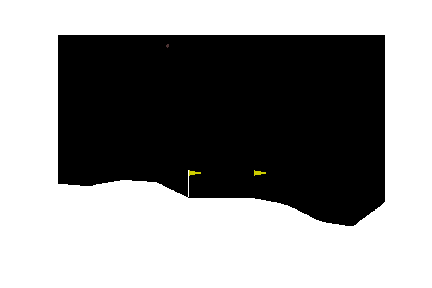
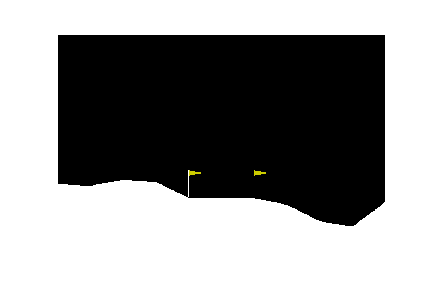
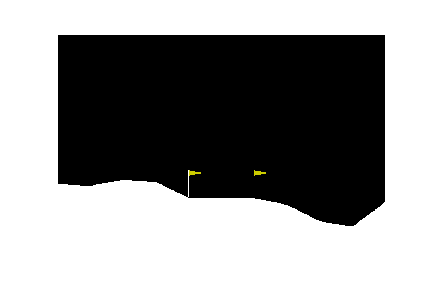
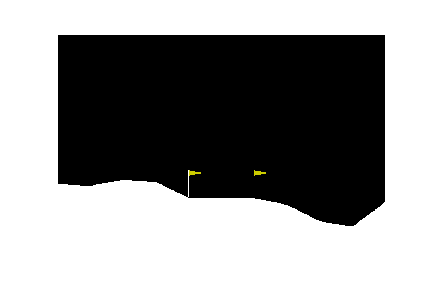
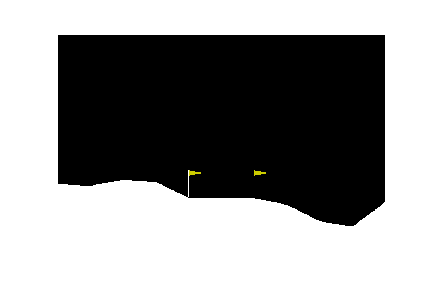
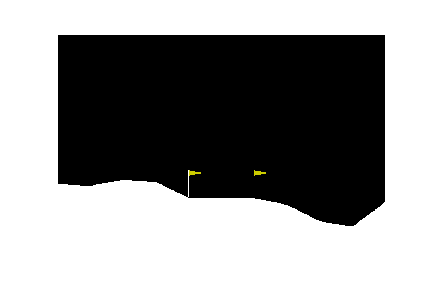
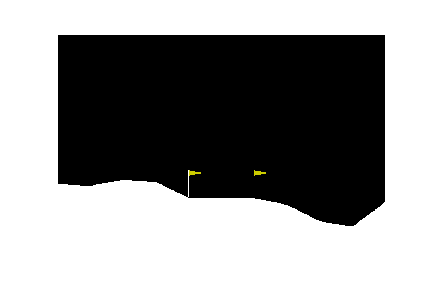
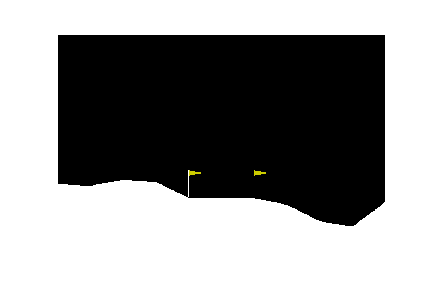
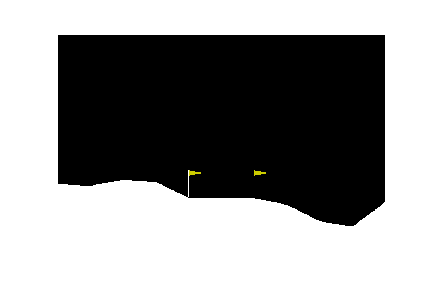
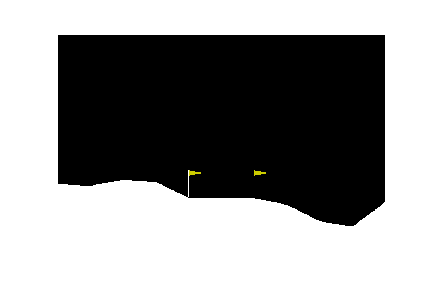
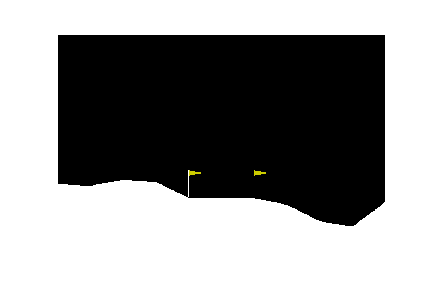
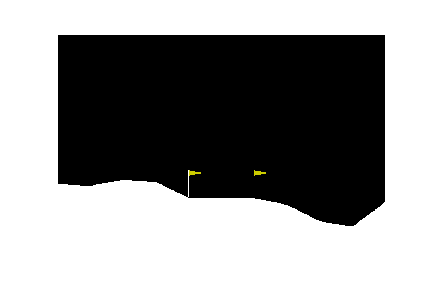
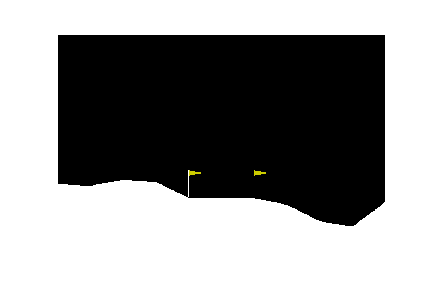
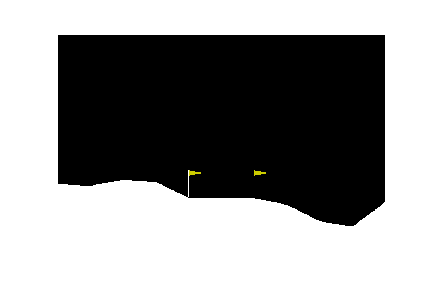
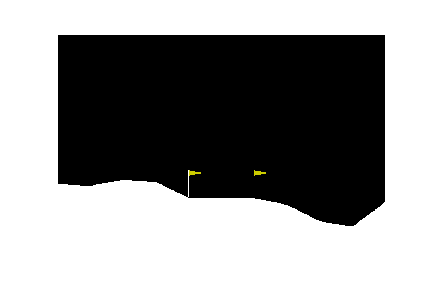
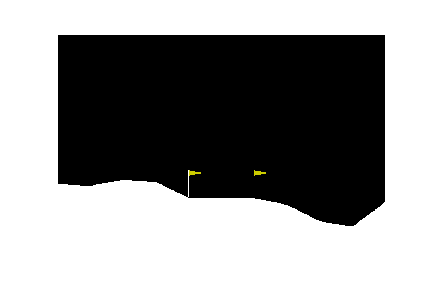
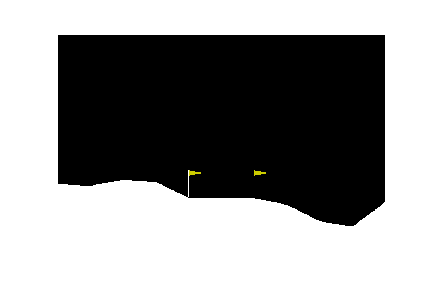
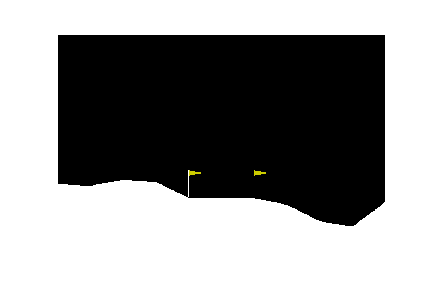
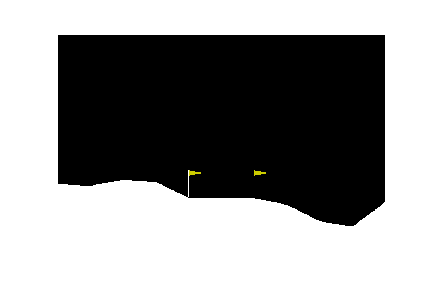
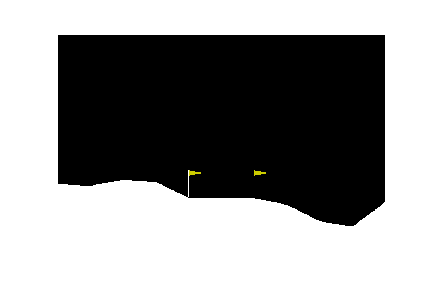
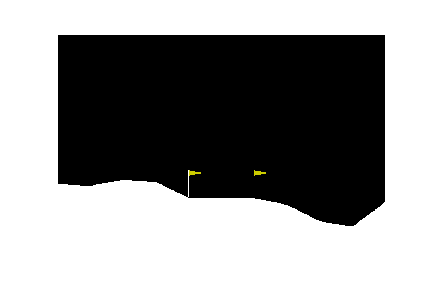
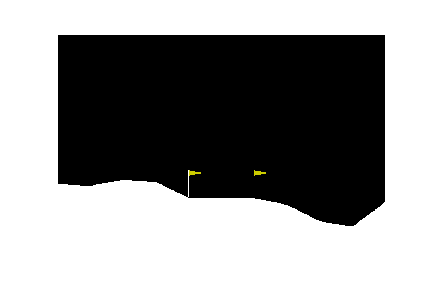
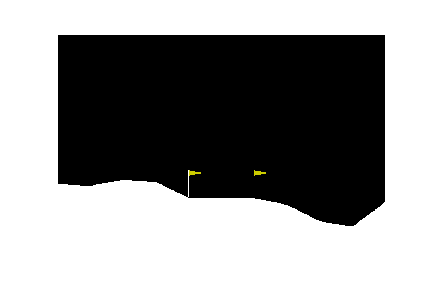
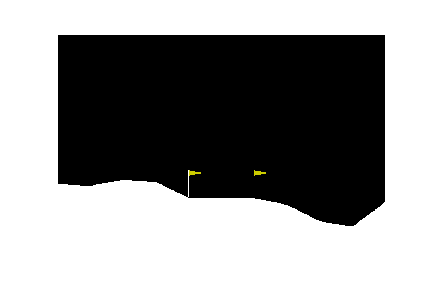
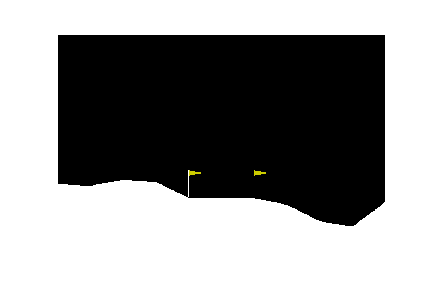
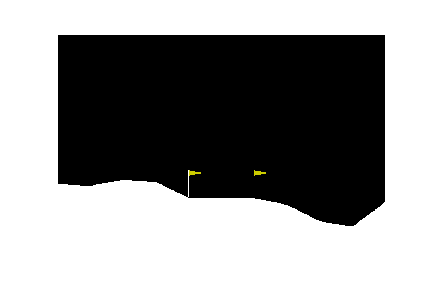
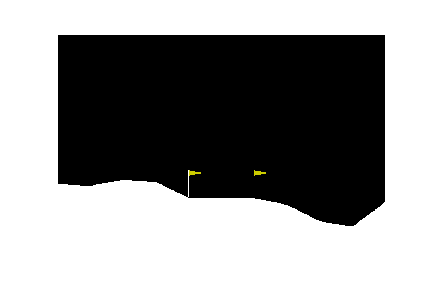
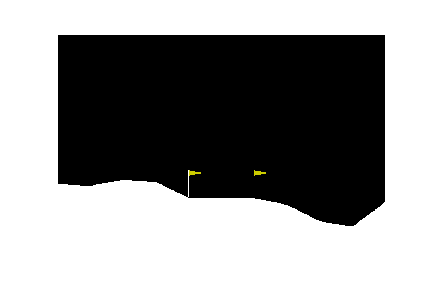
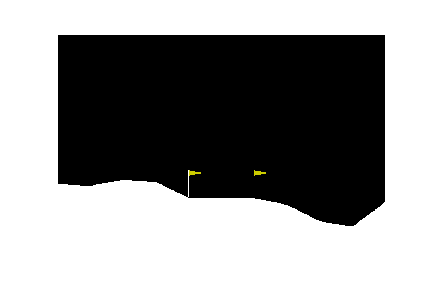
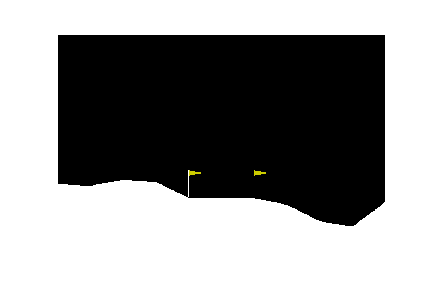


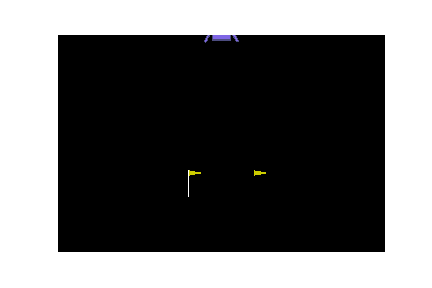
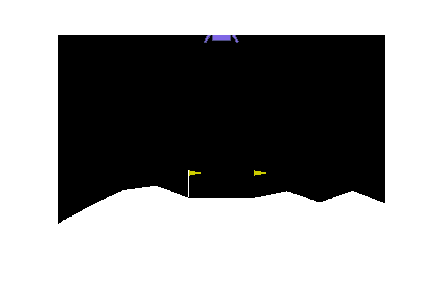
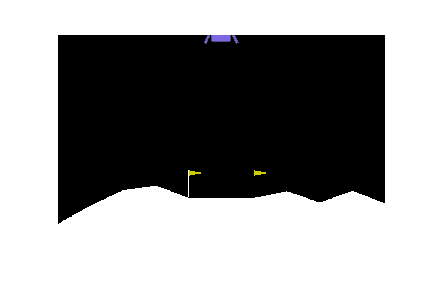
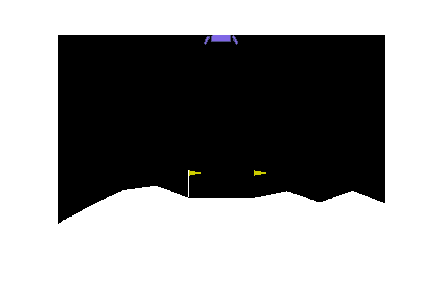
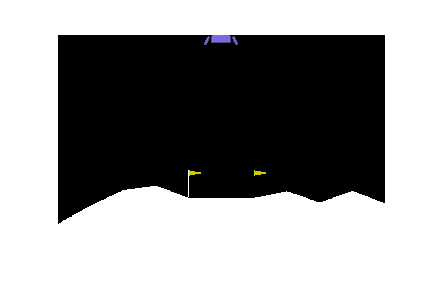
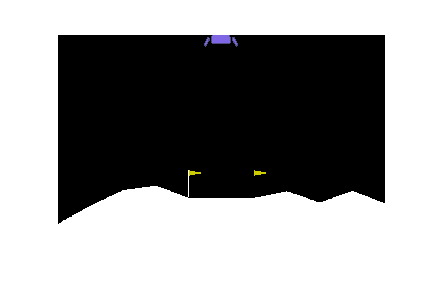
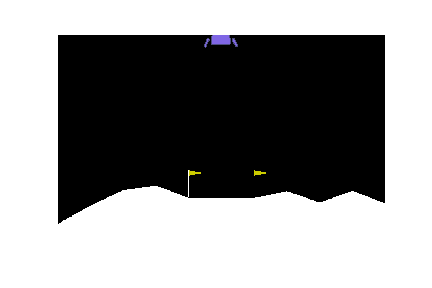
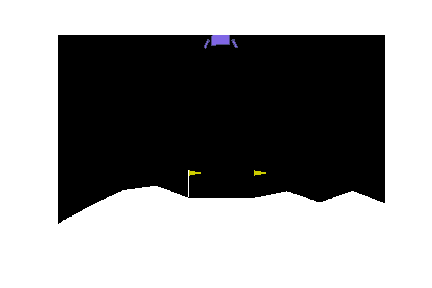
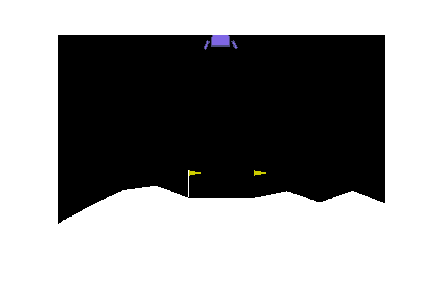
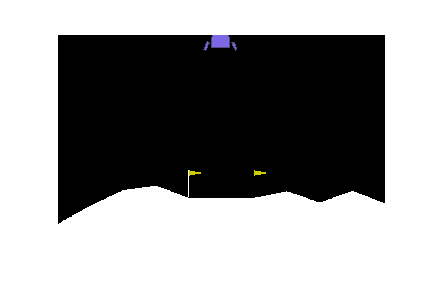
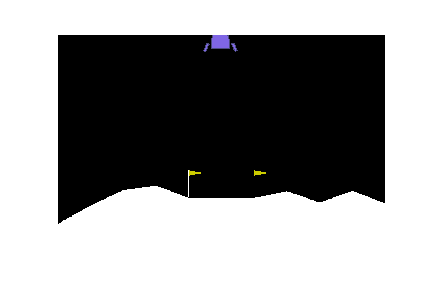
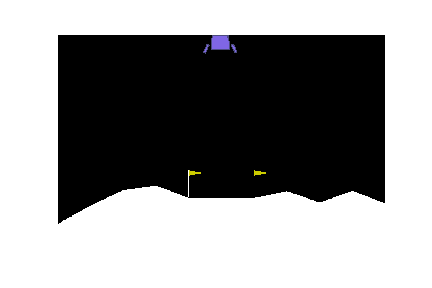
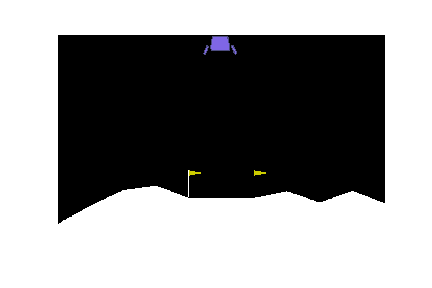
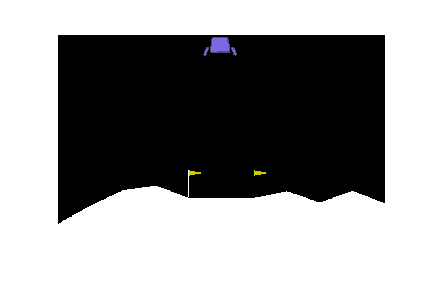
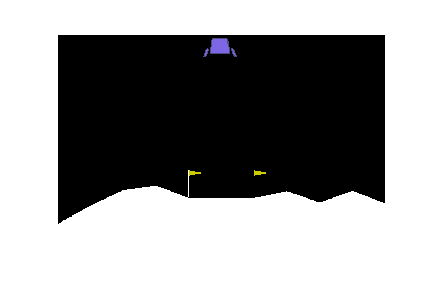
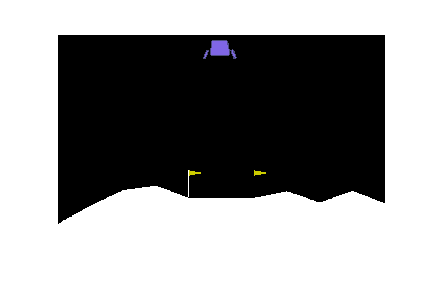
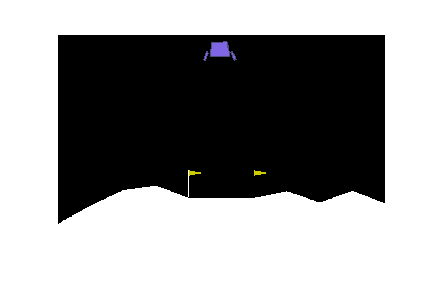
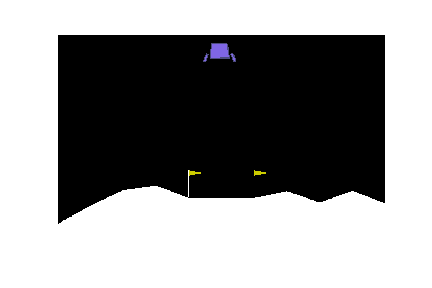
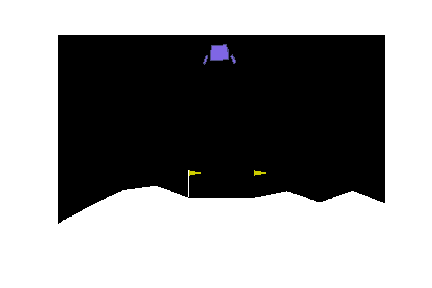
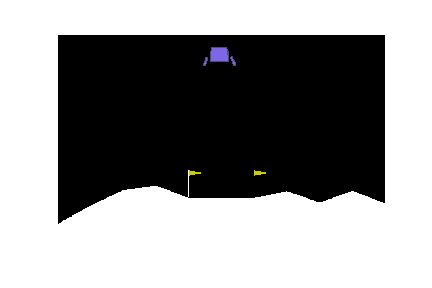
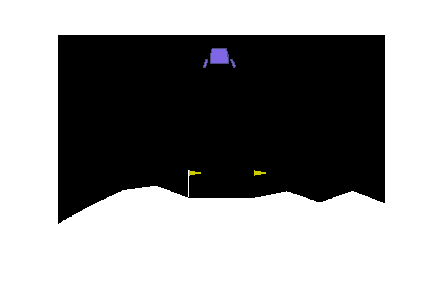
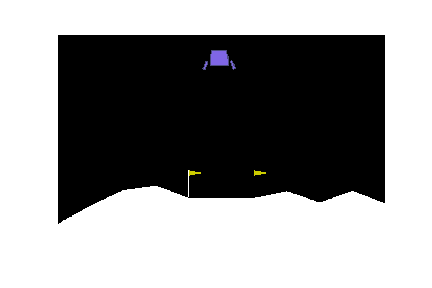
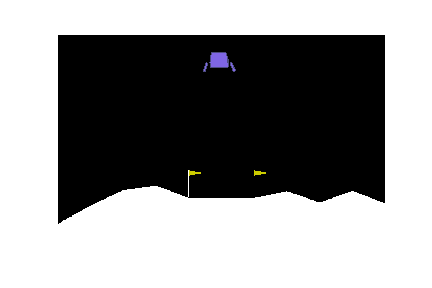
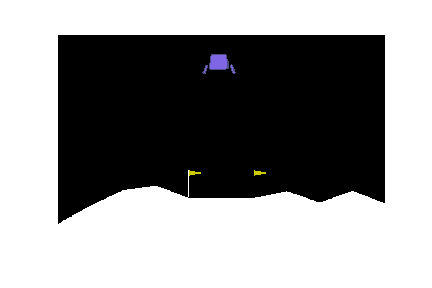
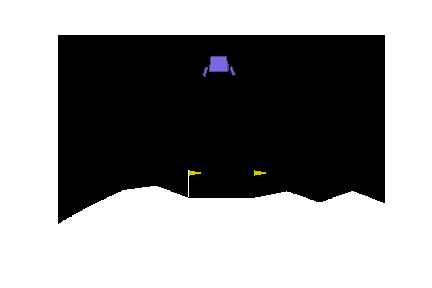
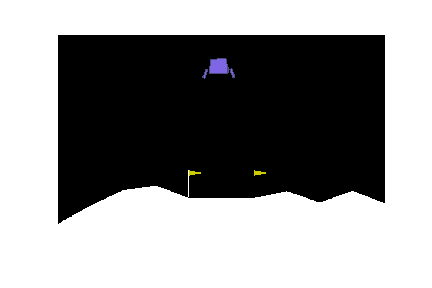
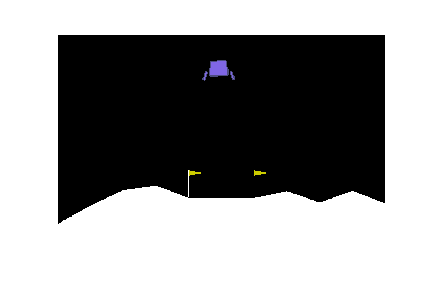
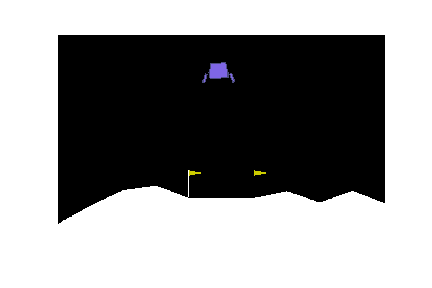
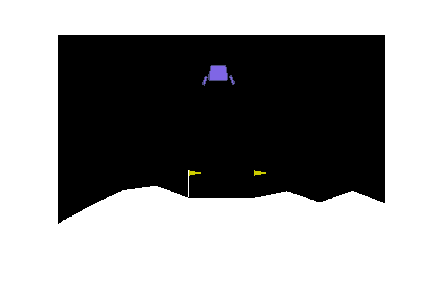
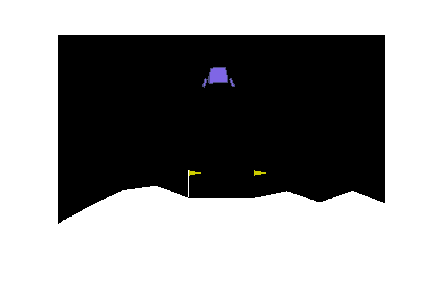
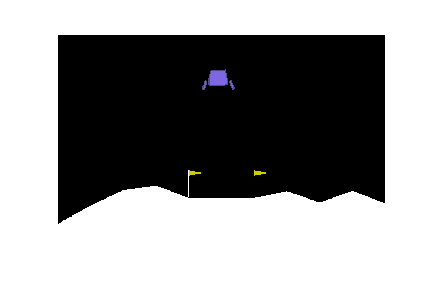
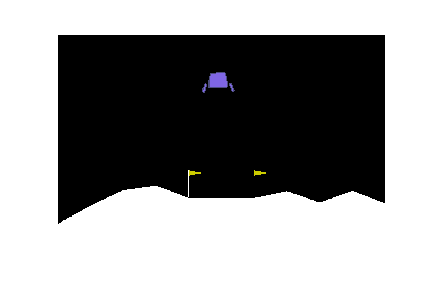
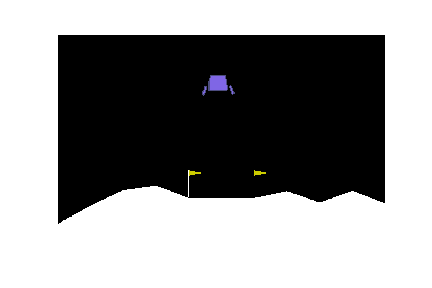
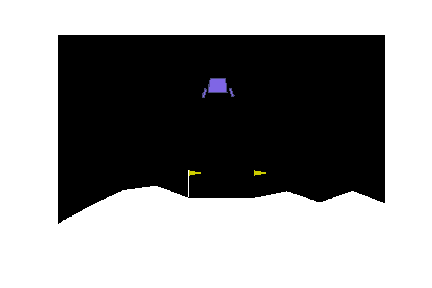
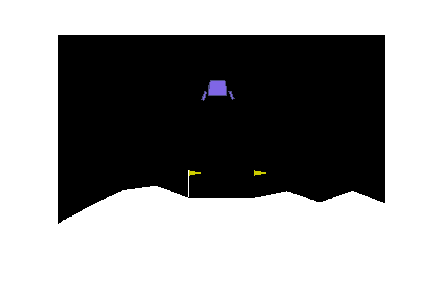
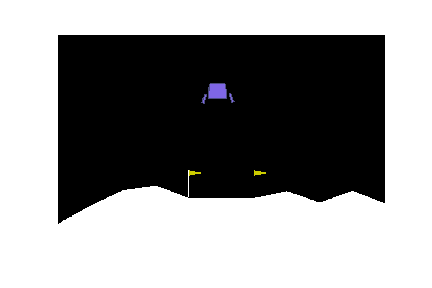
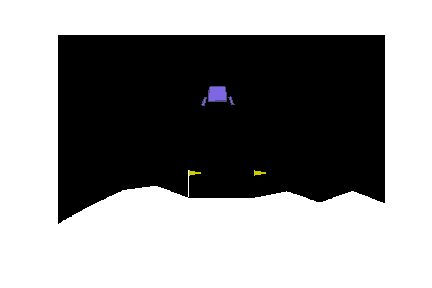
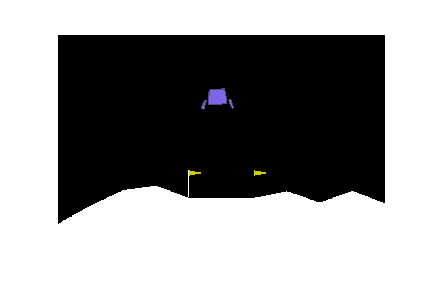
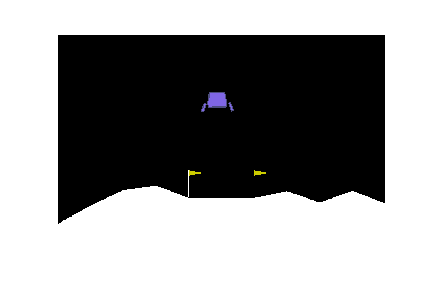
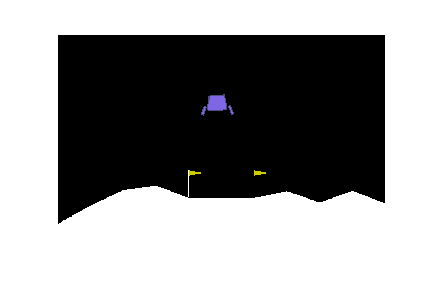
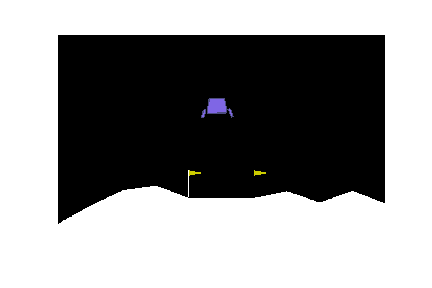
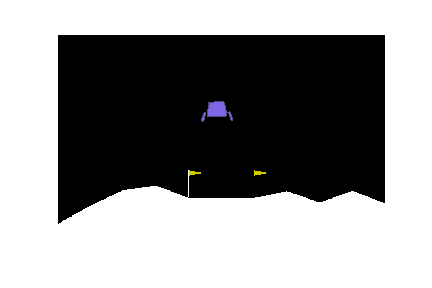
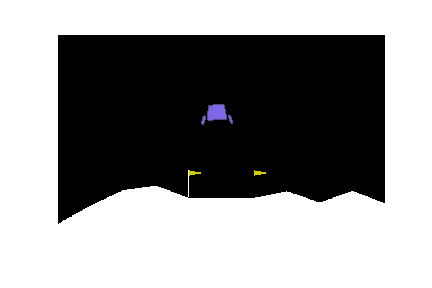
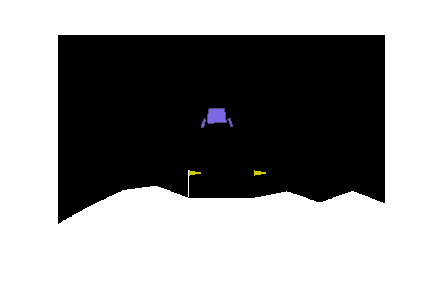
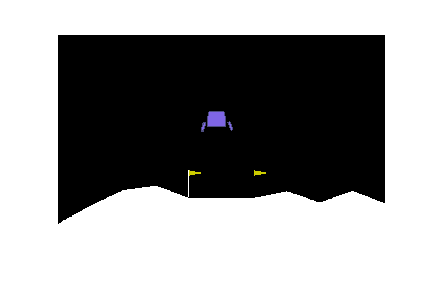
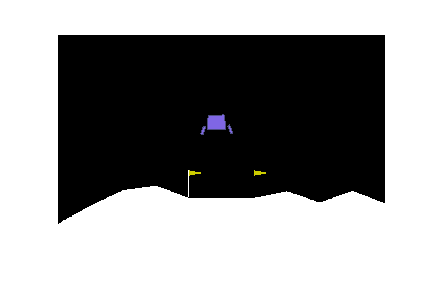
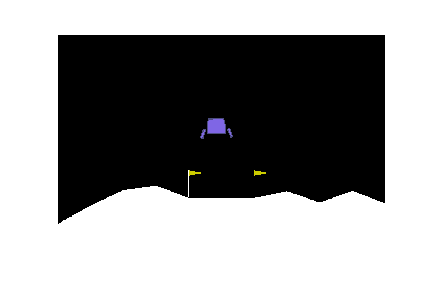
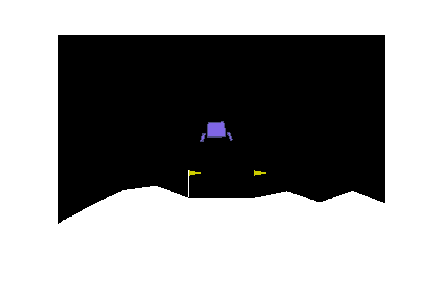
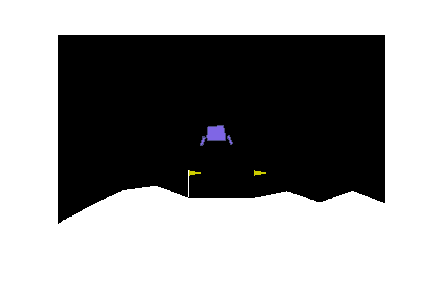
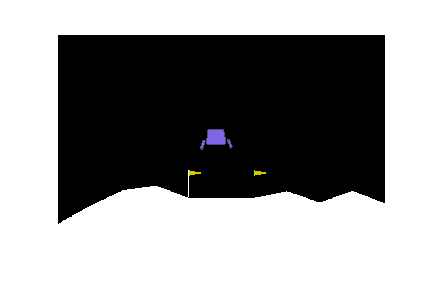
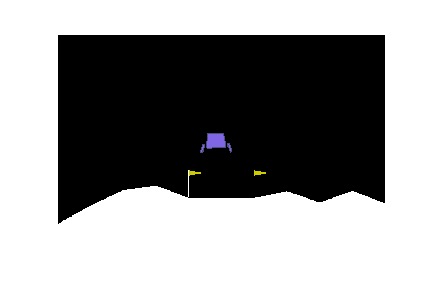
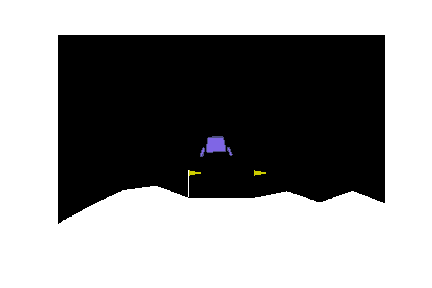
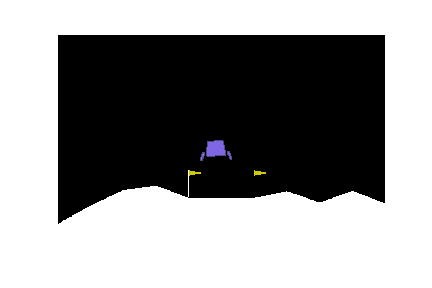
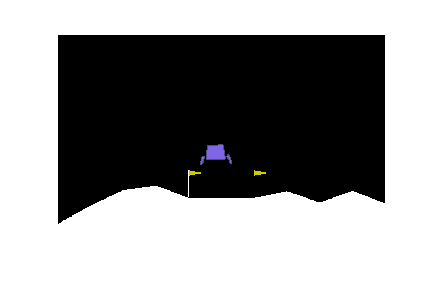
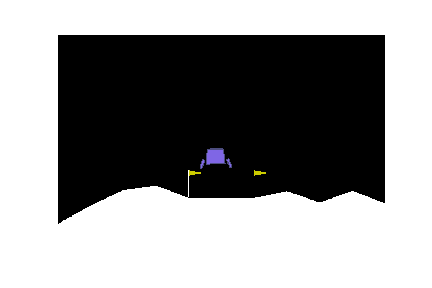
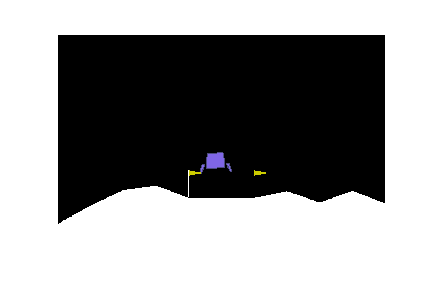
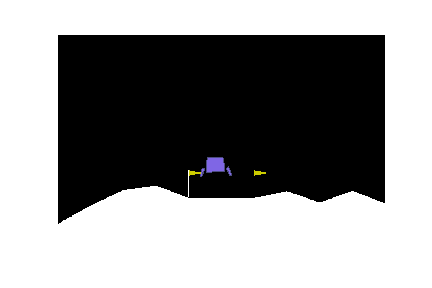
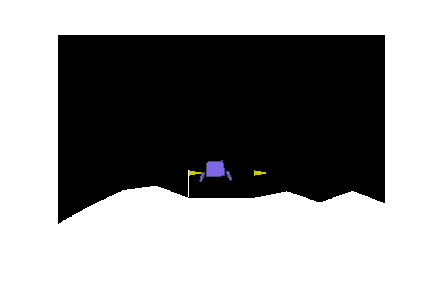
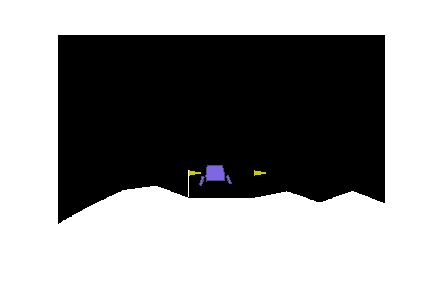
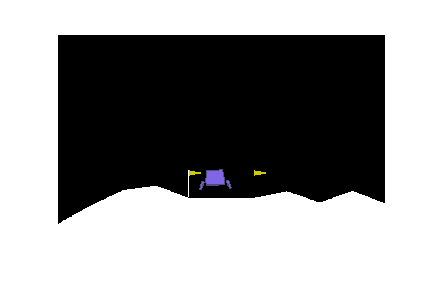
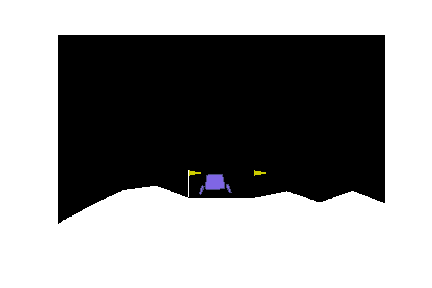
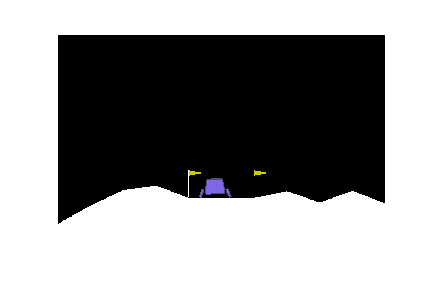

-119.72822956481093

In [9]:
pop = []
for i in range(100):
    pop.append(Net())

pop, fit = do_generation(pop)
print(fit)
episodeOnNet(pop[0])
episodeOnNet(pop[10])
episodeOnNet(pop[20])
episodeOnNet(pop[30])

In [10]:
bests = []

def evolution(gens, pop_size=100, survive=20, rand=40, mr=2e-1):
    pop = []
    for _ in range(pop_size):
        pop.append(Net())
    for g in range(gens):
        pop, fit = do_generation(pop, survive, rand, mr)
        if g%10==0:
            print("Generation", g, "has fitness:", fit, "mr:", mr)
            mr*=0.95
            bests.append(pop[0])
    return pop

In [11]:
import pickle

pop = evolution(1001, pop_size=100, survive=10, rand=40, mr=2e-1)

with open('bests_ga.pkl', 'wb') as output:
    pickle.dump(bests, output, pickle.HIGHEST_PROTOCOL)

Generation 0 has fitness: -83.15681391232694 mr: 0.2
Generation 10 has fitness: -49.264344920930895 mr: 0.19
Generation 20 has fitness: -34.455607066479025 mr: 0.1805
Generation 30 has fitness: 16.10468812614233 mr: 0.171475
Generation 40 has fitness: 61.26959669252737 mr: 0.16290124999999997
Generation 50 has fitness: 77.94959779854516 mr: 0.15475618749999998
Generation 60 has fitness: 136.7840977459099 mr: 0.14701837812499996
Generation 70 has fitness: 158.08786349041523 mr: 0.13966745921874996
Generation 80 has fitness: 274.8589696359555 mr: 0.13268408625781244
Generation 90 has fitness: 262.32586121411737 mr: 0.1260498819449218
Generation 100 has fitness: 264.0849505373834 mr: 0.11974738784767572
Generation 110 has fitness: 272.59007027770366 mr: 0.11376001845529193
Generation 120 has fitness: 283.2606552873589 mr: 0.10807201753252733
Generation 130 has fitness: 284.6257904808237 mr: 0.10266841665590096
Generation 140 has fitness: 282.49279436498637 mr: 0.0975349958231059
Generatio


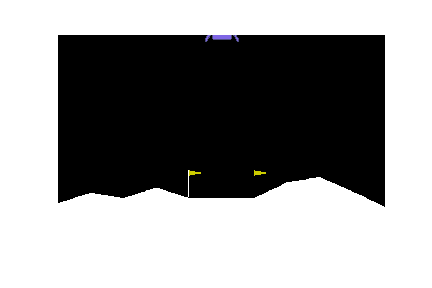
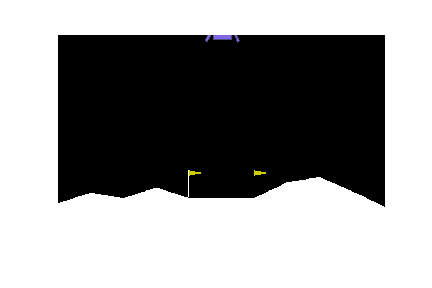
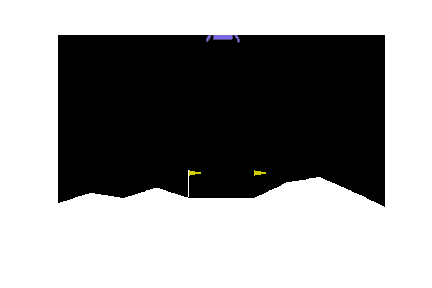
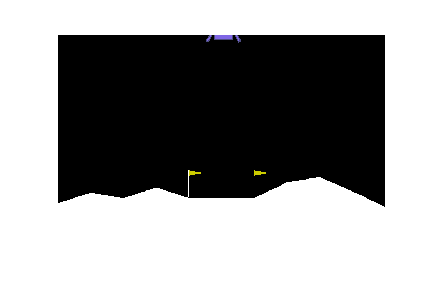
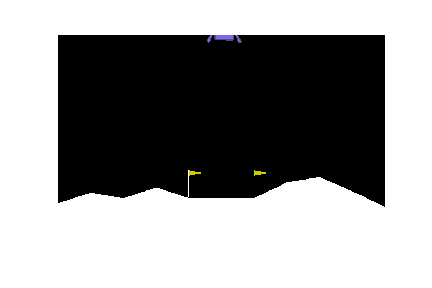
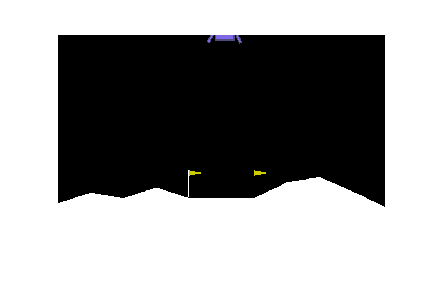
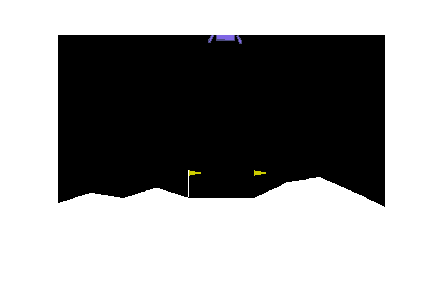
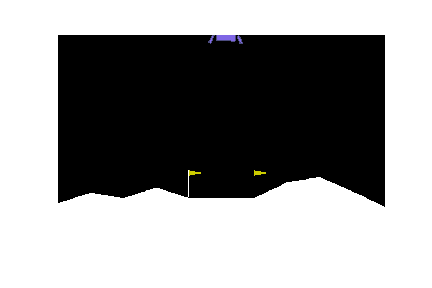
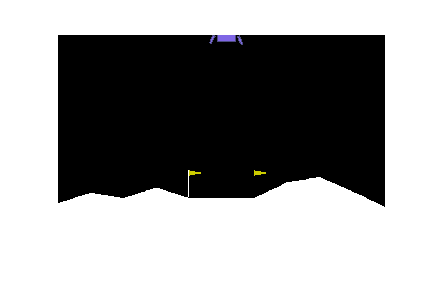
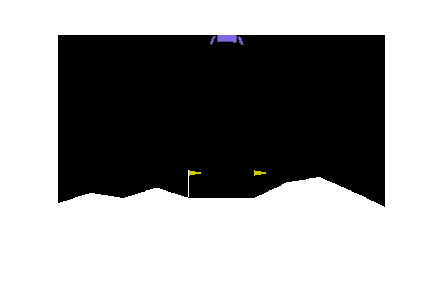
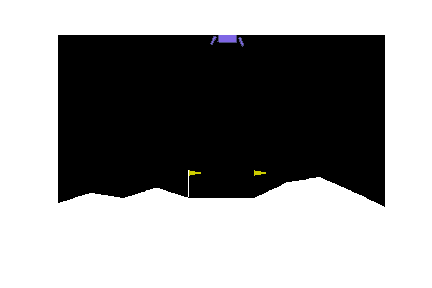
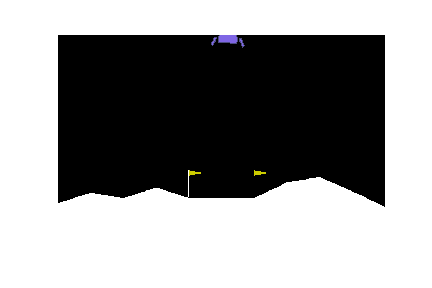
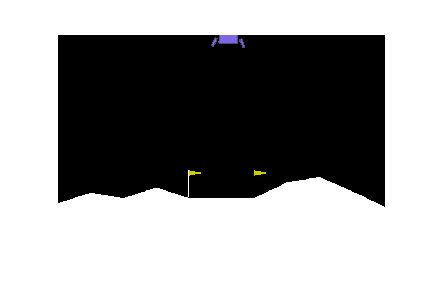
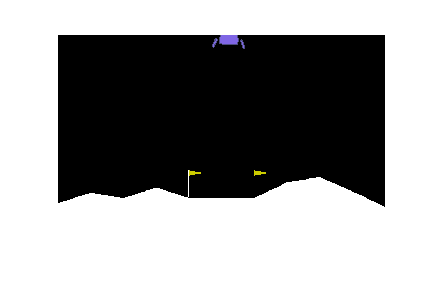
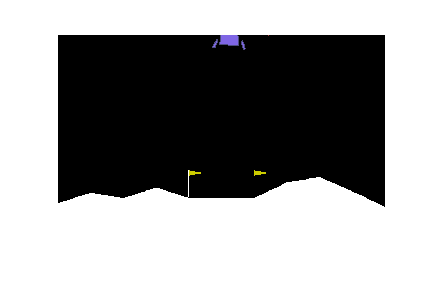
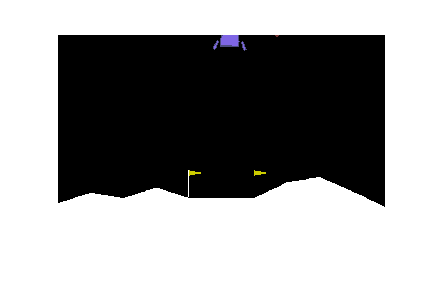
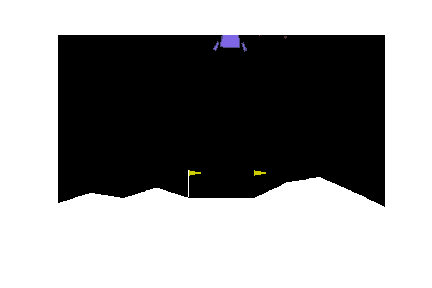
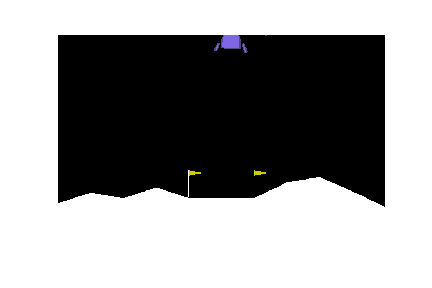
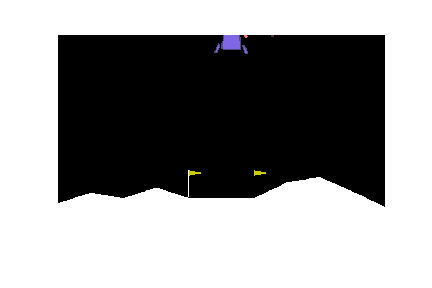
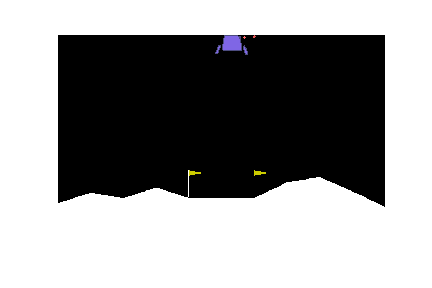
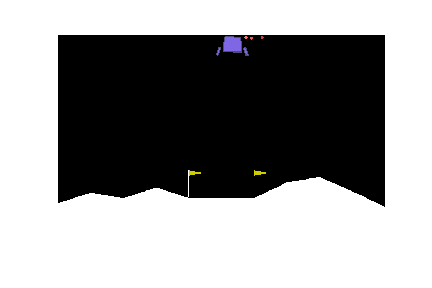
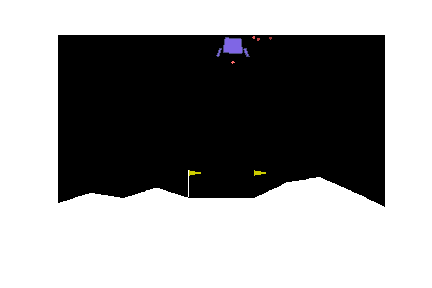
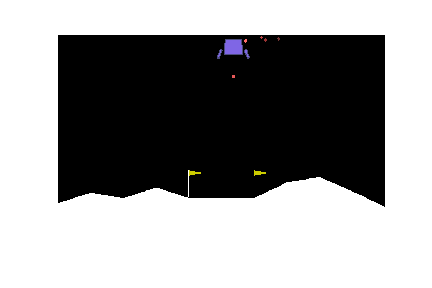
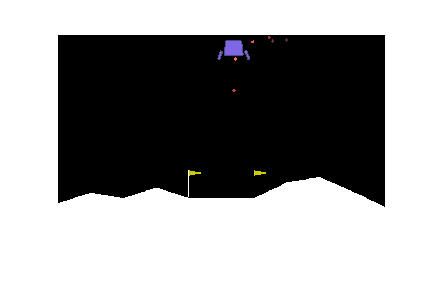
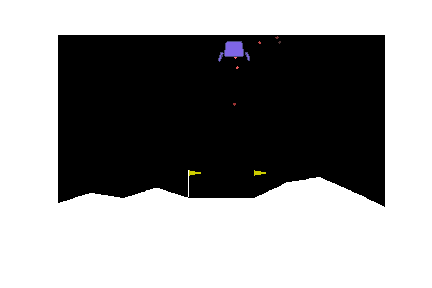
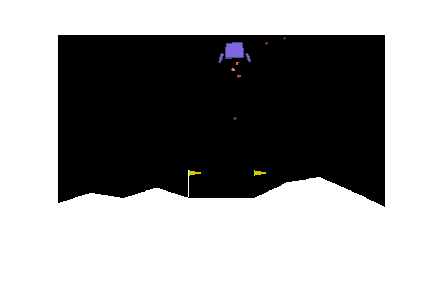
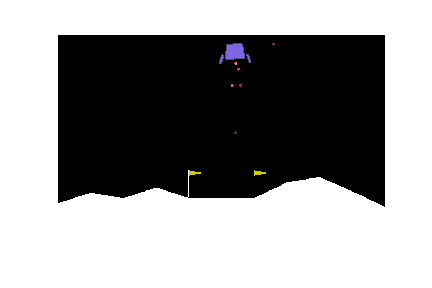
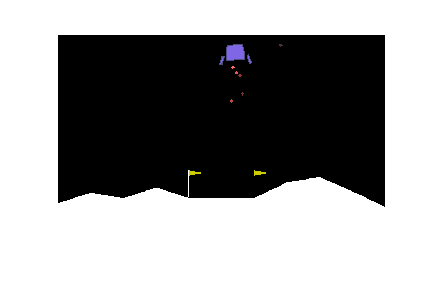
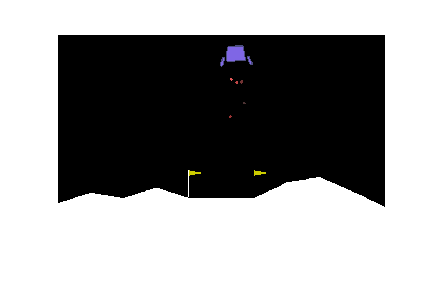
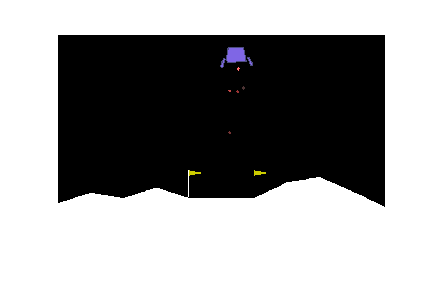
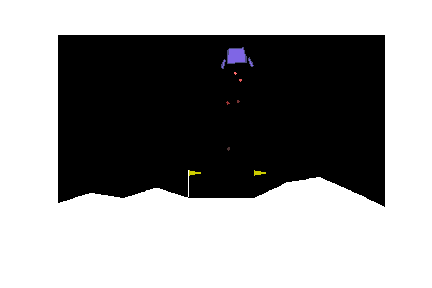
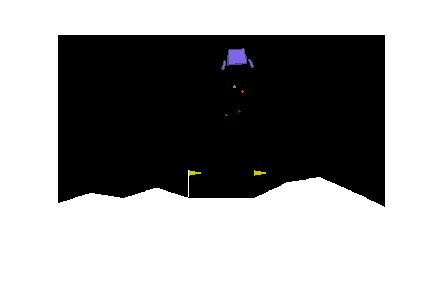
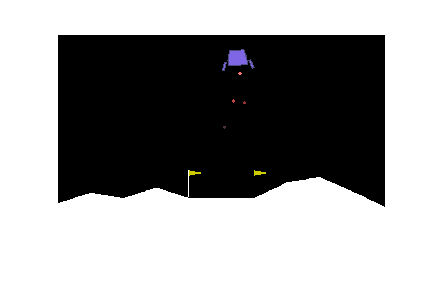
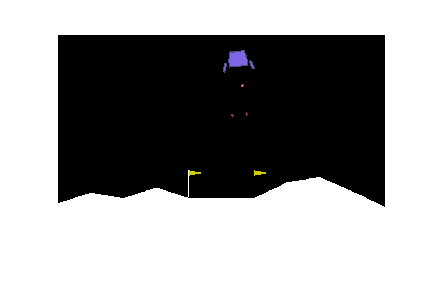
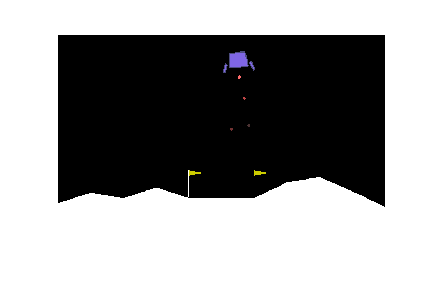
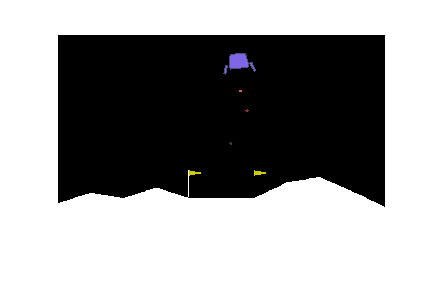
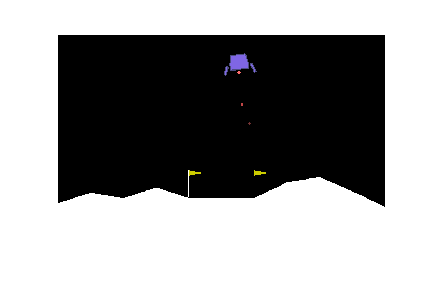
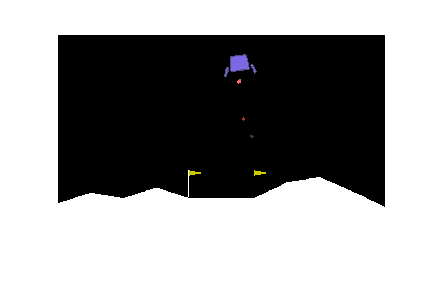
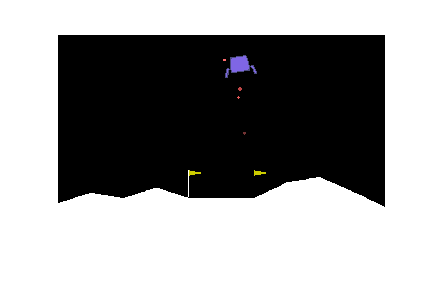
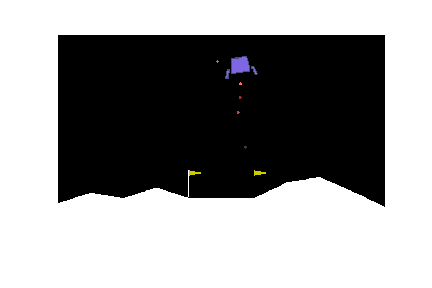
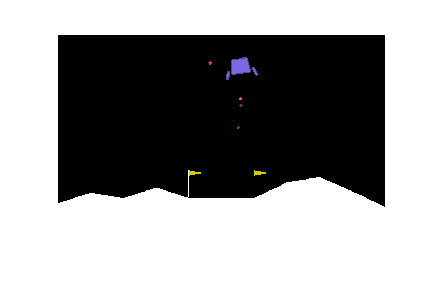
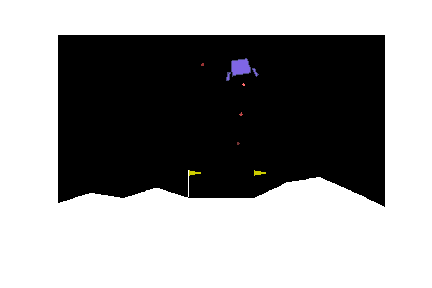
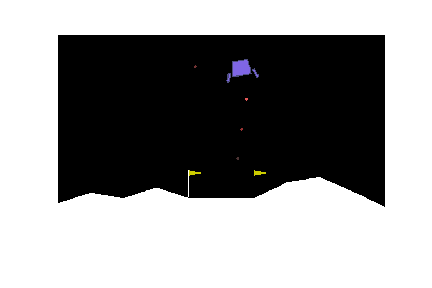
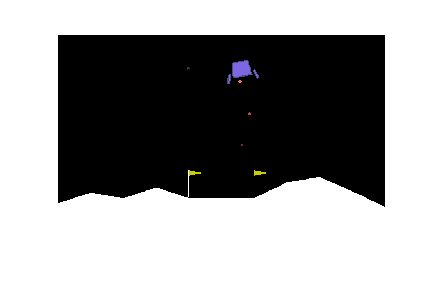
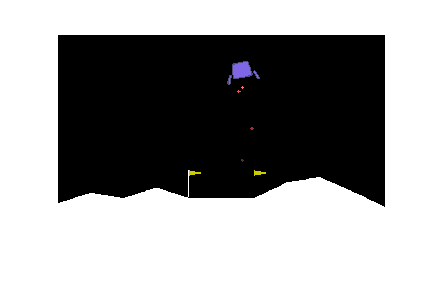
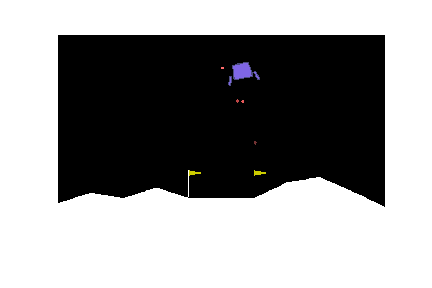
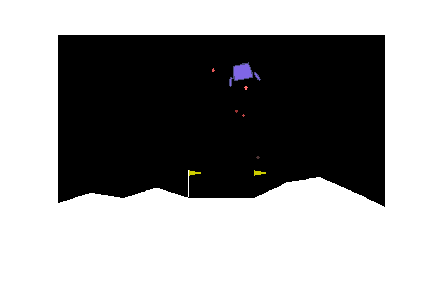
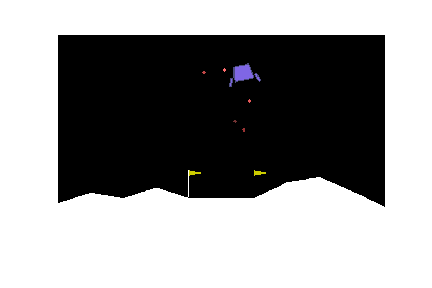
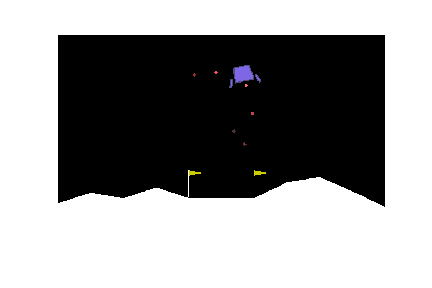
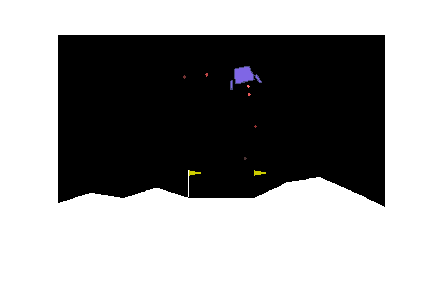
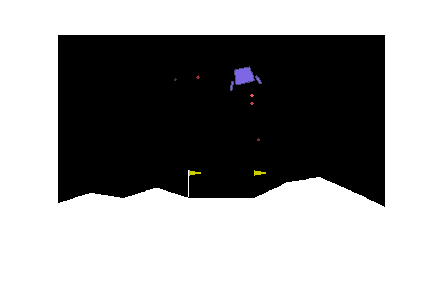
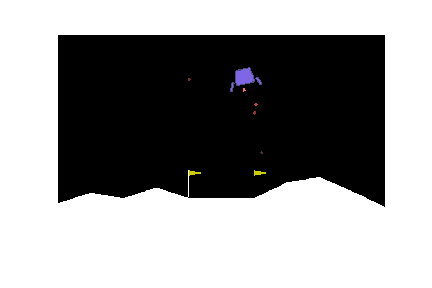
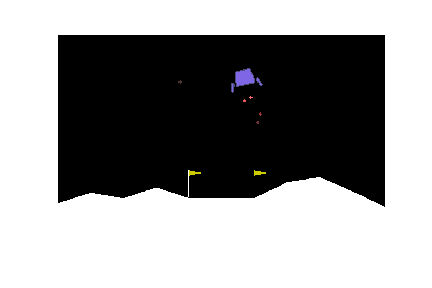
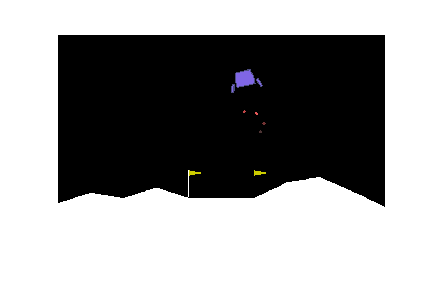
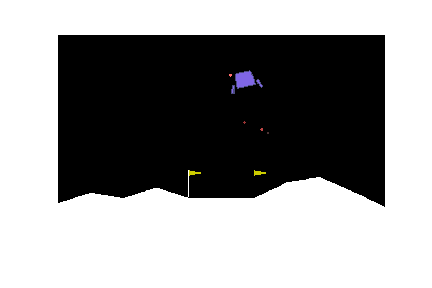
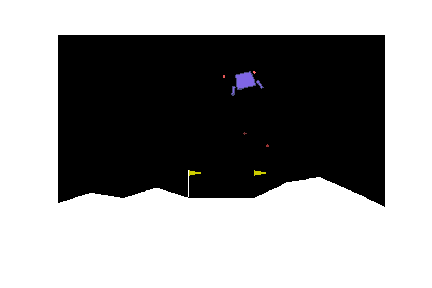
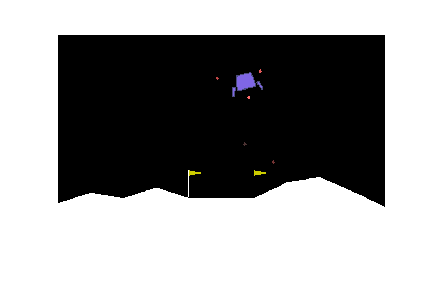
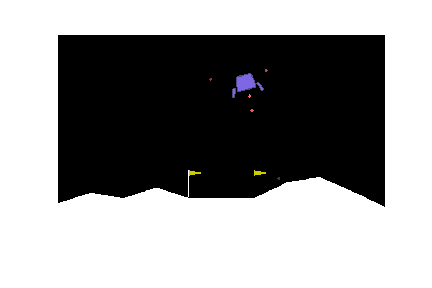
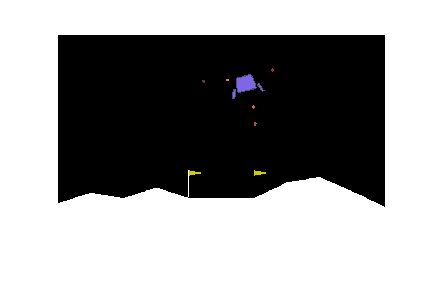
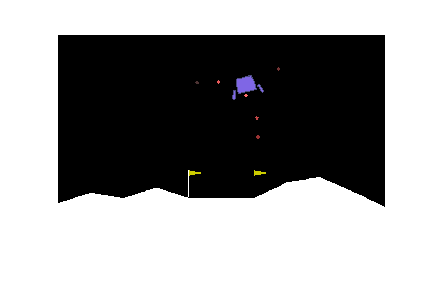
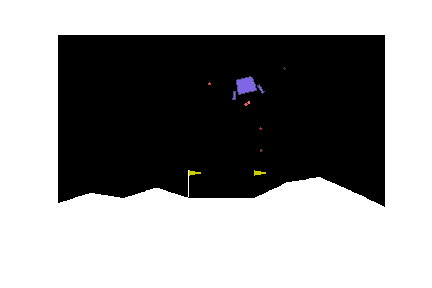
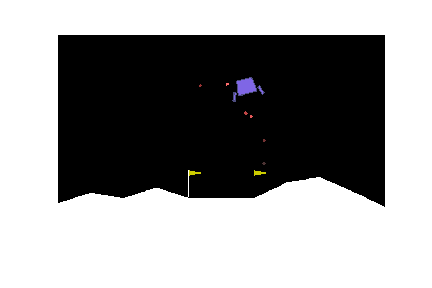
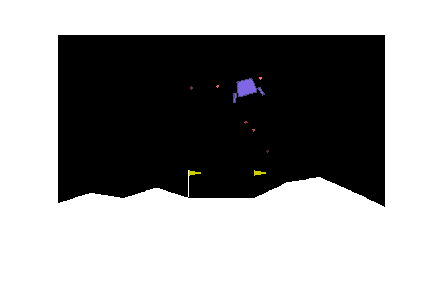
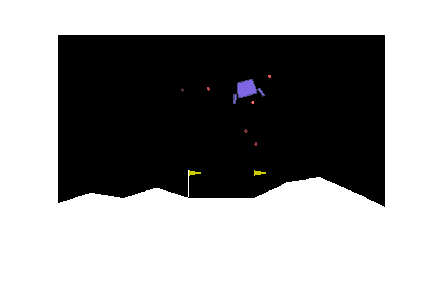
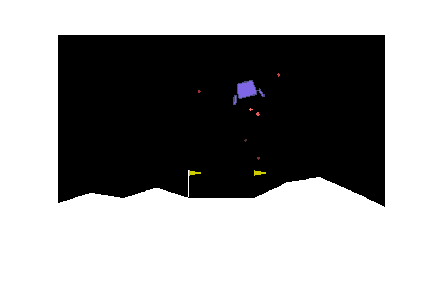
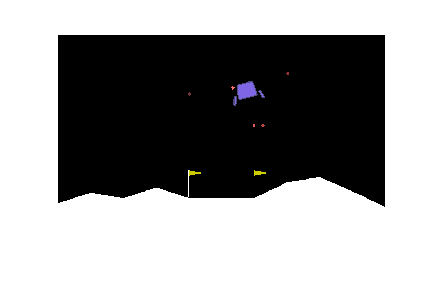
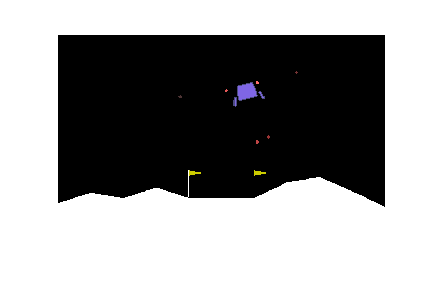
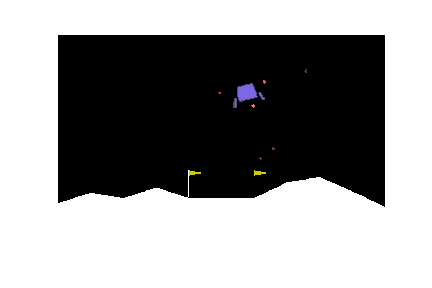
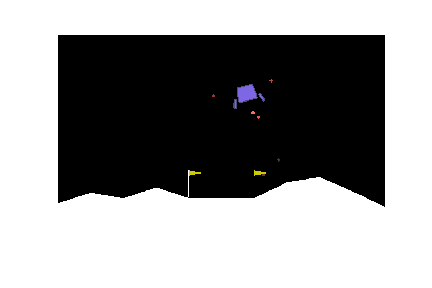
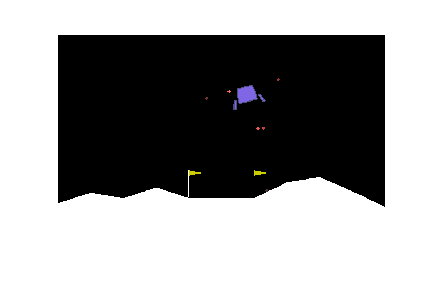
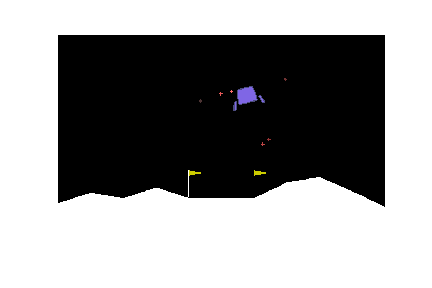
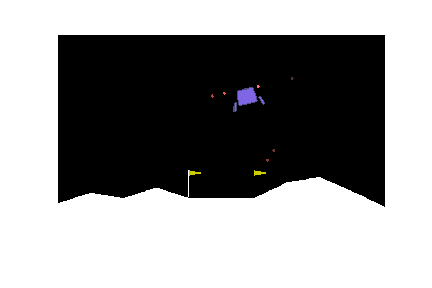
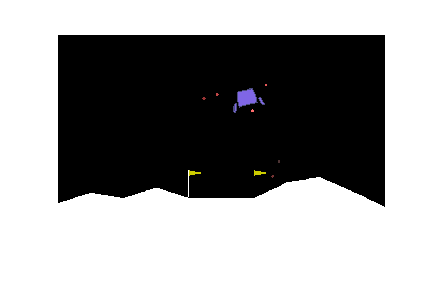
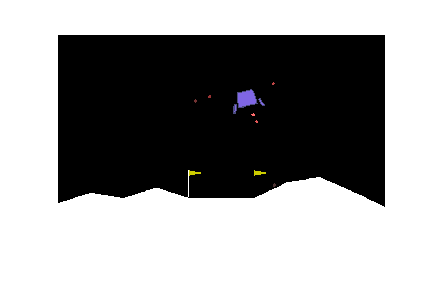
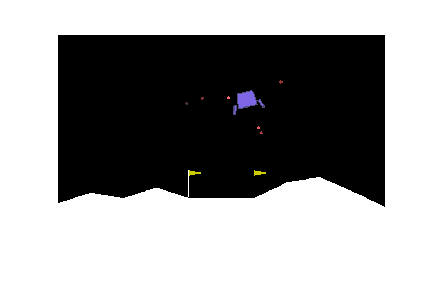
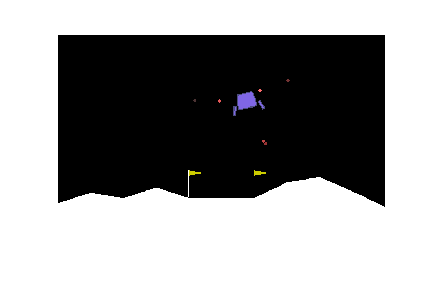
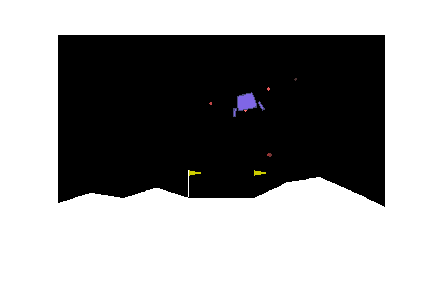
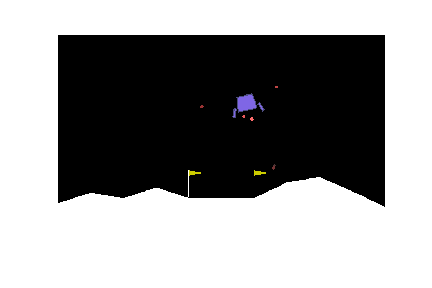
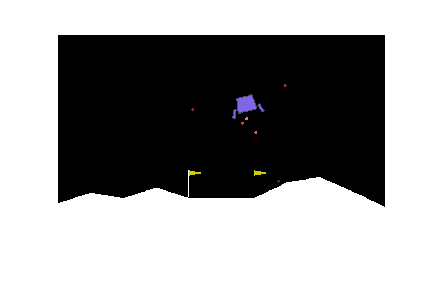
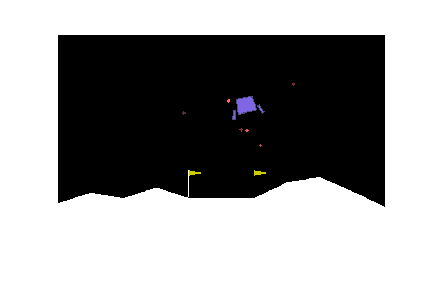
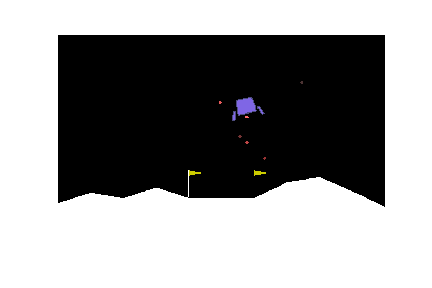
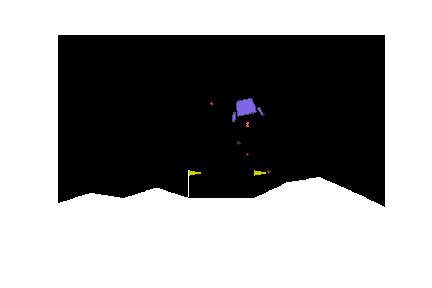
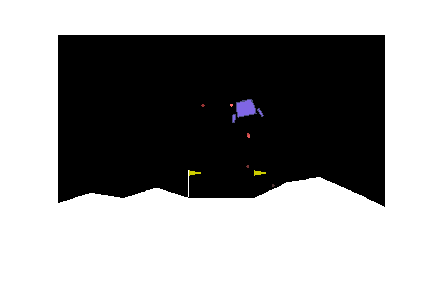
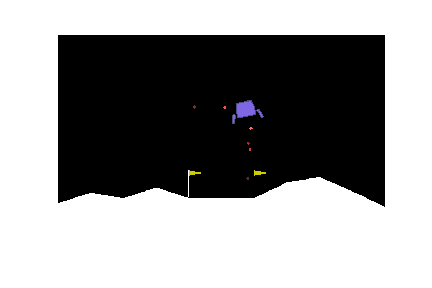
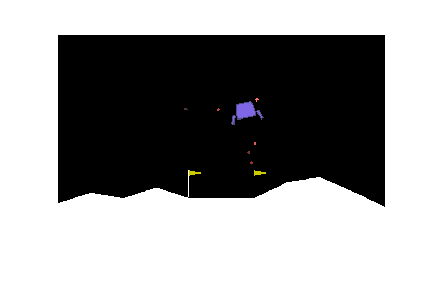
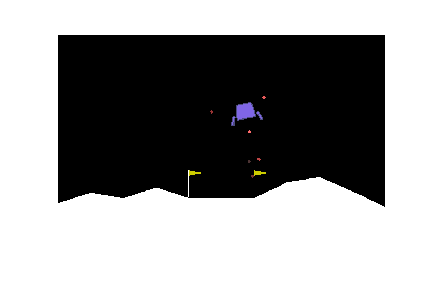
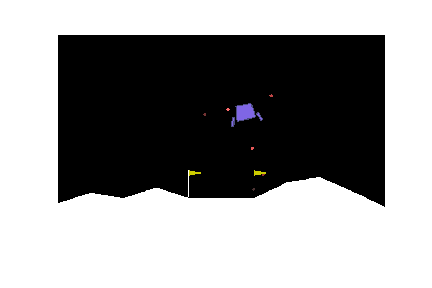
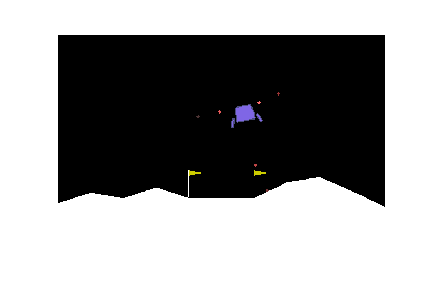
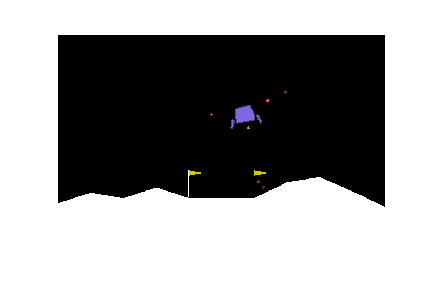
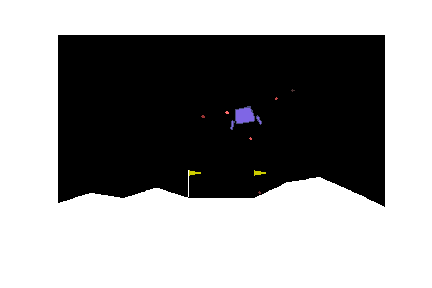
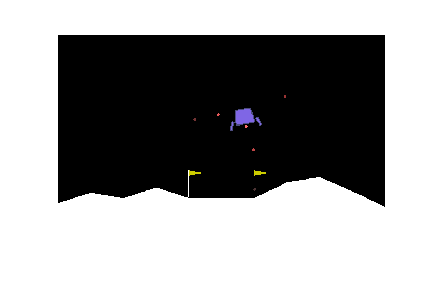
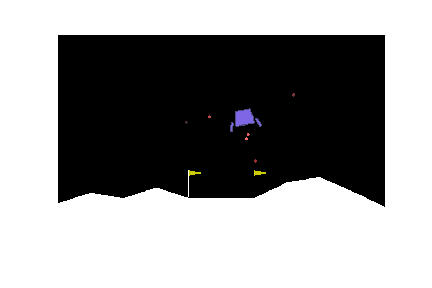
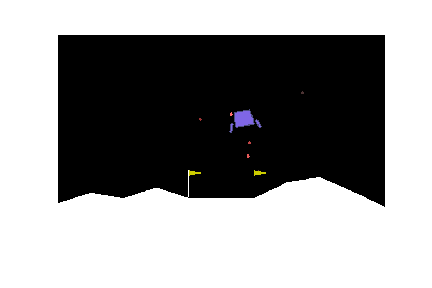
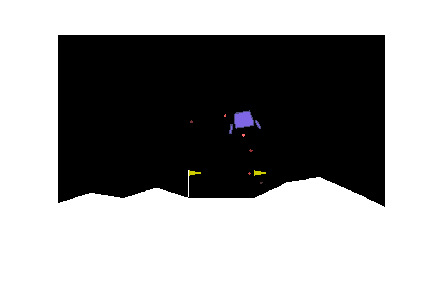
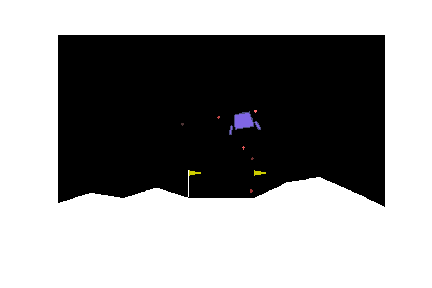
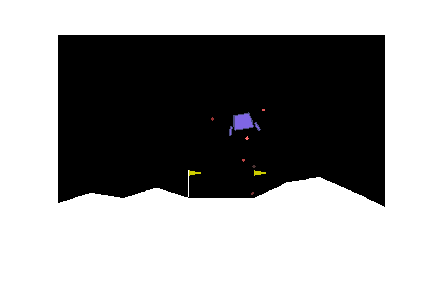
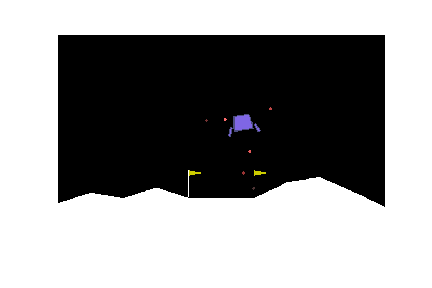
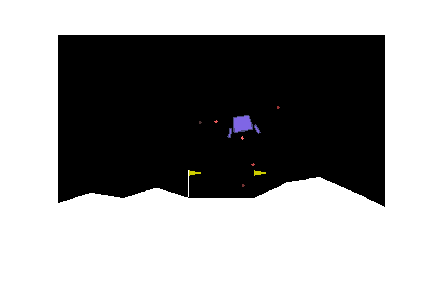
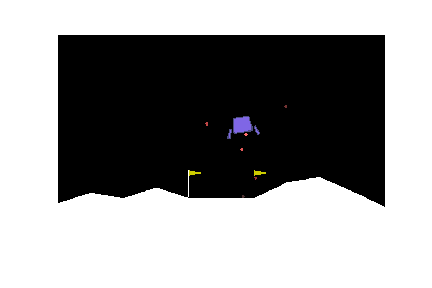
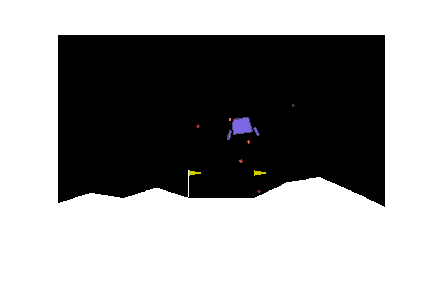
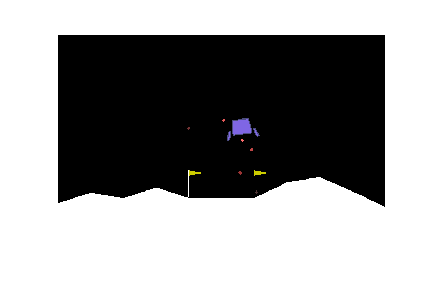
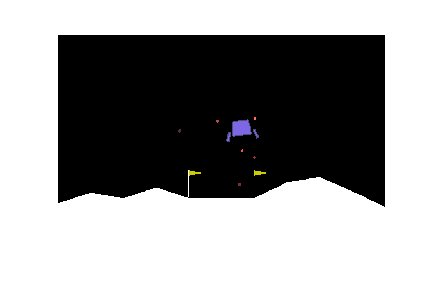
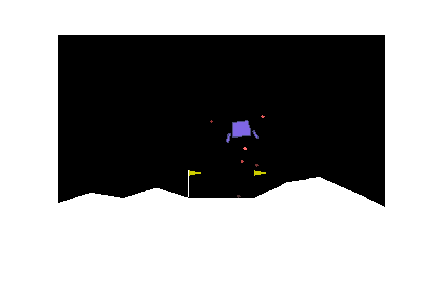
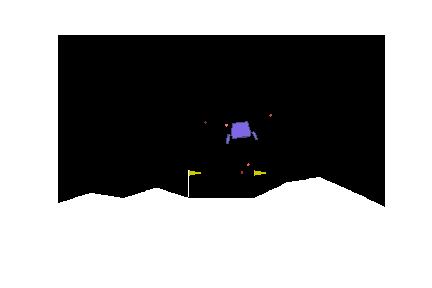
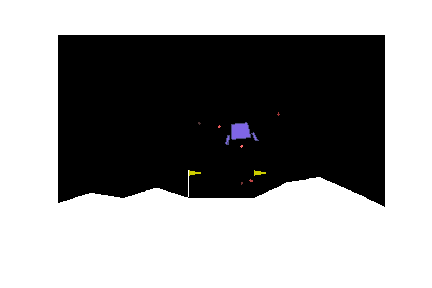
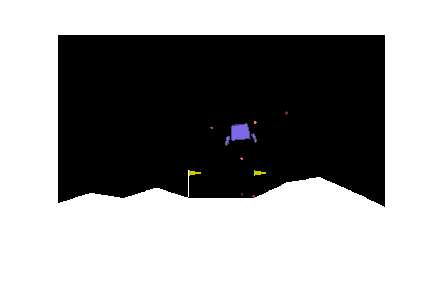
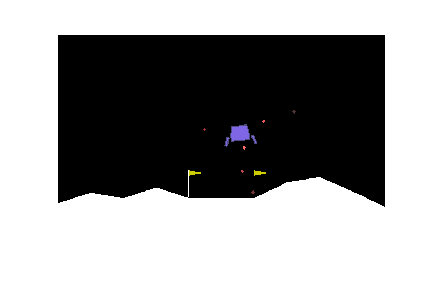
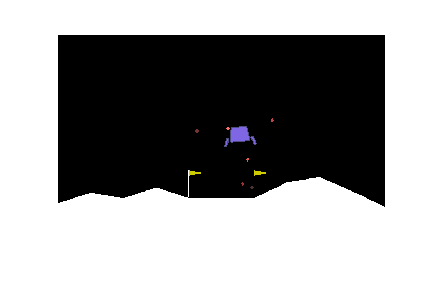
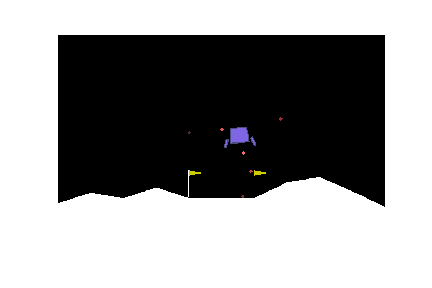
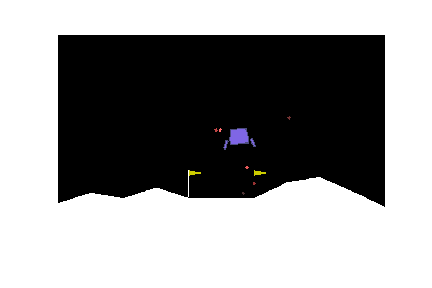
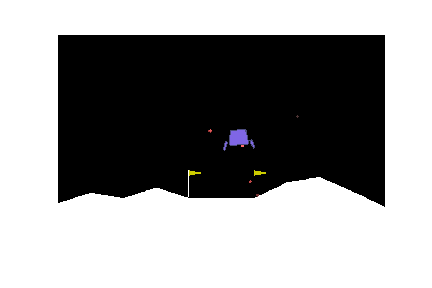
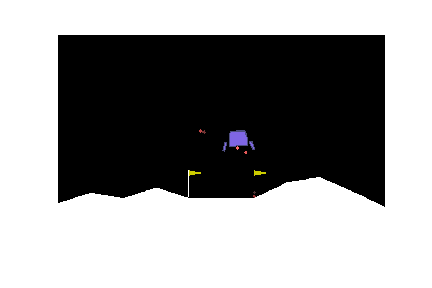
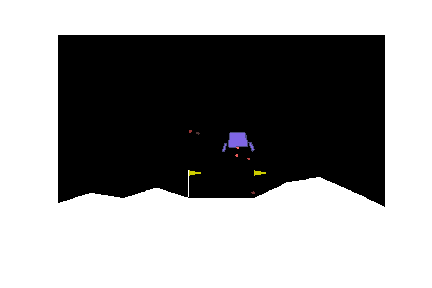
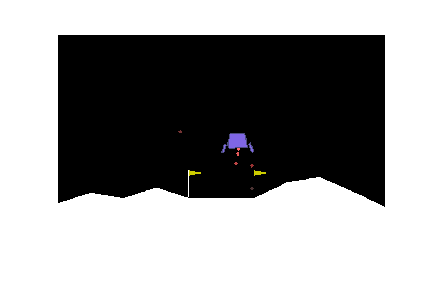
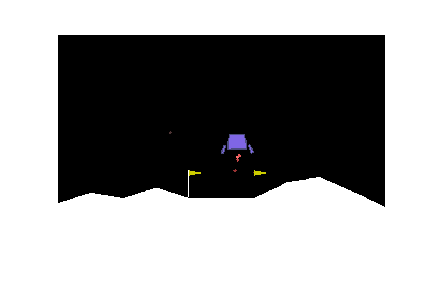
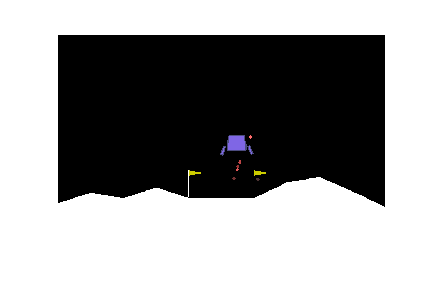
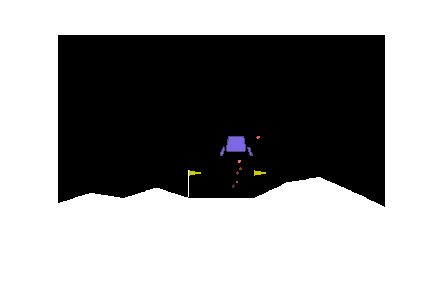
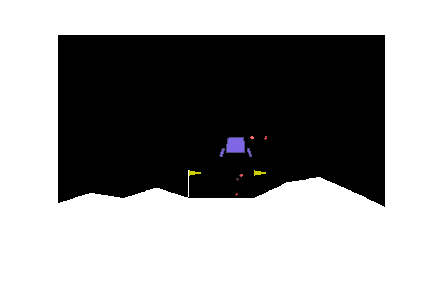
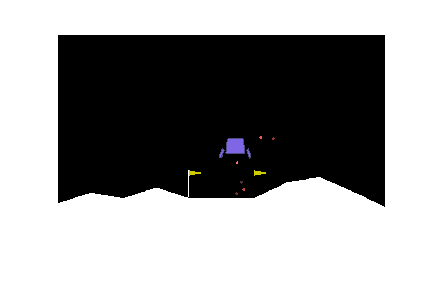
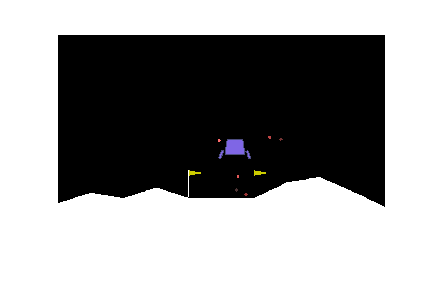
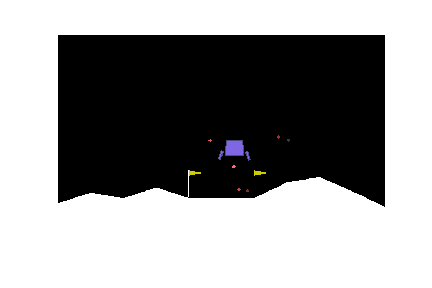
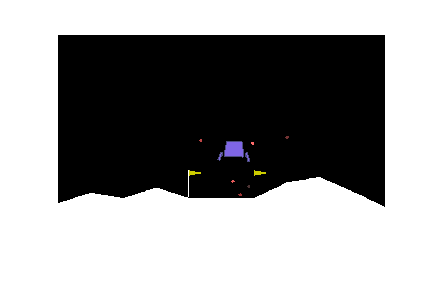
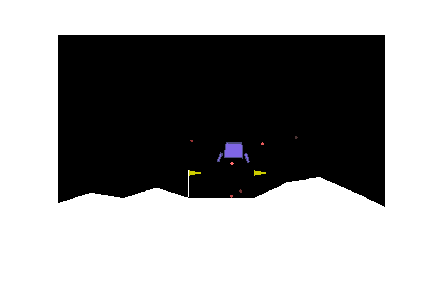
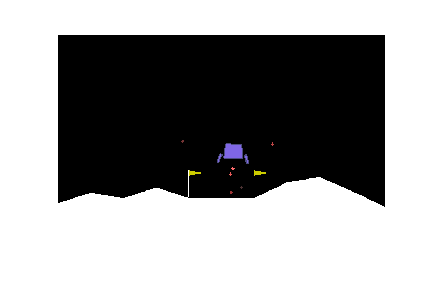
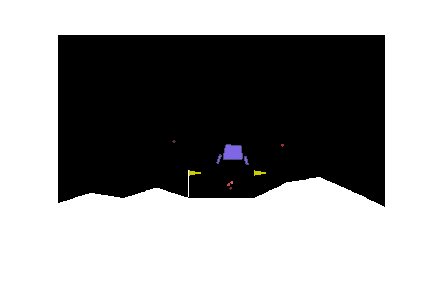
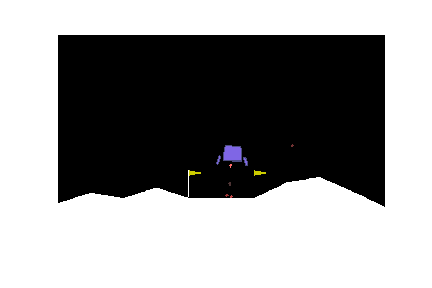
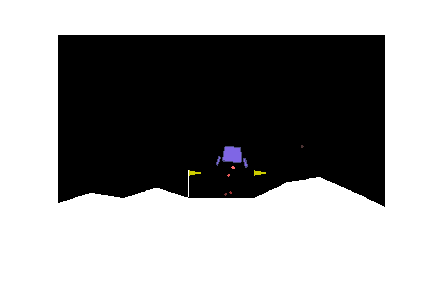
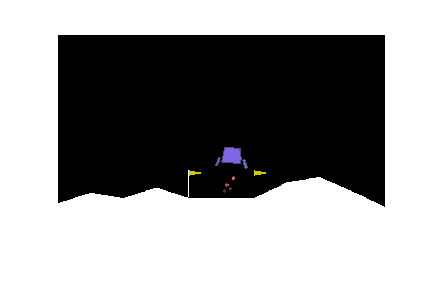
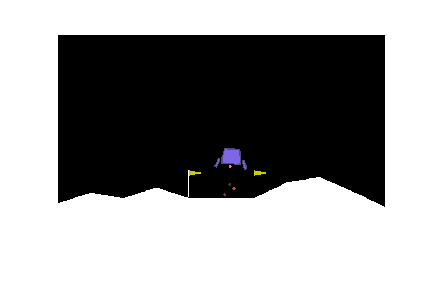
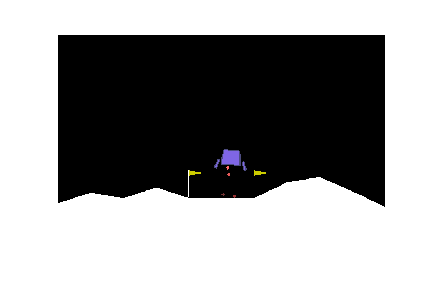
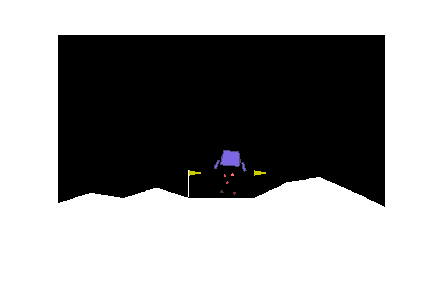
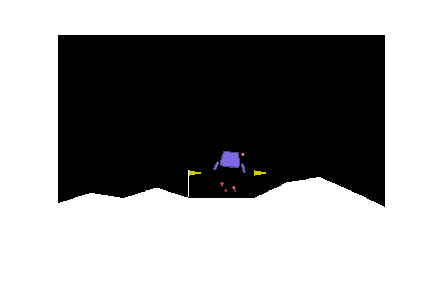
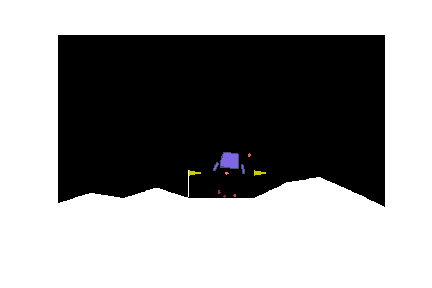
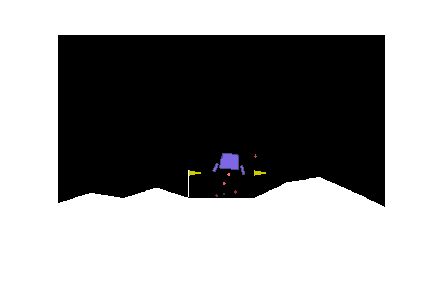
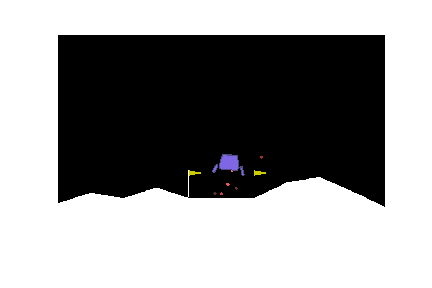
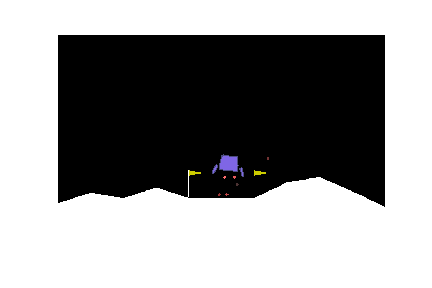
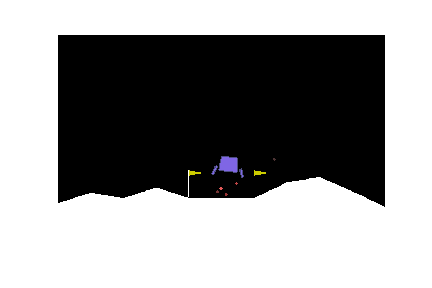
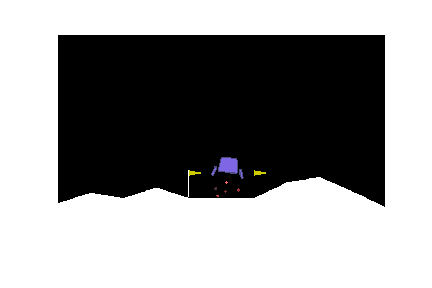
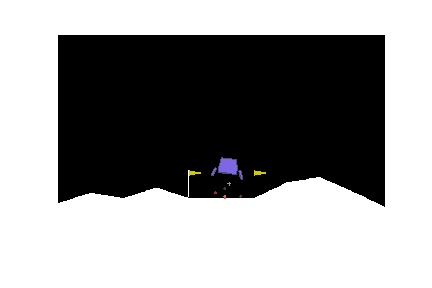
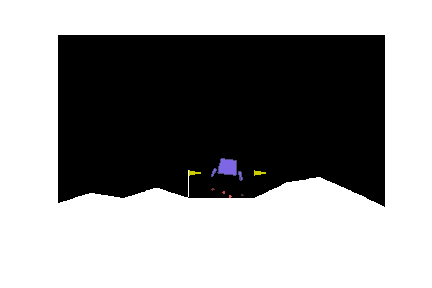
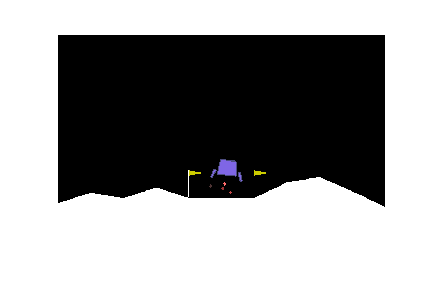
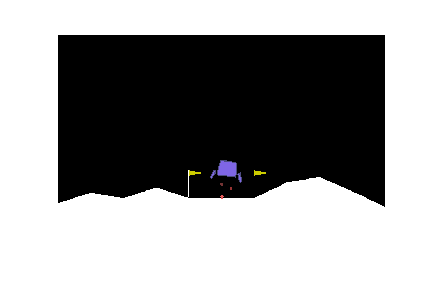
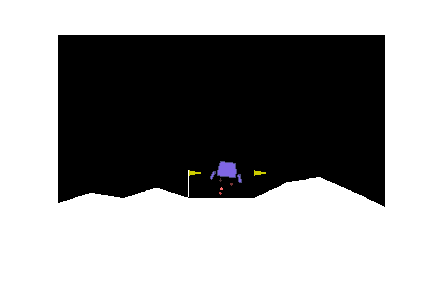
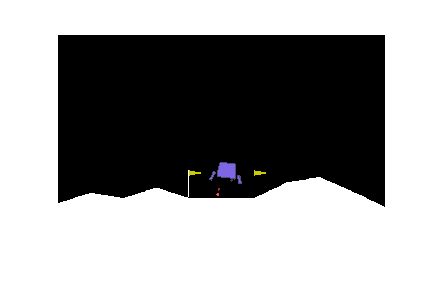
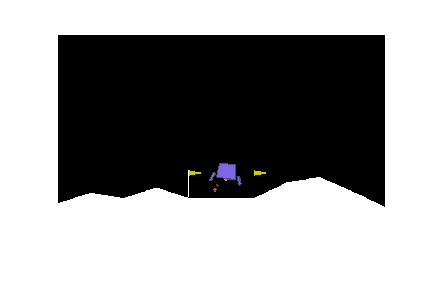
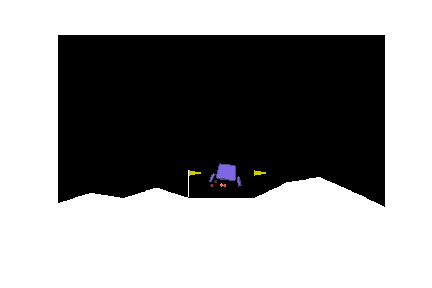
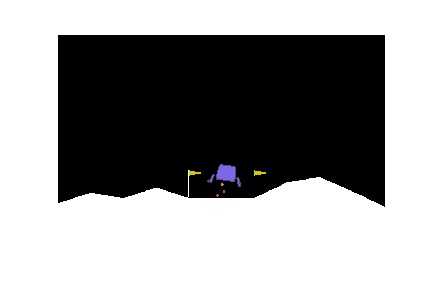
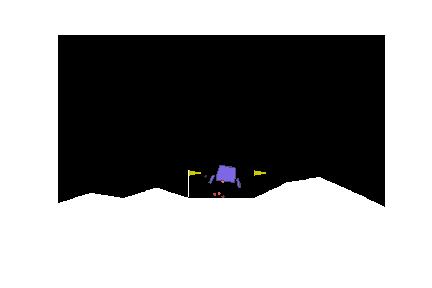
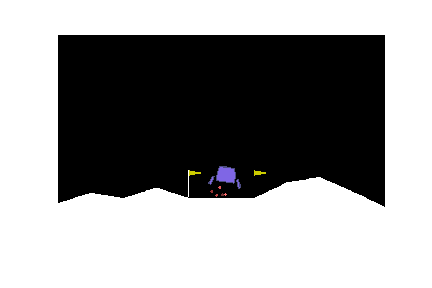
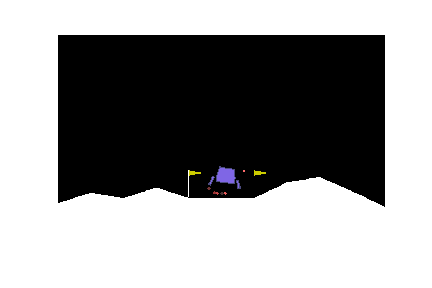
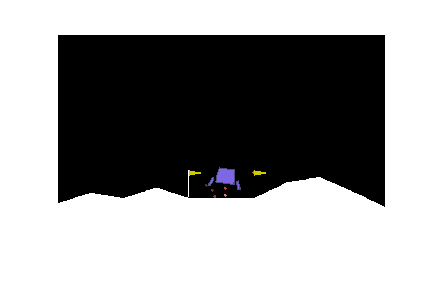
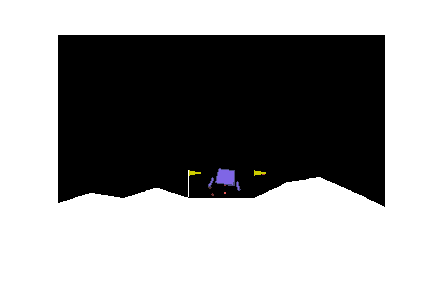
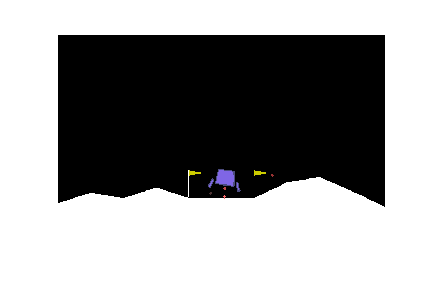
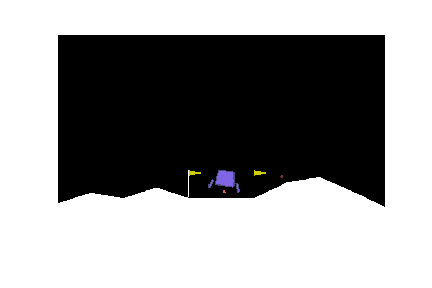
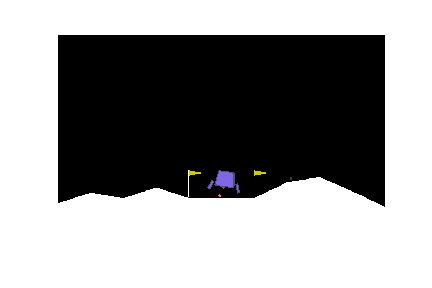
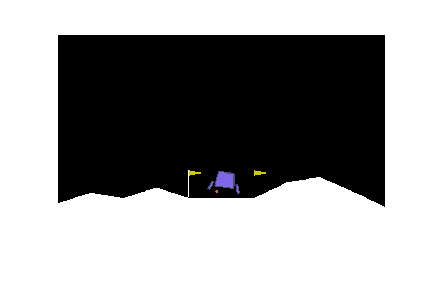
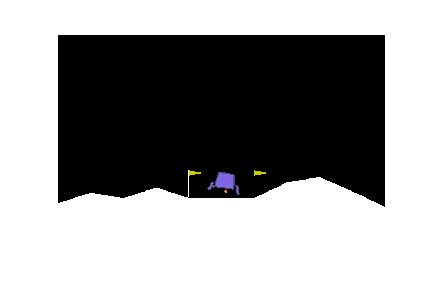
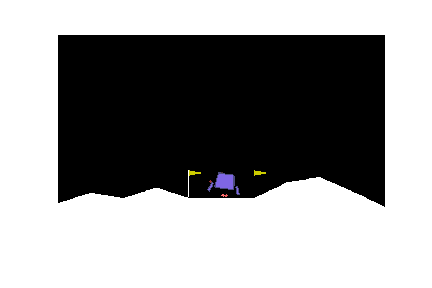
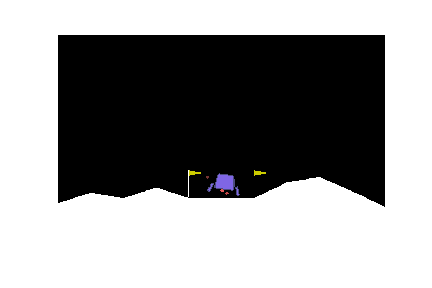
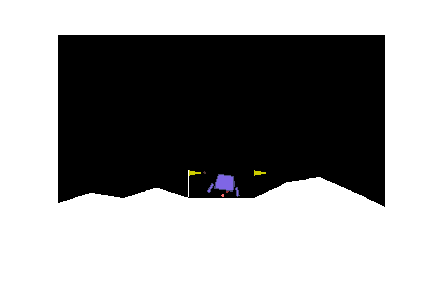
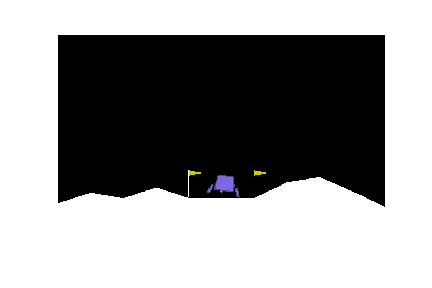
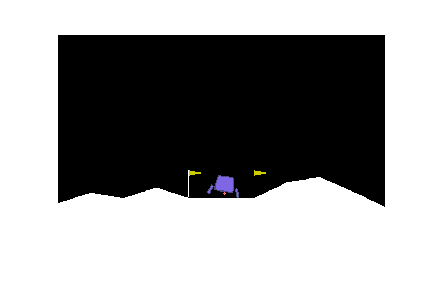
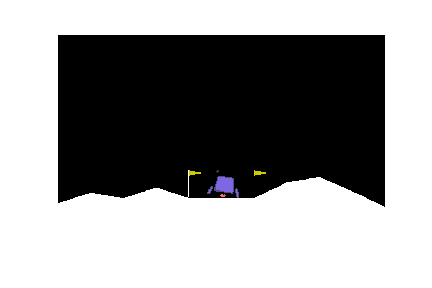
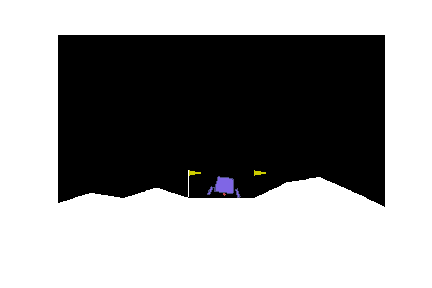
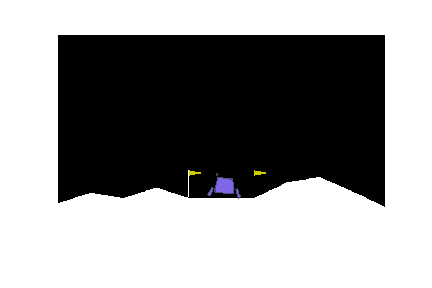
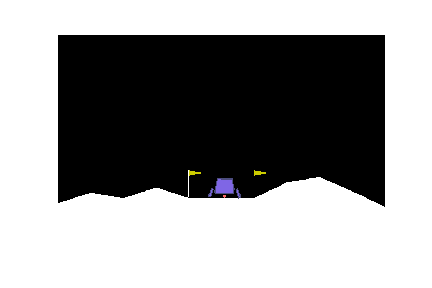
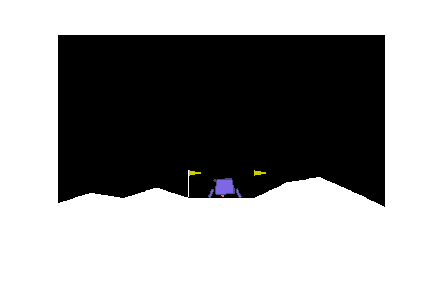
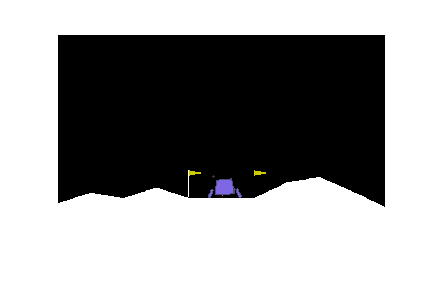
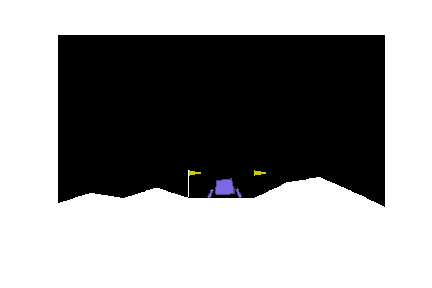
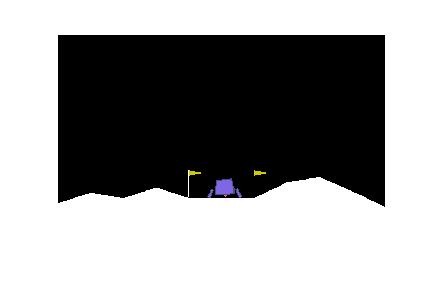
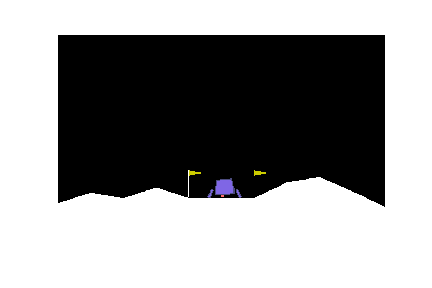
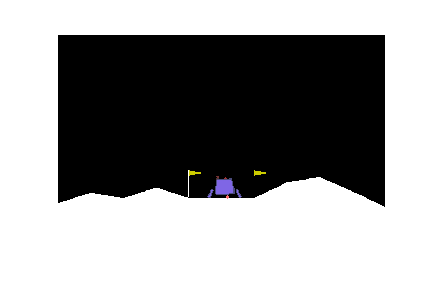
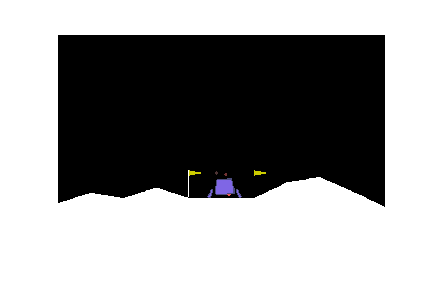
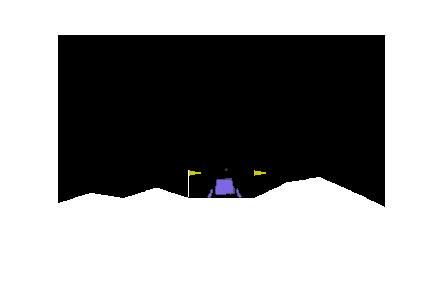
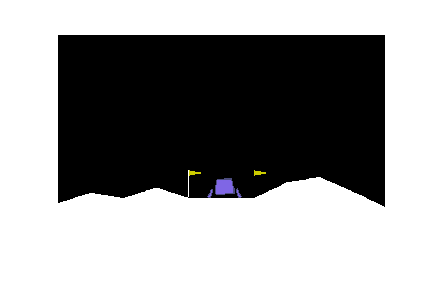
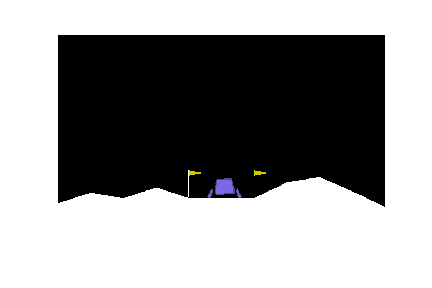
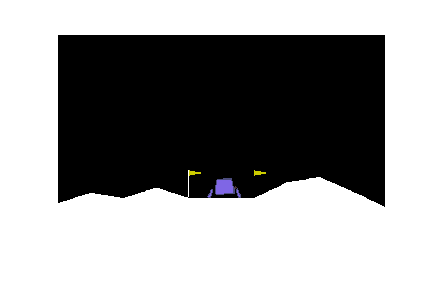
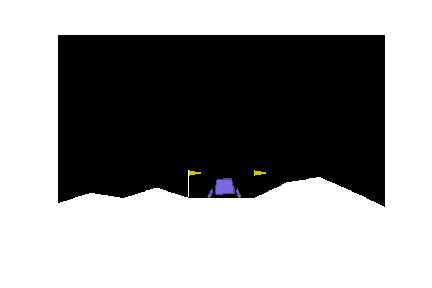
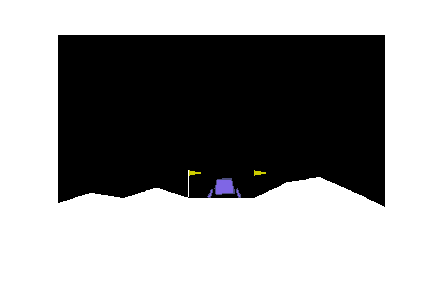
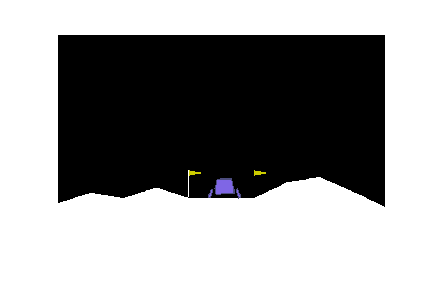
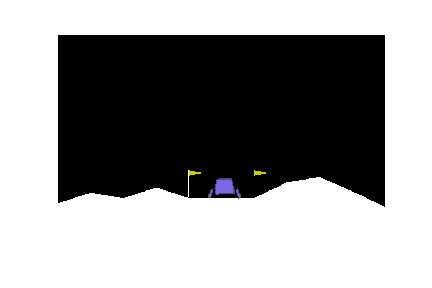
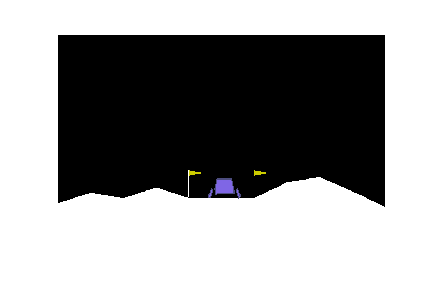
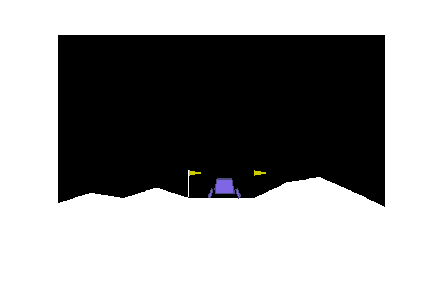
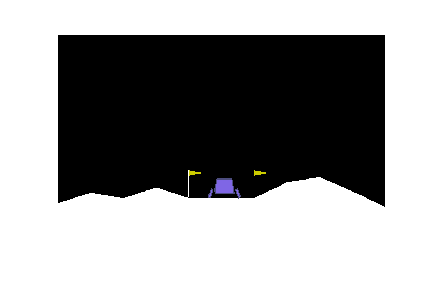
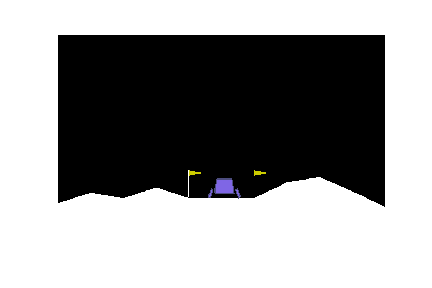
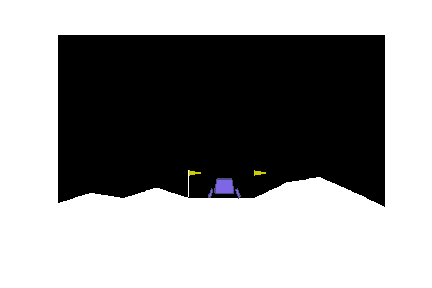
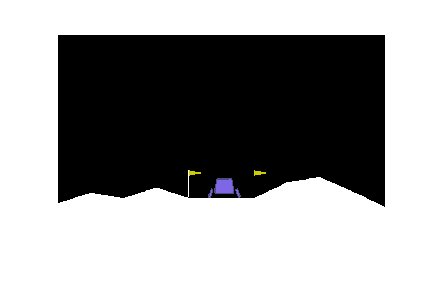
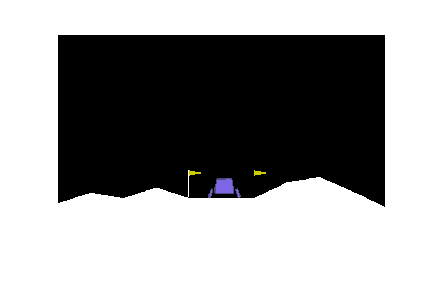
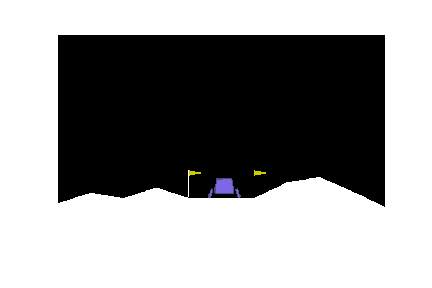
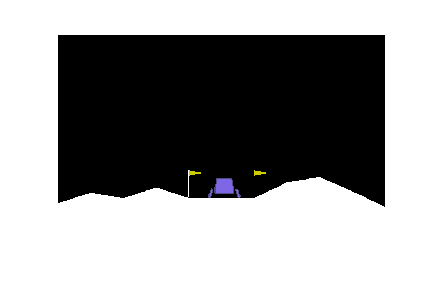
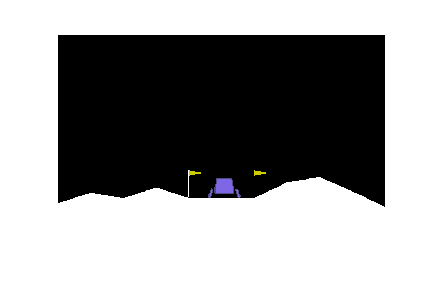
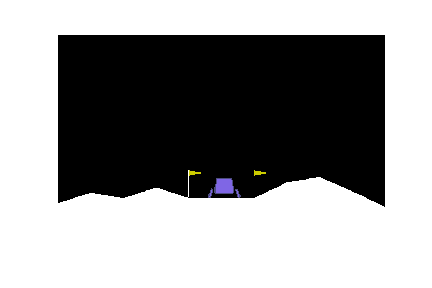
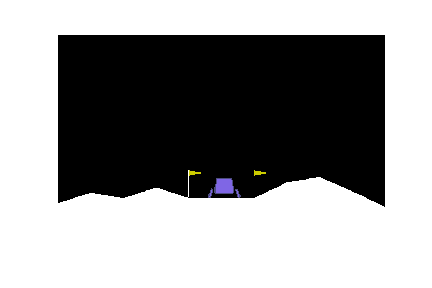
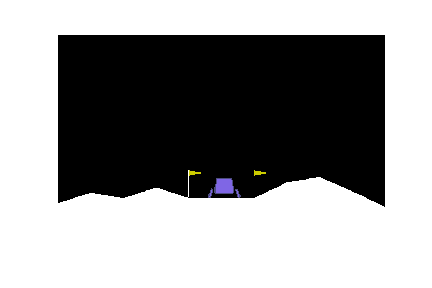
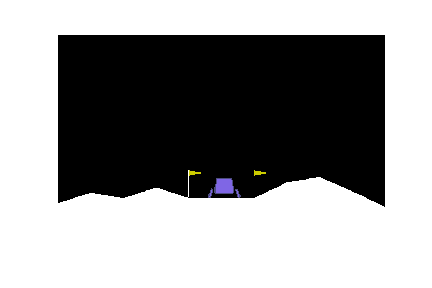
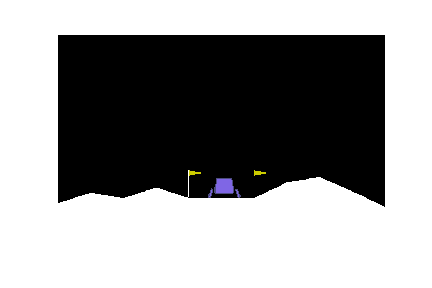
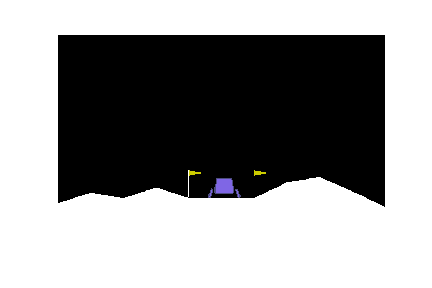
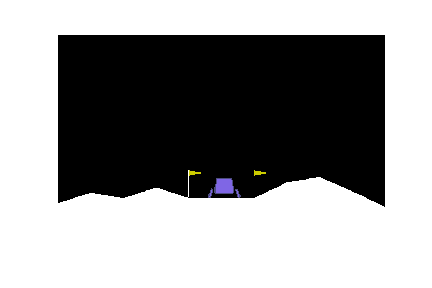
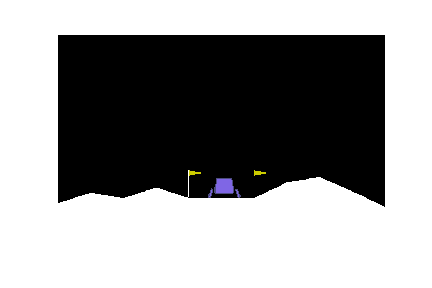
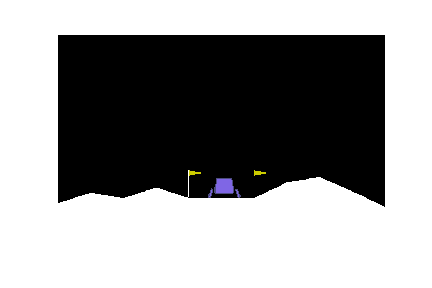
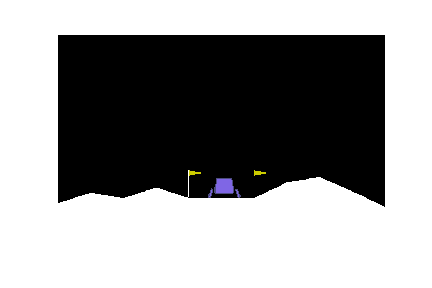
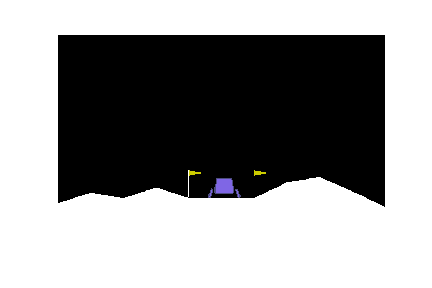
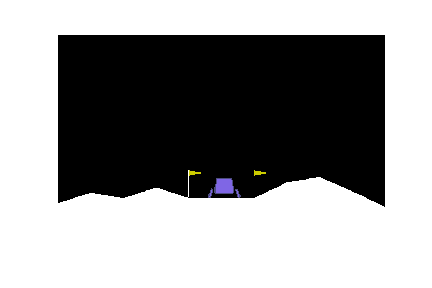
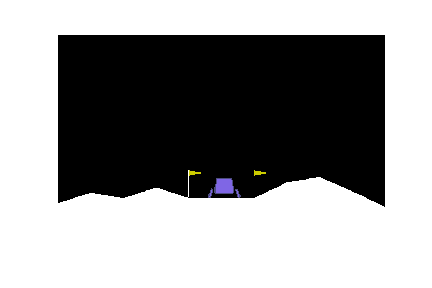
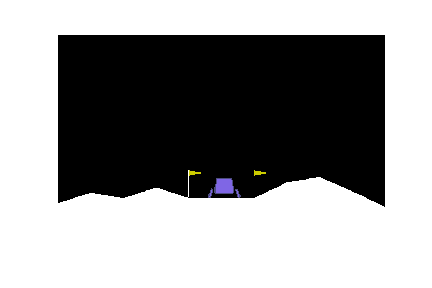
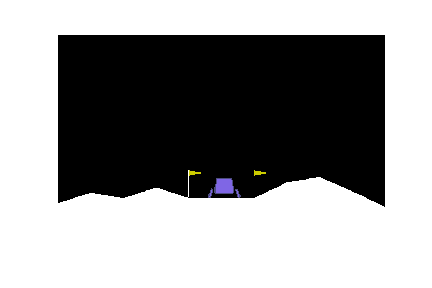
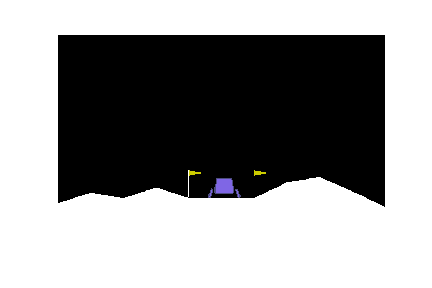
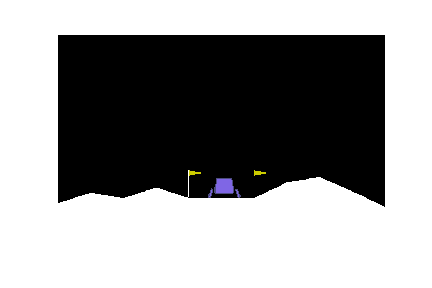
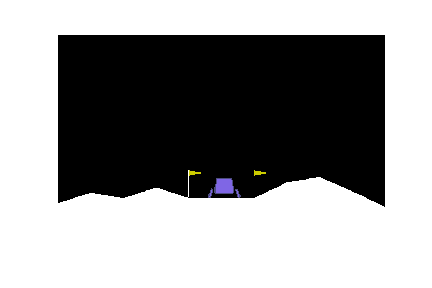
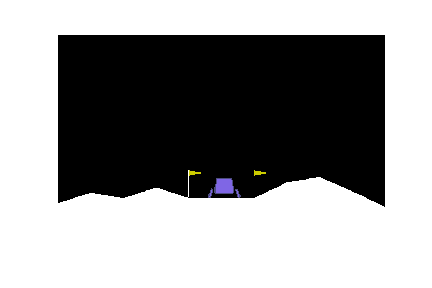
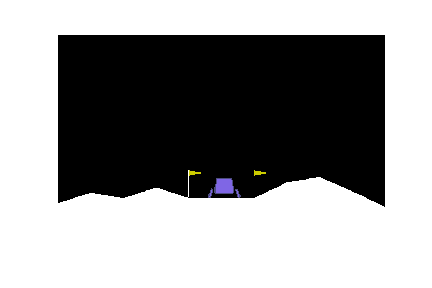
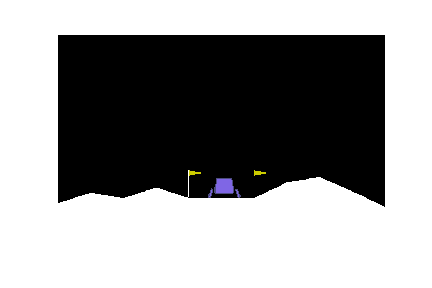
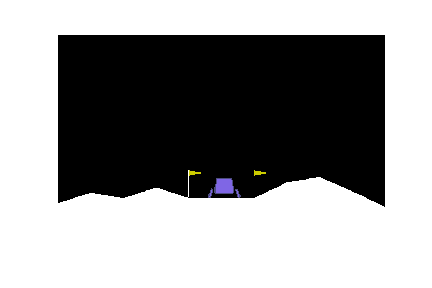
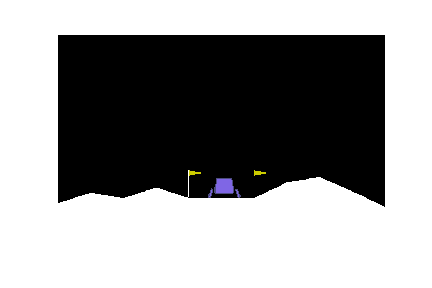
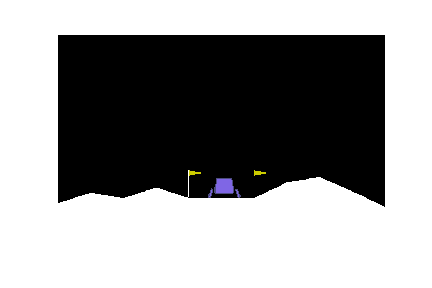
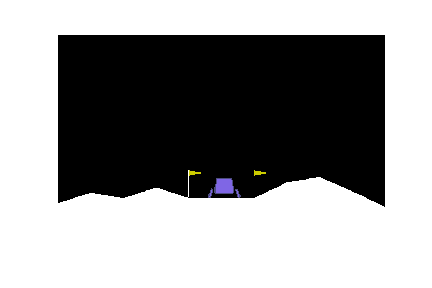
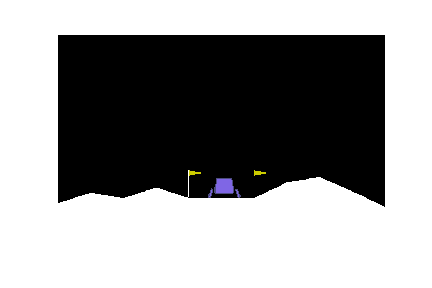

263.8988491992377

In [12]:
with open('bests_ga.pkl', 'rb') as input:
    bests = pickle.load(input)
    
episodeOnNet(bests[-1])